# Flat Fielding and Dark Subtraction

In [1]:
from astropy import stats
import scipy.ndimage
import numpy as np
%matplotlib inline
import pylab as plt
plt.rcParams['image.origin'] = 'lower'
import glob
from astropy.io import fits
from astropy import visualization
from astropy import coordinates, units as u
from astropy.table import Table, Column
from photometry_and_astrometry import photometry_and_astrometry
from astropy import table
from astropy import wcs
from astroquery.vizier import Vizier
from astroplan import FixedTarget
from astroplan.plots import plot_finder_image
from astroquery.simbad import Simbad
Simbad.reset_votable_fields()
Simbad.add_votable_fields('flux(V)', 'flux(B)', 'flux(I)', 'otype')

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!



>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]


In [2]:
def advanced_mean(name):
    name1 = glob.glob(name)
    name2 = [fits.getdata(x) for x in name1]
    name3 = np.mean(name2, axis=0)
    return name3

In [3]:
def advanced_median(name):
    name1 = glob.glob(name)
    name2 = [fits.getdata(x) for x in name1]
    name3 = np.median(name2, axis=0)
    return name3

In [4]:
def advanced_std(name):
    name1 = glob.glob(name)
    name2 = [fits.getdata(x) for x in name1]
    name3 = np.std(name2, axis=0)
    return name3

In [5]:
def advanced_flat(average, median):
    name1 = average - median
    name2 = name1/name1.mean()
    return name2

In [6]:
def dark_subtraction(name, exposure, flat):
    name1 = glob.glob(name)
    name2 = [fits.getdata(x) for x in name1]
    name3 = [im - exposure for im in name2]
    name4 = [im / flat for im in name3]
    return name4

In [7]:
def centroider(image, a,b,c,d, e=10):
    done = []
    for ii in range(e):
        cutout1 = image[0][a:b,c:d]
        yi, xi = np.indices([b-a,d-c])
        xcent = int((xi*cutout1).sum()/cutout1.sum() + c)
        ycent = int((yi*cutout1).sum()/cutout1.sum() + a)
        cutout = image[ii][a:b,c:d]
        xcen = int((xi*cutout).sum()/cutout.sum() + c)
        ycen = int((yi*cutout).sum()/cutout.sum() + a)
        x = xcen - xcent
        y = ycen - ycent
        done.append(np.roll(np.roll(image[ii], -x, axis=1), -y, axis=0))
    return done 

In [8]:
biases = advanced_median("bias*FIT")
dark5 = advanced_median("Dark_5*FIT")
dark10 = advanced_median("Dark_10*FIT")
dark25 = advanced_median("Dark_25*FIT")
dark30 = advanced_median("Dark_30*FIT")

In [9]:
flatv = advanced_mean("flat_10*FIT")
flatb = advanced_mean("flat_30*FIT")
flati = advanced_mean("flat_5*FIT")

In [10]:
flat_v = advanced_flat(flatv, dark10)
flat_b = advanced_flat(flatb, dark30)
flat_i = advanced_flat(flati, dark5)
header = fits.getheader(glob.glob("flat_10*FIT")[0])
data = flat_v
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('flatV.FIT', overwrite=True)
header = fits.getheader(glob.glob("flat_30*FIT")[0])
data = flat_b
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('flatB.FIT', overwrite=True)
header = fits.getheader(glob.glob("flat_5*FIT")[0])
data = flat_i
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('flatI.FIT', overwrite=True)

In [11]:
CB_V = dark_subtraction("CB_25s_V*FIT", dark25, flat_v)
CB_B = dark_subtraction("CB_25s_B*FIT", dark25, flat_b)
CB_I = dark_subtraction("CB_25s_I*FIT", dark25, flat_i)

In [12]:
central_V = dark_subtraction("central_25s_V*FIT", dark25, flat_v)
central_B = dark_subtraction("central_25s_B*FIT", dark25, flat_b)
central_I = dark_subtraction("central_25s_I*FIT", dark25, flat_i)

In [13]:
LB_V = dark_subtraction("LB_25s_V*FIT", dark25, flat_v)
LB_B = dark_subtraction("LB_25s_B*FIT", dark25, flat_b)
LB_I = dark_subtraction("LB_25s_I*FIT", dark25, flat_i)

In [14]:
LC_V = dark_subtraction("LC_25s_V*FIT", dark25, flat_v)
LC_B = dark_subtraction("LC_25s_B*FIT", dark25, flat_b)
LC_I = dark_subtraction("LC_25s_I*FIT", dark25, flat_i)

In [15]:
RB_V = dark_subtraction("RB_25s_V*FIT", dark25, flat_v)
RB_B = dark_subtraction("RB_25s_B*FIT", dark25, flat_b)
RB_I = dark_subtraction("RB_25s_I*FIT", dark25, flat_i)

In [16]:
RC_V = dark_subtraction("RC_25s_V*FIT", dark25, flat_v)
RC_B = dark_subtraction("RC_25s_B*FIT", dark25, flat_b)
RC_I = dark_subtraction("RC_25s_I*FIT", dark25, flat_i)

In [17]:
b4 = glob.glob("RC_25s_I*FIT")
before = [fits.getdata(x) for x in b4]

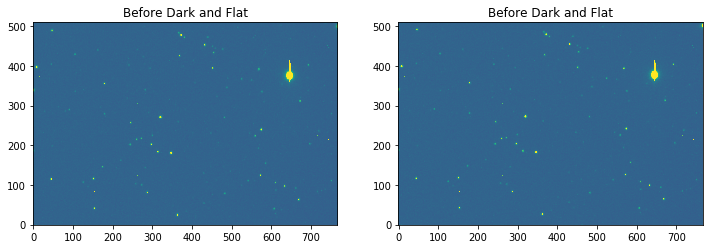

In [18]:
plt.figure(figsize=(12,12))

for ii in range(2):
    ax = plt.subplot(2,2,ii+1)
    ax.imshow(before[ii], origin='lower', vmax=2500, vmin=500)
    ax.set_title("Before Dark and Flat")

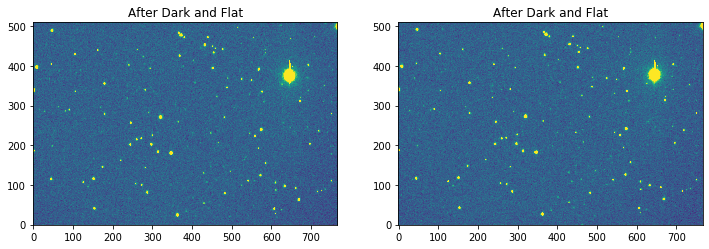

In [19]:
plt.figure(figsize=(12,12))

for ii in range(2):
    ax = plt.subplot(2,2,ii+1)
    ax.imshow(RC_I[ii], origin='lower', vmax=300, vmin=0)
    ax.set_title("After Dark and Flat")

# Alignment

In [20]:
background1 = np.median(np.median(CB_V))
background2 = np.median(np.median(CB_B))
background3 = np.median(np.median(CB_I))
background4 = np.median(np.median(central_V))
background5 = np.median(np.median(central_B))
background6 = np.median(np.median(central_I))
background7 = np.median(np.median(LB_V))
background8 = np.median(np.median(LB_B))
background9 = np.median(np.median(LB_I))
background10 = np.median(np.median(LC_V))
background11 = np.median(np.median(LC_B))
background12 = np.median(np.median(LC_I))
background13 = np.median(np.median(RB_V))
background14 = np.median(np.median(RB_B))
background15 = np.median(np.median(RB_I))
background16 = np.median(np.median(RC_V))
background17 = np.median(np.median(RC_B))
background18 = np.median(np.median(RC_I))
backgroundV = [background1, background4, background7, background10, background13, background16]
backgroundB = [background2, background5, background8, background11, background14, background17]
backgroundI = [background3, background6, background9, background12, background15, background18]
avgV = np.median(backgroundV)
avgB = np.median(backgroundB)
avgI = np.median(backgroundI)

## CB Alignments

Text(0.5, 1.0, 'Median Stack')

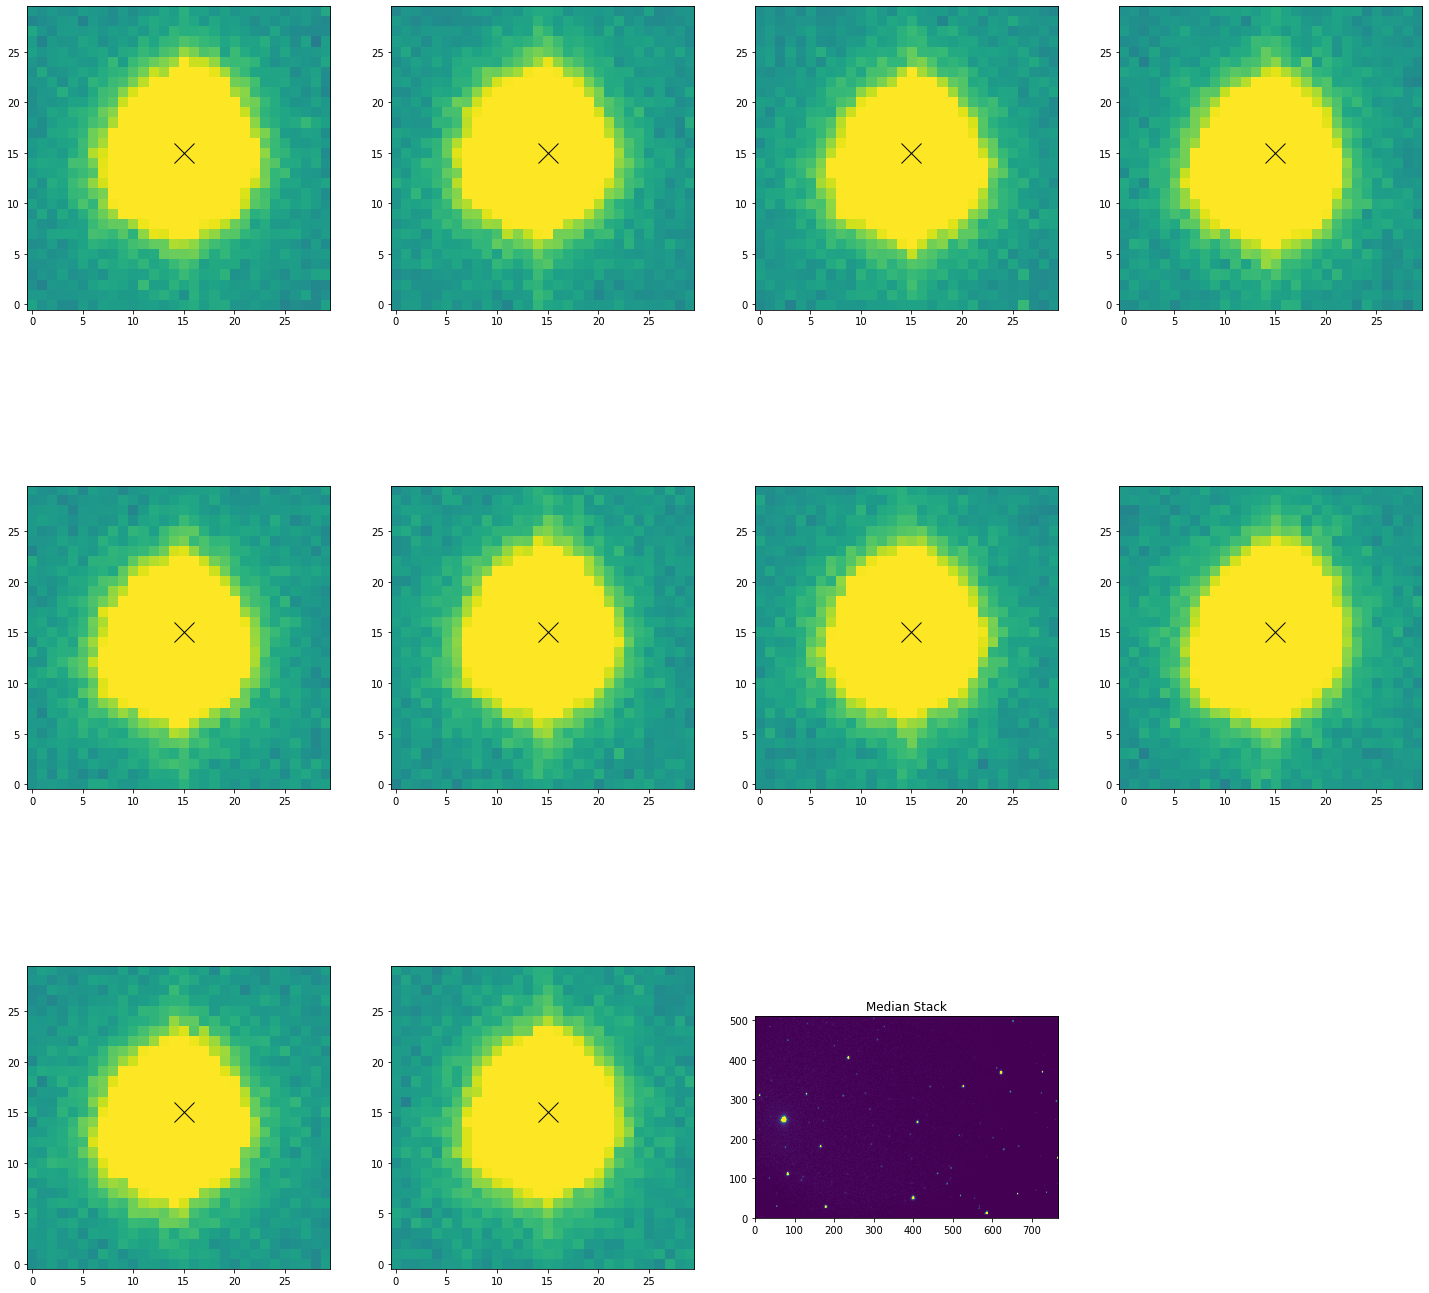

In [21]:
CBV1 = CB_V[0]
CBV2 = np.roll(np.roll(CB_V[1], -1, axis=1), 1, axis=0)
CBV3 = np.roll(np.roll(CB_V[2], -3, axis=1), -1, axis=0)
CBV4 = np.roll(np.roll(CB_V[3], -4, axis=1), -1, axis=0)
CBV5 = np.roll(np.roll(CB_V[4], -5, axis=1), 0, axis=0)
CBV6 = np.roll(np.roll(CB_V[5], -6, axis=1), 0, axis=0)
CBV7 = np.roll(np.roll(CB_V[6], -7, axis=1), 3, axis=0)
CBV8 = np.roll(np.roll(CB_V[7], -9, axis=1), -1, axis=0)
CBV9 = np.roll(np.roll(CB_V[8], -11, axis=1), -5, axis=0)
CBV0 = np.roll(np.roll(CB_V[9], -13, axis=1), -5, axis=0)
CB_V2 = [CBV1, CBV2, CBV3, CBV4, CBV5, CBV6, CBV7, CBV8, CBV9, CBV0]
CB_V1 = centroider(CB_V2, 234, 264, 58, 88)
CBV = np.median(CB_V1, axis=0) - np.median(np.median(CB_V1, axis=0))

plt.figure(figsize=(25,25))

for ii in range(10):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(CB_V1[ii][234:264,58:88], origin='lower', vmax=600, vmin=0)
    ax.plot(15, 15, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(CBV, origin='lower', vmax=600, vmin=0)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

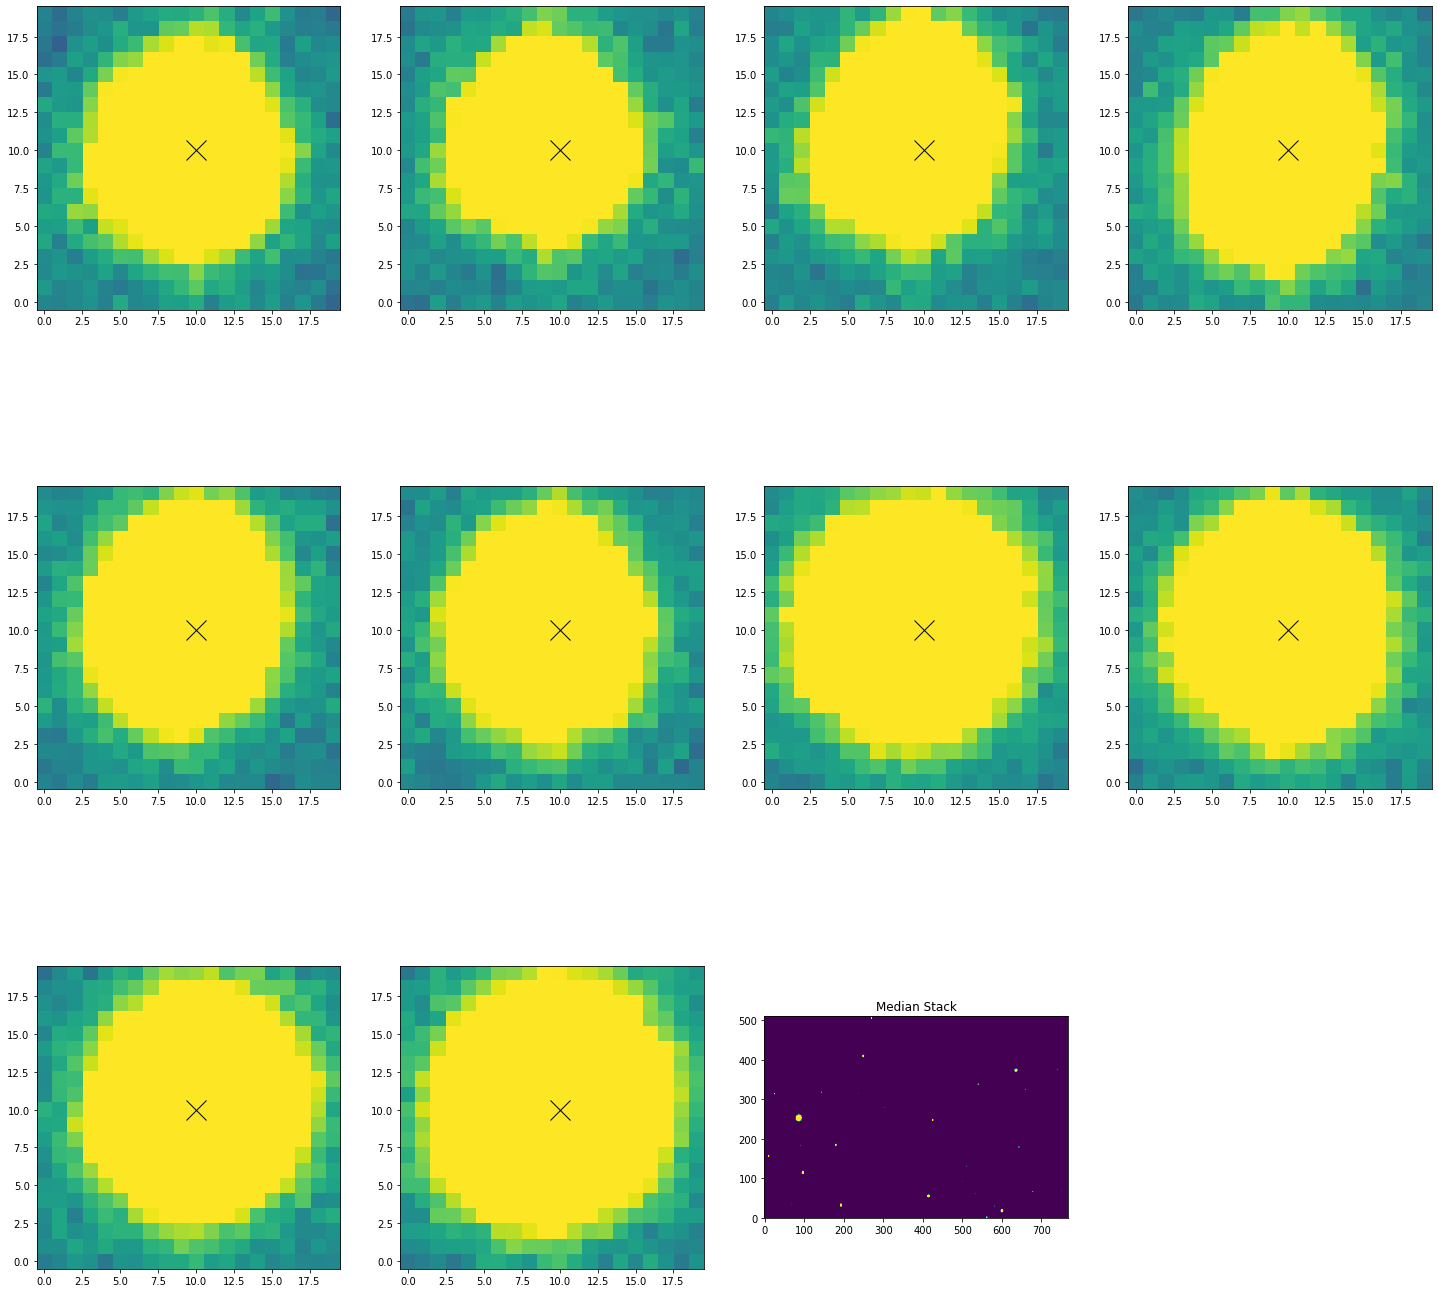

In [22]:
CBB1 = np.roll(np.roll(CB_B[0], 0, axis=1), -1, axis=0)
CBB2 = CB_B[1]
CBB3 = np.roll(np.roll(CB_B[2], -1, axis=1), -2, axis=0)
CBB4 = np.roll(np.roll(CB_B[3], -3, axis=1), -8, axis=0)
CBB5 = np.roll(np.roll(CB_B[4], -4, axis=1), -14, axis=0)
CBB6 = np.roll(np.roll(CB_B[5], -5, axis=1), -15, axis=0)
CBB7 = np.roll(np.roll(CB_B[6], -6, axis=1), -13, axis=0)
CBB8 = np.roll(np.roll(CB_B[7], -7, axis=1), -11, axis=0)
CBB9 = np.roll(np.roll(CB_B[8], -7, axis=1), -9, axis=0)
CBB0 = np.roll(np.roll(CB_B[9], -8, axis=1), -9, axis=0)
CB_B2 = [CBB1, CBB2, CBB3, CBB4, CBB5, CBB6, CBB7, CBB8, CBB9, CBB0]
CB_B1 = centroider(CB_B2, 242,262,78,98)
CBB = np.median(CB_B1, axis=0) - np.median(np.median(CB_B1, axis=0))

plt.figure(figsize=(25,25))

for ii in range(10):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(CB_B1[ii][242:262,78:98], origin='lower', vmax=300, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(CBB, origin='lower', vmax=200, vmin=50)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

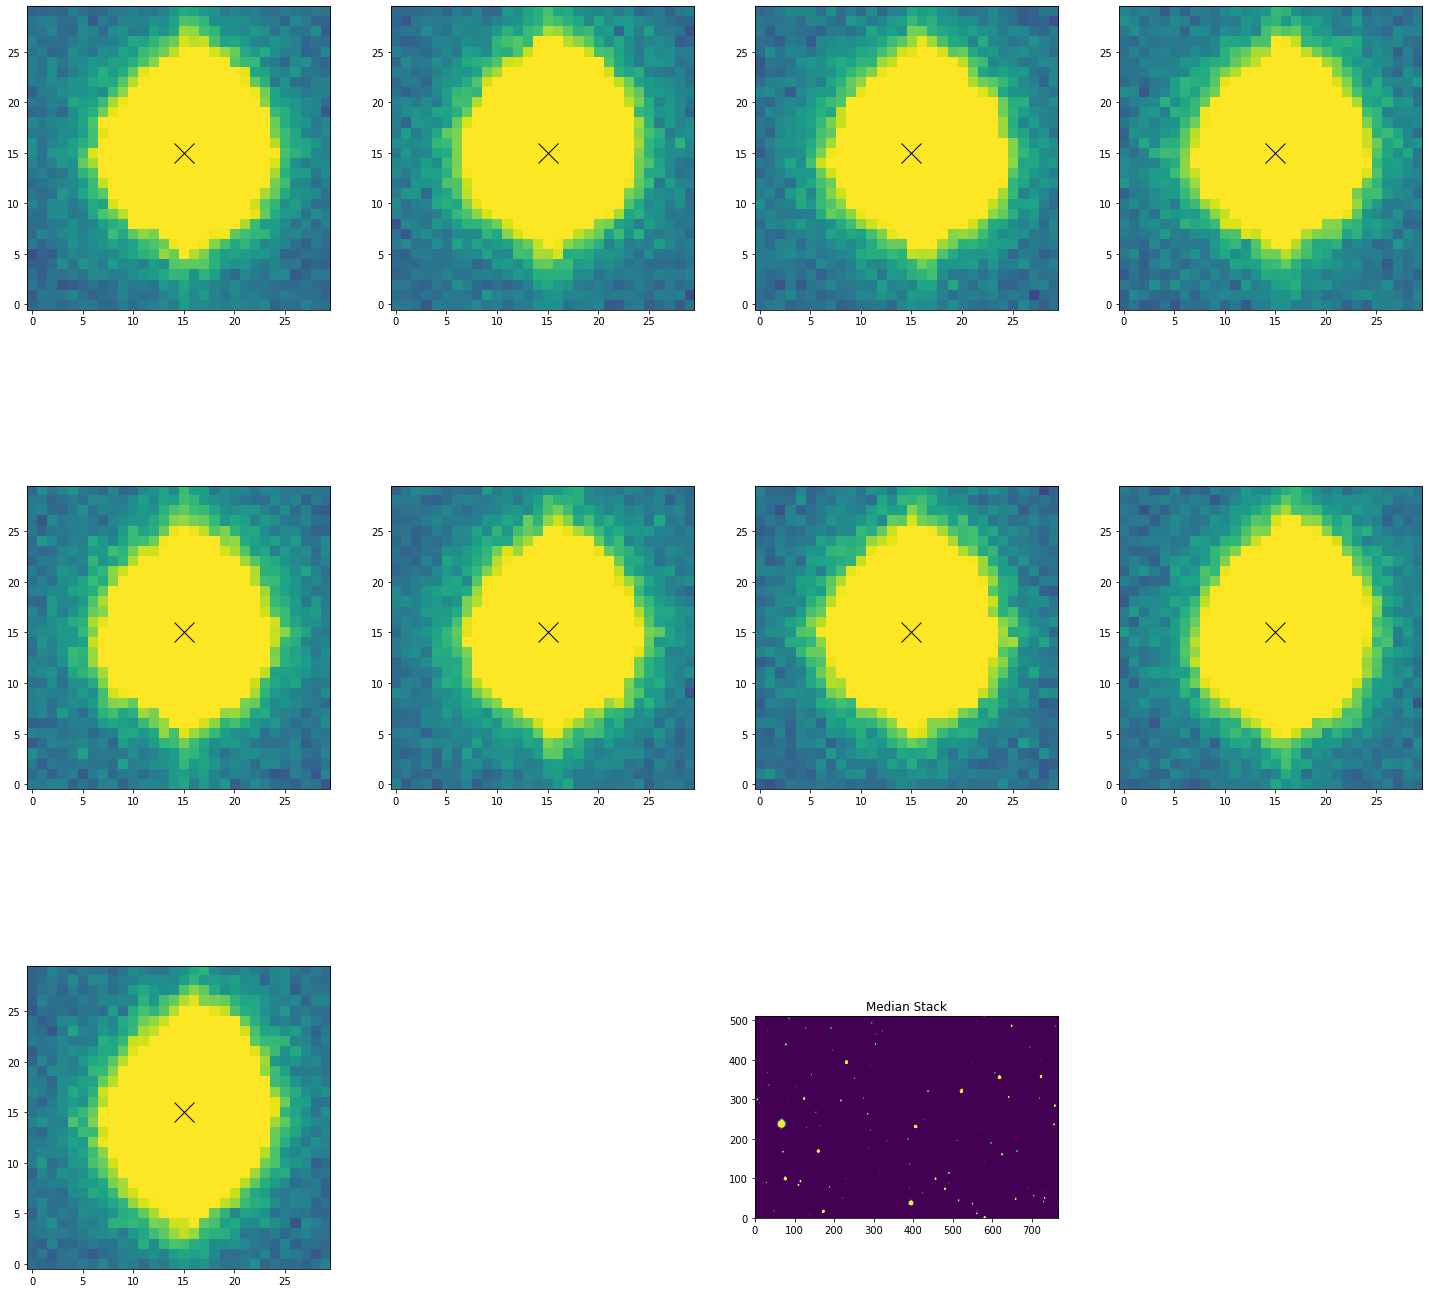

In [23]:
CBI1 = np.roll(np.roll(CB_I[0], 1, axis=1), 0, axis=0)
CBI2 = np.roll(np.roll(CB_I[1], 0, axis=1), -3, axis=0)
#CBI3 = np.roll(np.roll(CB_I[2], 0, axis=1), -3, axis=0)
#The photo here came out poorly, so we won't be using it!
CBI4 = np.roll(np.roll(CB_I[3], 1, axis=1), -2, axis=0)
CBI5 = np.roll(np.roll(CB_I[4], 1, axis=1), -3, axis=0)
CBI6 = np.roll(np.roll(CB_I[5], 0, axis=1), -4, axis=0)
CBI7 = np.roll(np.roll(CB_I[6], -1, axis=1), -3, axis=0)
CBI8 = np.roll(np.roll(CB_I[7], -1, axis=1), -2, axis=0)
CBI9 = np.roll(np.roll(CB_I[8], -2, axis=1), -4, axis=0)
CBI0 = np.roll(np.roll(CB_I[9], -3, axis=1), -11, axis=0)
CB_I2 = [CBI1, CBI2, CBI4, CBI5, CBI6, CBI7, CBI8, CBI9, CBI0]
CB_I1 = centroider(CB_I2, 222,252,51,81, e=9)
CBI = np.median(CB_I1, axis=0) - np.median(np.median(CB_I1, axis=0))

plt.figure(figsize=(25,25))

for ii in range(9):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(CB_I1[ii][222:252,51:81], origin='lower', vmax=300, vmin=0)
    ax.plot(15, 15, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(CBI, origin='lower', vmax=200, vmin=50)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

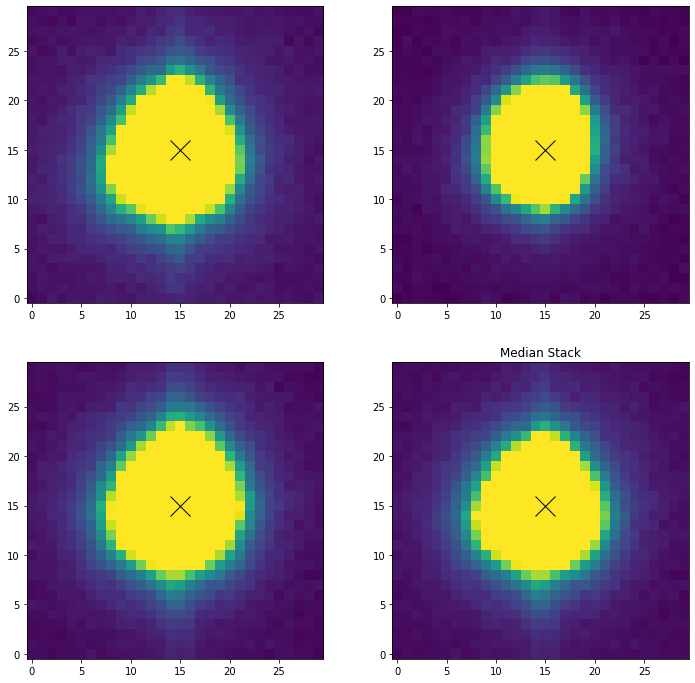

In [24]:
CBV_Aligned1 = np.roll(np.roll(CBV, -7, axis=1), -12, axis=0)
CBB_Aligned1 = np.roll(np.roll(CBB, -22, axis=1), -15, axis=0)
CBI_Aligned1 = np.roll(np.roll(CBI, 0, axis=1), 0, axis=0)
cutout1 = CBV_Aligned1[222:252,51:81]
cutout2 = CBB_Aligned1[222:252,51:81]
cutout3 = CBI_Aligned1[222:252,51:81]
y1, x1 = np.indices([30,30])
xcent1 = int((x1*cutout1).sum()/cutout1.sum() + 51)
ycent1 = int((y1*cutout1).sum()/cutout1.sum() + 222)
xcent2 = int((x1*cutout2).sum()/cutout2.sum() + 51)
ycent2 = int((y1*cutout2).sum()/cutout2.sum() + 222)
xcent3 = int((x1*cutout3).sum()/cutout3.sum() + 51)
ycent3 = int((y1*cutout3).sum()/cutout3.sum() + 222)
CBV_Aligned = np.roll(np.roll(CBV_Aligned1, xcent1 - xcent1, axis=1), ycent1 - ycent1, axis=0)
CBB_Aligned = np.roll(np.roll(CBB_Aligned1, xcent1 - xcent2, axis=1), ycent1 - ycent2, axis=0)
CBI_Aligned = np.roll(np.roll(CBI_Aligned1, xcent1 - xcent3, axis=1), ycent1 - ycent3, axis=0)
CB_3 = [CBV_Aligned, CBB_Aligned, CBI_Aligned]

header = fits.getheader(glob.glob("CB_25s_V*FIT")[0])
data = CBV_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('CB_V_Final.FIT', overwrite=True)

header = fits.getheader(glob.glob("CB_25s_B*FIT")[0])
data = CBB_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('CB_B_Final.FIT', overwrite=True)

header = fits.getheader(glob.glob("CB_25s_I*FIT")[0])
data = CBI_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('CB_I_Final.FIT', overwrite=True)

CB_check = np.median(CB_3, axis=0)
plt.figure(figsize=(12,12))

for ii in range(3):
    ax = plt.subplot(2,2,ii+1)
    ax.imshow(CB_3[ii][222:252,51:81], origin='lower', vmax=600, vmin=0)
    ax.plot(15, 15, 'kx', markersize=20)

ax = plt.subplot(2,2,4)
ax.imshow(CB_check[222:252,51:81], origin='lower', vmax=600, vmin=0)
ax.plot(15, 15, 'kx', markersize=20)

ax.set_title("Median Stack")

## Central Alignments

Text(0.5, 1.0, 'Median Stack')

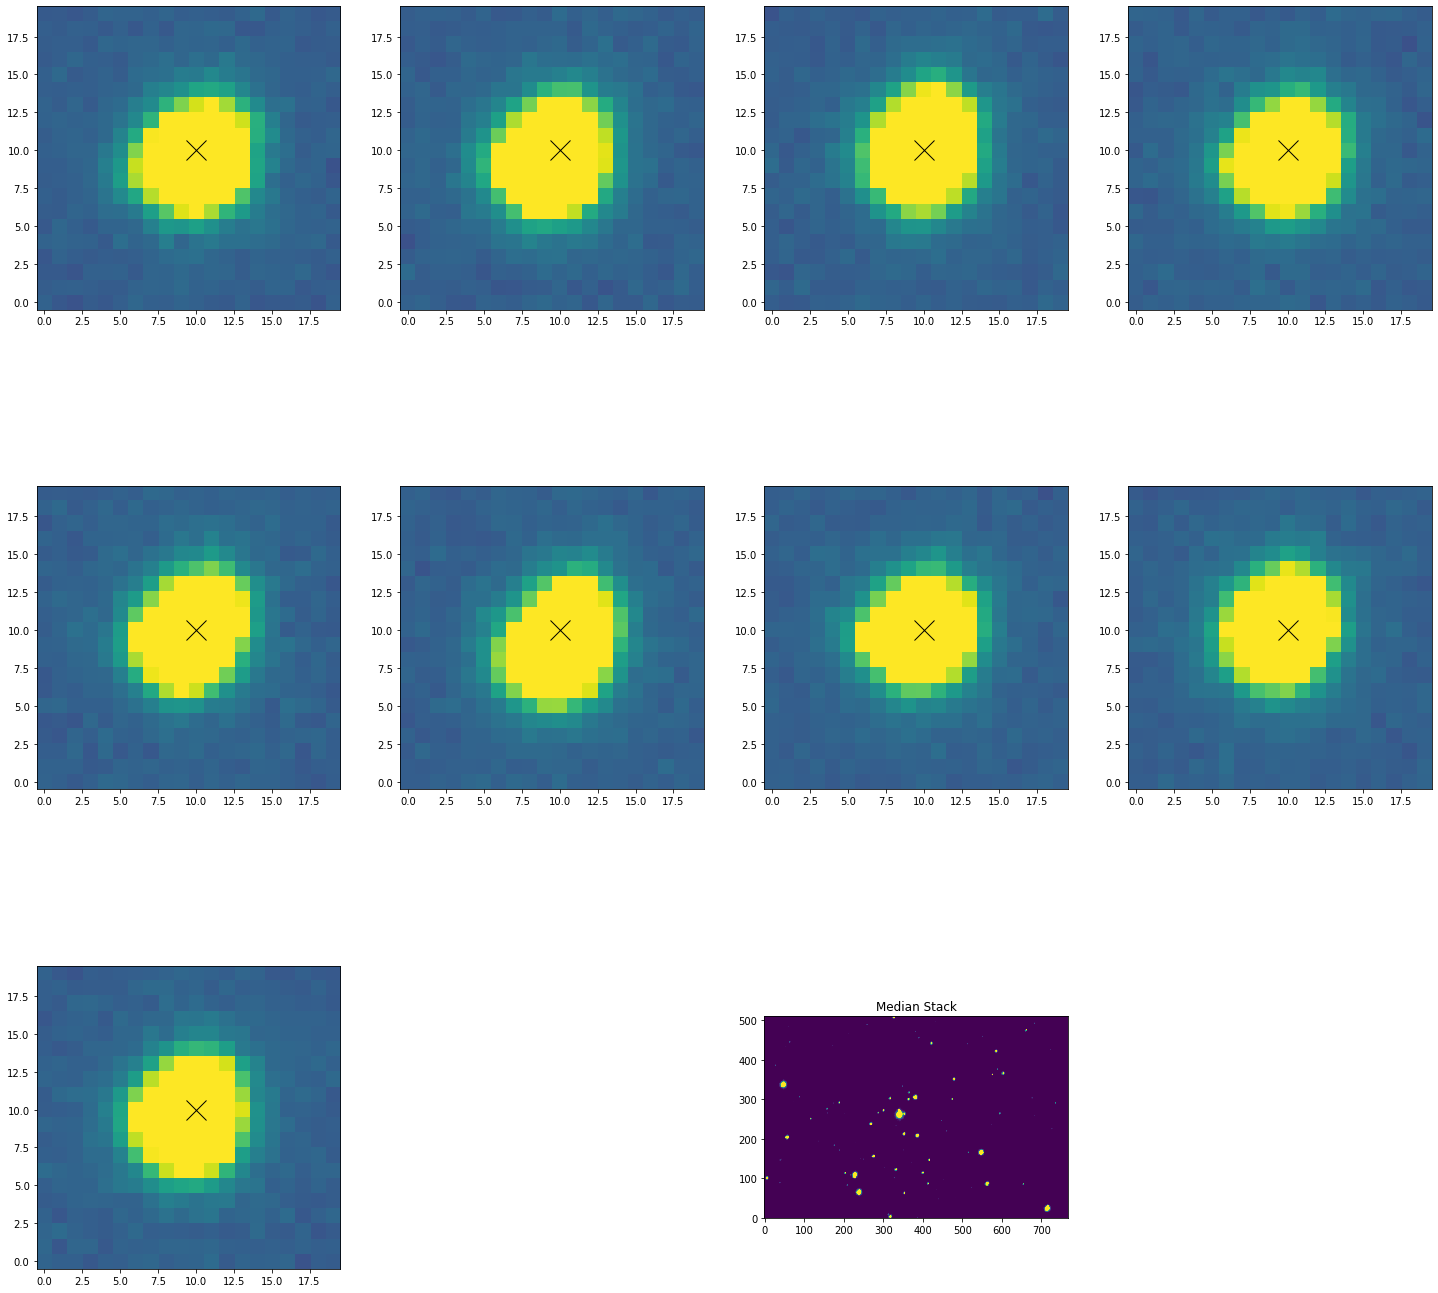

In [25]:
centralV1 = np.roll(np.roll(central_V[0], 0, axis=1), 0, axis=0)
centralV2 = np.roll(np.roll(central_V[1], 0, axis=1), -2, axis=0)
centralV3 = np.roll(np.roll(central_V[2], -1, axis=1), -2, axis=0)
centralV4 = np.roll(np.roll(central_V[3], -1, axis=1), 0, axis=0)
centralV5 = np.roll(np.roll(central_V[4], -1, axis=1), 1, axis=0)
centralV6 = np.roll(np.roll(central_V[5], 0, axis=1), 4, axis=0)
#centralV7 = np.roll(np.roll(central_V[6], 0, axis=1), 4, axis=0)
centralV8 = np.roll(np.roll(central_V[7], -1, axis=1), 0, axis=0)
centralV9 = np.roll(np.roll(central_V[8], -1, axis=1), 1, axis=0)
centralV0 = np.roll(np.roll(central_V[9], -1, axis=1), 1, axis=0)
central_V2 = [centralV1, centralV2, centralV3, centralV4, centralV5, centralV6, centralV8, centralV9, centralV0]
central_V1 = centroider(central_V2, 194,214,48,68,9)
centralV = np.median(central_V1, axis=0) - np.median(np.median(central_V1, axis=0))

plt.figure(figsize=(25,25))

for ii in range(9):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(central_V1[ii][194:214,48:68], origin='lower', vmax=1000, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(centralV, origin='lower', vmax=600, vmin=50)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

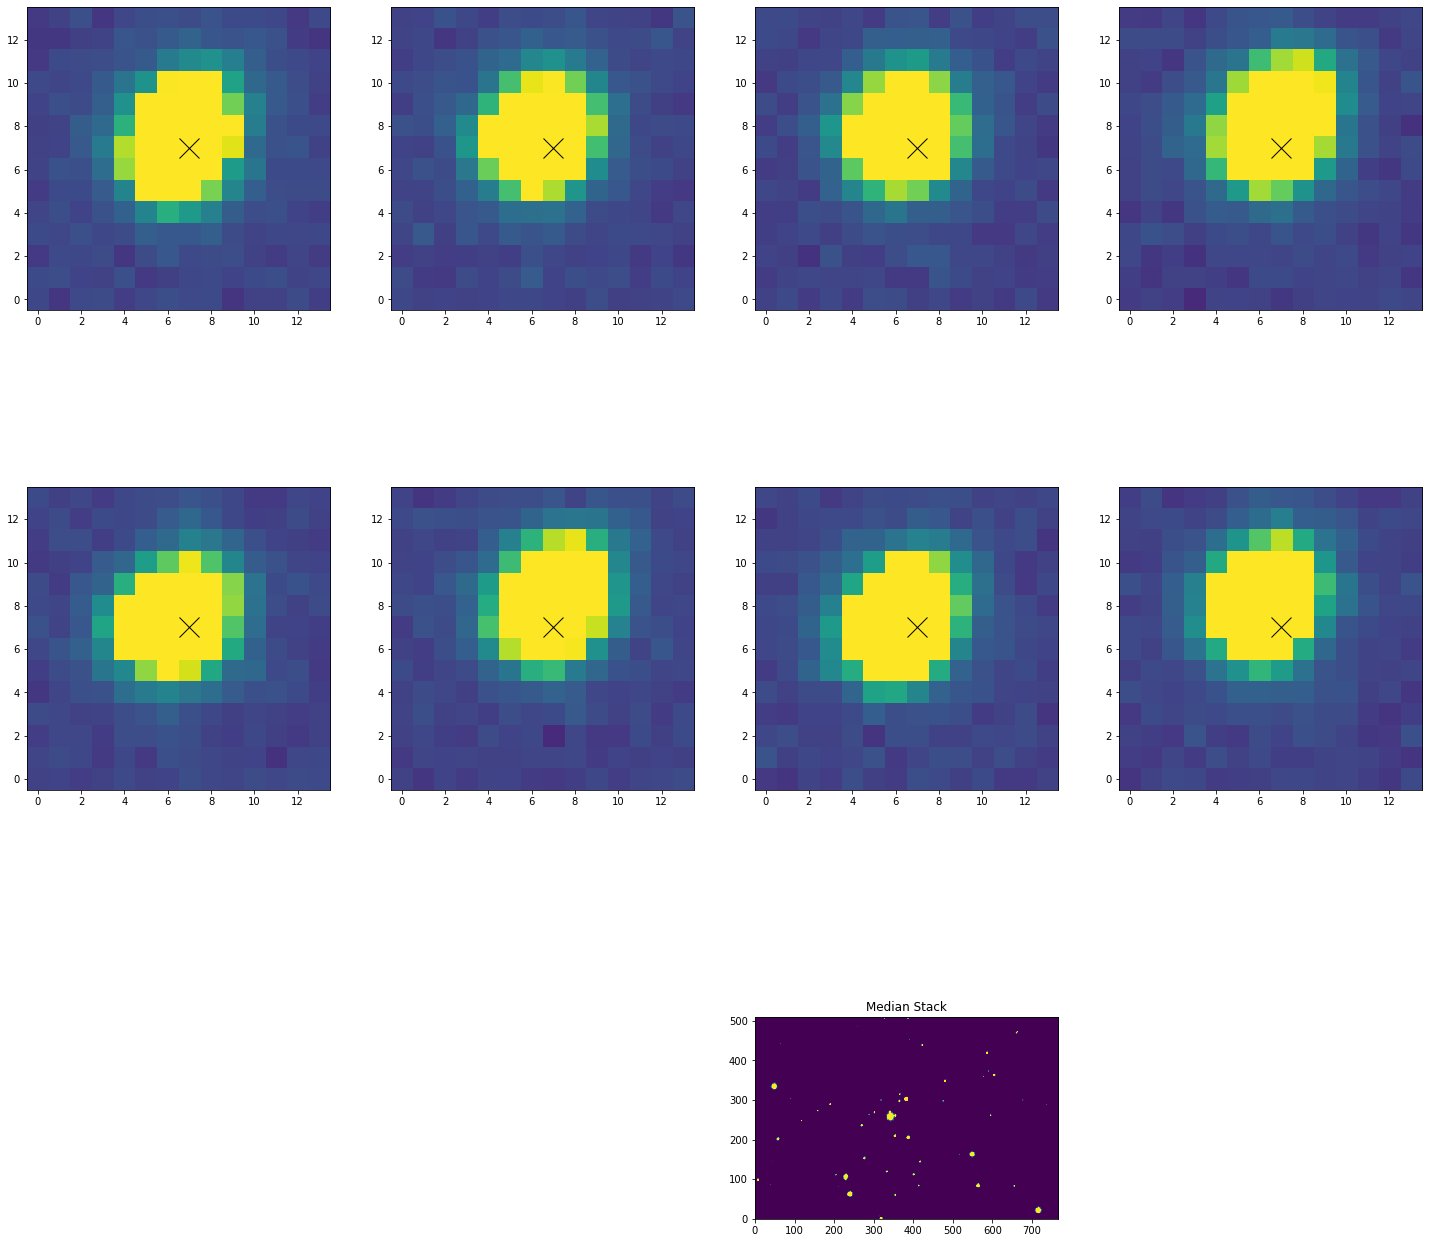

In [26]:
centralB1 = np.roll(np.roll(central_B[0], 0, axis=1), 0, axis=0)
centralB2 = np.roll(np.roll(central_B[1], 0, axis=1), 1, axis=0)
#centralB3 = np.roll(np.roll(central_B[2], 0, axis=1), -4, axis=0)
#centralB4 = np.roll(np.roll(central_B[3], 0, axis=1), -11, axis=0)
centralB5 = np.roll(np.roll(central_B[4], -1, axis=1), -15, axis=0)
centralB6 = np.roll(np.roll(central_B[5], 0, axis=1), -12, axis=0)
centralB7 = np.roll(np.roll(central_B[6], 1, axis=1), -10, axis=0)
centralB8 = np.roll(np.roll(central_B[7], 1, axis=1), -9, axis=0)
centralB9 = np.roll(np.roll(central_B[8], 2, axis=1), -7, axis=0)
centralB0 = np.roll(np.roll(central_B[9], 2, axis=1), -8, axis=0)
central_B2 = [centralB1, centralB2, centralB5, centralB6, centralB7, centralB8, centralB9, centralB0]
central_B1 = centroider(central_B2, 194,208,51,65,8)
centralB = np.median(central_B1, axis=0) - np.median(np.median(central_B1, axis=0))

plt.figure(figsize=(25,25))

for ii in range(8):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(central_B1[ii][194:208,51:65], origin='lower', vmax=600, vmin=0)
    ax.plot(7, 7, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(centralB, origin='lower', vmax=200, vmin=50)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

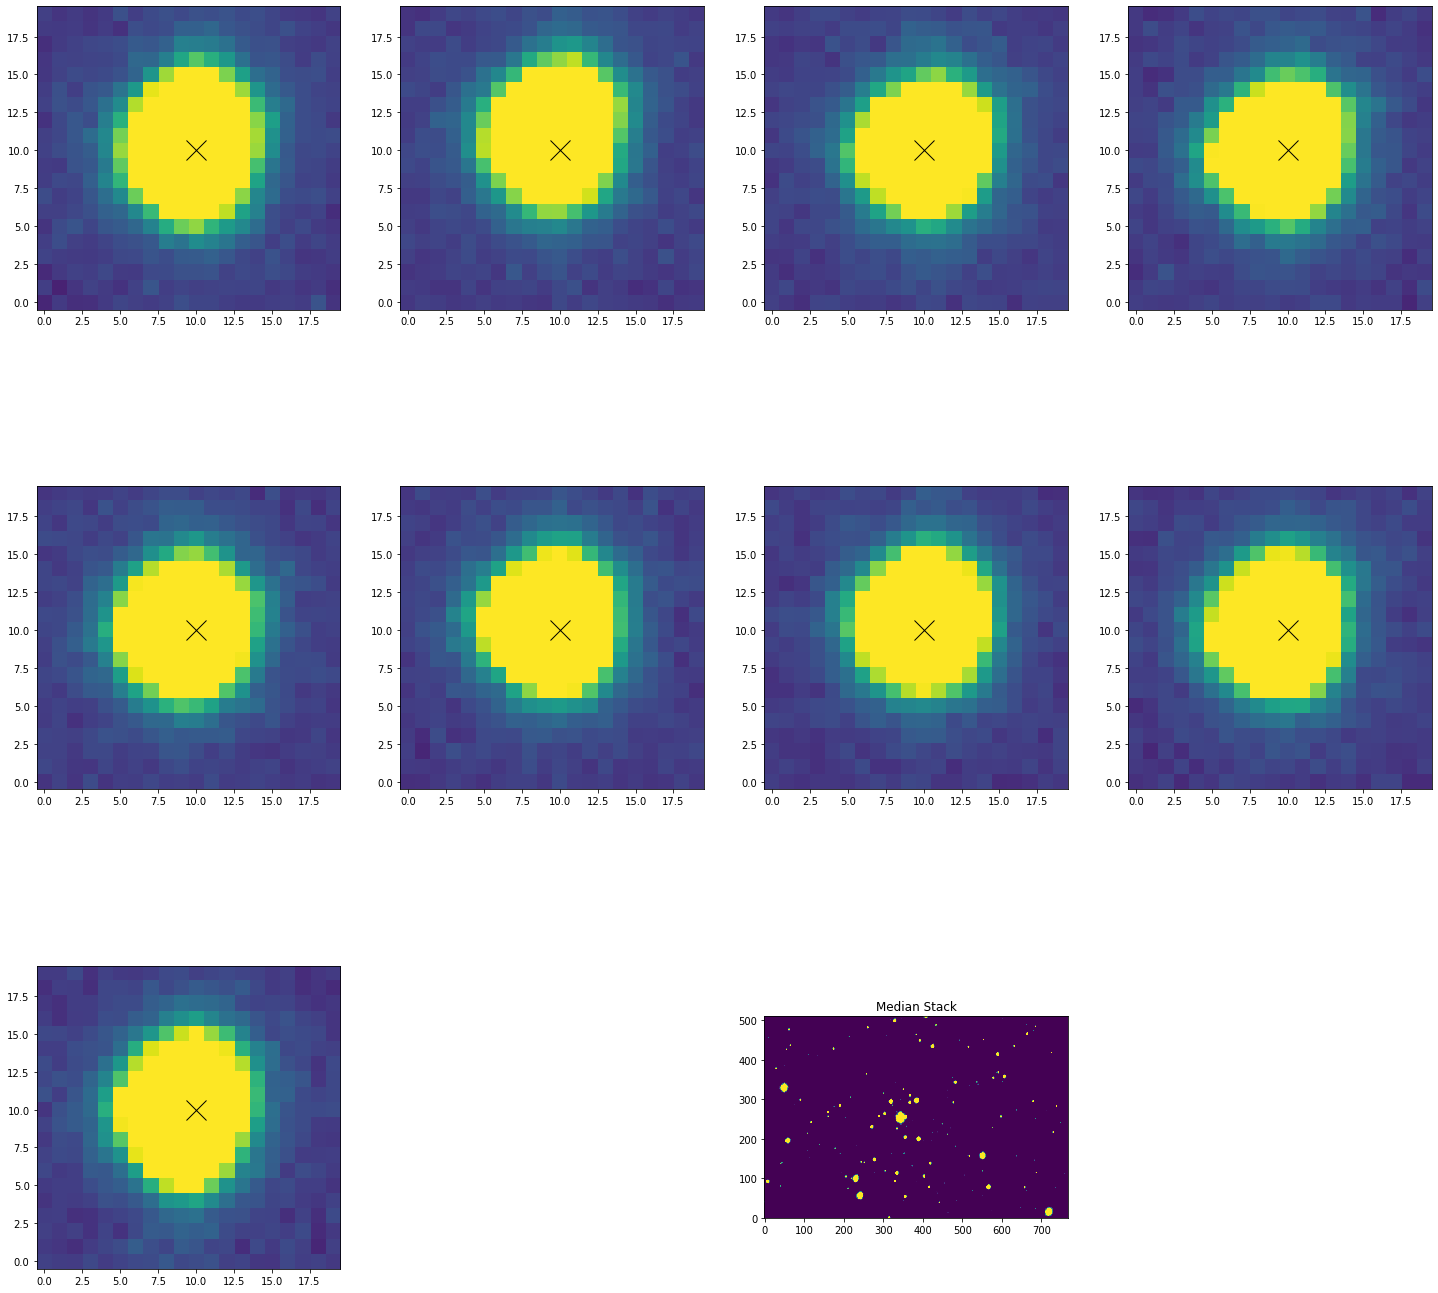

In [27]:
centralI1 = np.roll(np.roll(central_I[0], 0, axis=1), 4, axis=0)
centralI2 = np.roll(np.roll(central_I[1], 0, axis=1), 0, axis=0)
centralI3 = np.roll(np.roll(central_I[2], 1, axis=1), 1, axis=0)
centralI4 = np.roll(np.roll(central_I[3], 1, axis=1), 1, axis=0)
centralI5 = np.roll(np.roll(central_I[4], 2, axis=1), 1, axis=0)
centralI6 = np.roll(np.roll(central_I[5], 2, axis=1), 1, axis=0)
centralI7 = np.roll(np.roll(central_I[6], 3, axis=1), 0, axis=0)
centralI8 = np.roll(np.roll(central_I[7], 4, axis=1), 2, axis=0)
#centralI9 = np.roll(np.roll(central_I[8], 3, axis=1), -3, axis=0)
centralI0 = np.roll(np.roll(central_I[9], 3, axis=1), -10, axis=0)
central_I2 = [centralI1, centralI2, centralI3, centralI4, centralI5, centralI6, centralI7, centralI8, centralI0]
central_I1 = centroider(central_I2, 185, 205, 50, 70,9)
centralI = np.median(central_I1, axis=0) - np.median(np.median(central_I1, axis=0))

plt.figure(figsize=(25,25))

for ii in range(9):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(central_I1[ii][185:205,50:70], origin='lower', vmax=600, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(centralI, origin='lower', vmax=150, vmin=50)

ax.set_title("Median Stack")

(59, 194)

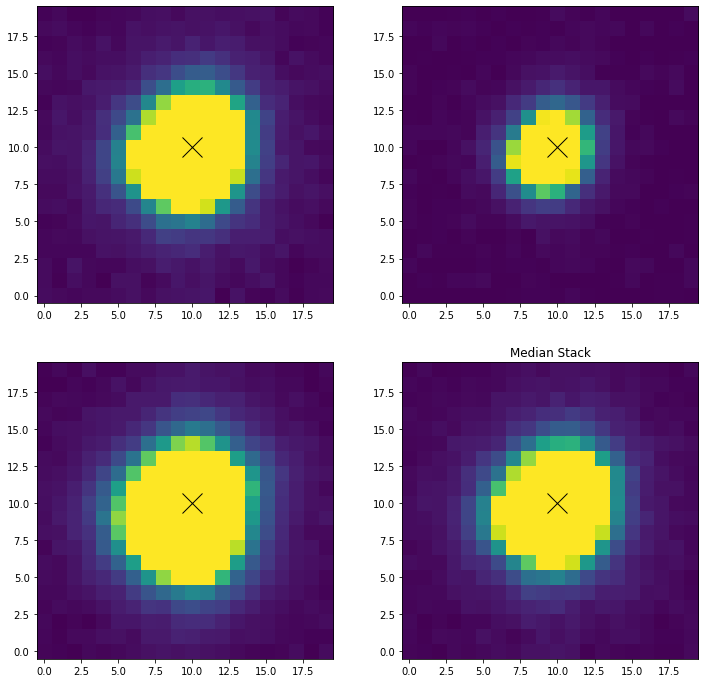

In [28]:
centralV_Aligned1 = np.roll(np.roll(centralV, 2, axis=1), -9, axis=0)
centralB_Aligned1 = np.roll(np.roll(centralB, 2, axis=1), -6, axis=0)
centralI_Aligned1 = np.roll(np.roll(centralI, 0, axis=1), 0, axis=0)
cutout4 = centralV_Aligned1[185:205,50:70]
cutout5 = centralB_Aligned1[185:205,50:70]
cutout6 = centralI_Aligned1[185:205,50:70]
y2, x2 = np.indices([20,20])
xcent4 = int((x2*cutout4).sum()/cutout4.sum() + 50)
ycent4 = int((y2*cutout4).sum()/cutout4.sum() + 185)
xcent5 = int((x2*cutout5).sum()/cutout5.sum() + 50)
ycent5 = int((y2*cutout5).sum()/cutout5.sum() + 185)
xcent6 = int((x2*cutout6).sum()/cutout6.sum() + 50)
ycent6 = int((y2*cutout6).sum()/cutout6.sum() + 185)
centralV_Aligned = np.roll(np.roll(centralV_Aligned1, xcent4 - xcent4, axis=1), ycent4 - ycent4, axis=0)
centralB_Aligned = np.roll(np.roll(centralB_Aligned1, xcent4 - xcent5, axis=1), ycent4 - ycent5, axis=0)
centralI_Aligned = np.roll(np.roll(centralI_Aligned1, xcent4 - xcent6, axis=1), ycent4 - ycent6, axis=0)
central_3 = [centralV_Aligned, centralB_Aligned, centralI_Aligned]
central_check = np.median(central_3, axis=0)

header = fits.getheader(glob.glob("central_25s_V*FIT")[0])
data = centralV_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('central_V_Final.FIT', overwrite=True)

header = fits.getheader(glob.glob("central_25s_B*FIT")[0])
data = centralB_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('central_B_Final.FIT', overwrite=True)

header = fits.getheader(glob.glob("central_25s_I*FIT")[0])
data = centralI_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('central_I_Final.FIT', overwrite=True)

plt.figure(figsize=(12,12))

for ii in range(3):
    ax = plt.subplot(2,2,ii+1)
    ax.imshow(central_3[ii][185:205,50:70], origin='lower', vmax=600, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(2,2,4)
ax.imshow(central_check[185:205,50:70], origin='lower', vmax=600, vmin=0)
ax.plot(10, 10, 'kx', markersize=20)

ax.set_title("Median Stack")
xcent4, ycent4

## LB Alignments

Text(0.5, 1.0, 'Median Stack')

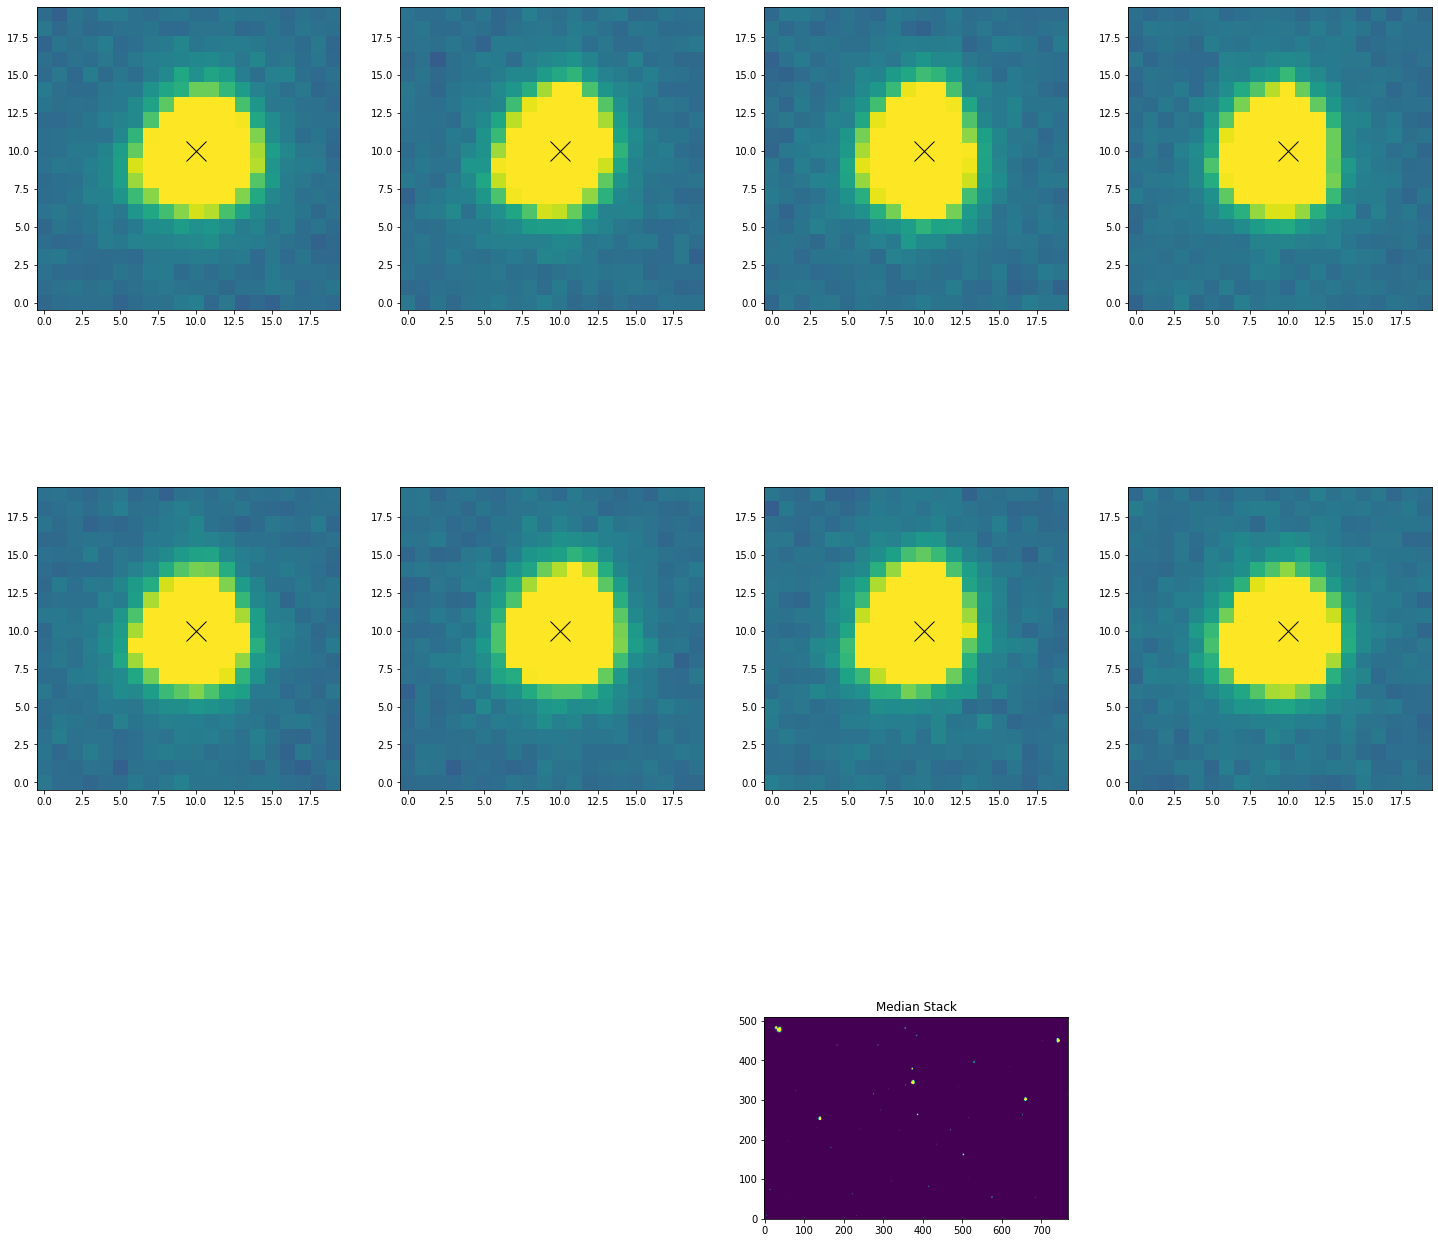

In [29]:
LBV1 = np.roll(np.roll(LB_V[0], 0, axis=1), 0, axis=0)
#LBV2 = np.roll(np.roll(LB_V[1], -1, axis=1), -3, axis=0)
#LBV3 = np.roll(np.roll(LB_V[2], -3, axis=1), -10, axis=0)
LBV4 = np.roll(np.roll(LB_V[3], -5, axis=1), -16, axis=0)
LBV5 = np.roll(np.roll(LB_V[4], -6, axis=1), -16, axis=0)
LBV6 = np.roll(np.roll(LB_V[5], -6, axis=1), -14, axis=0)
LBV7 = np.roll(np.roll(LB_V[6], -7, axis=1), -12, axis=0)
LBV8 = np.roll(np.roll(LB_V[7], -7, axis=1), -11, axis=0)
LBV9 = np.roll(np.roll(LB_V[8], -9, axis=1), -12, axis=0)
LBV0 = np.roll(np.roll(LB_V[9], -10, axis=1), -14, axis=0)
LB_V2 = [LBV1, LBV4, LBV5, LBV6, LBV7, LBV8, LBV9, LBV0]
LB_V1 = centroider(LB_V2, 244, 264, 131, 151,8)
LBV = np.median(LB_V1, axis=0) - np.median(np.median(LB_V1, axis=0))

plt.figure(figsize=(25,25))

for ii in range(8):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(LB_V1[ii][244:264,131:151], origin='lower', vmax=800, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(LBV, origin='lower', vmax=800, vmin=50)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

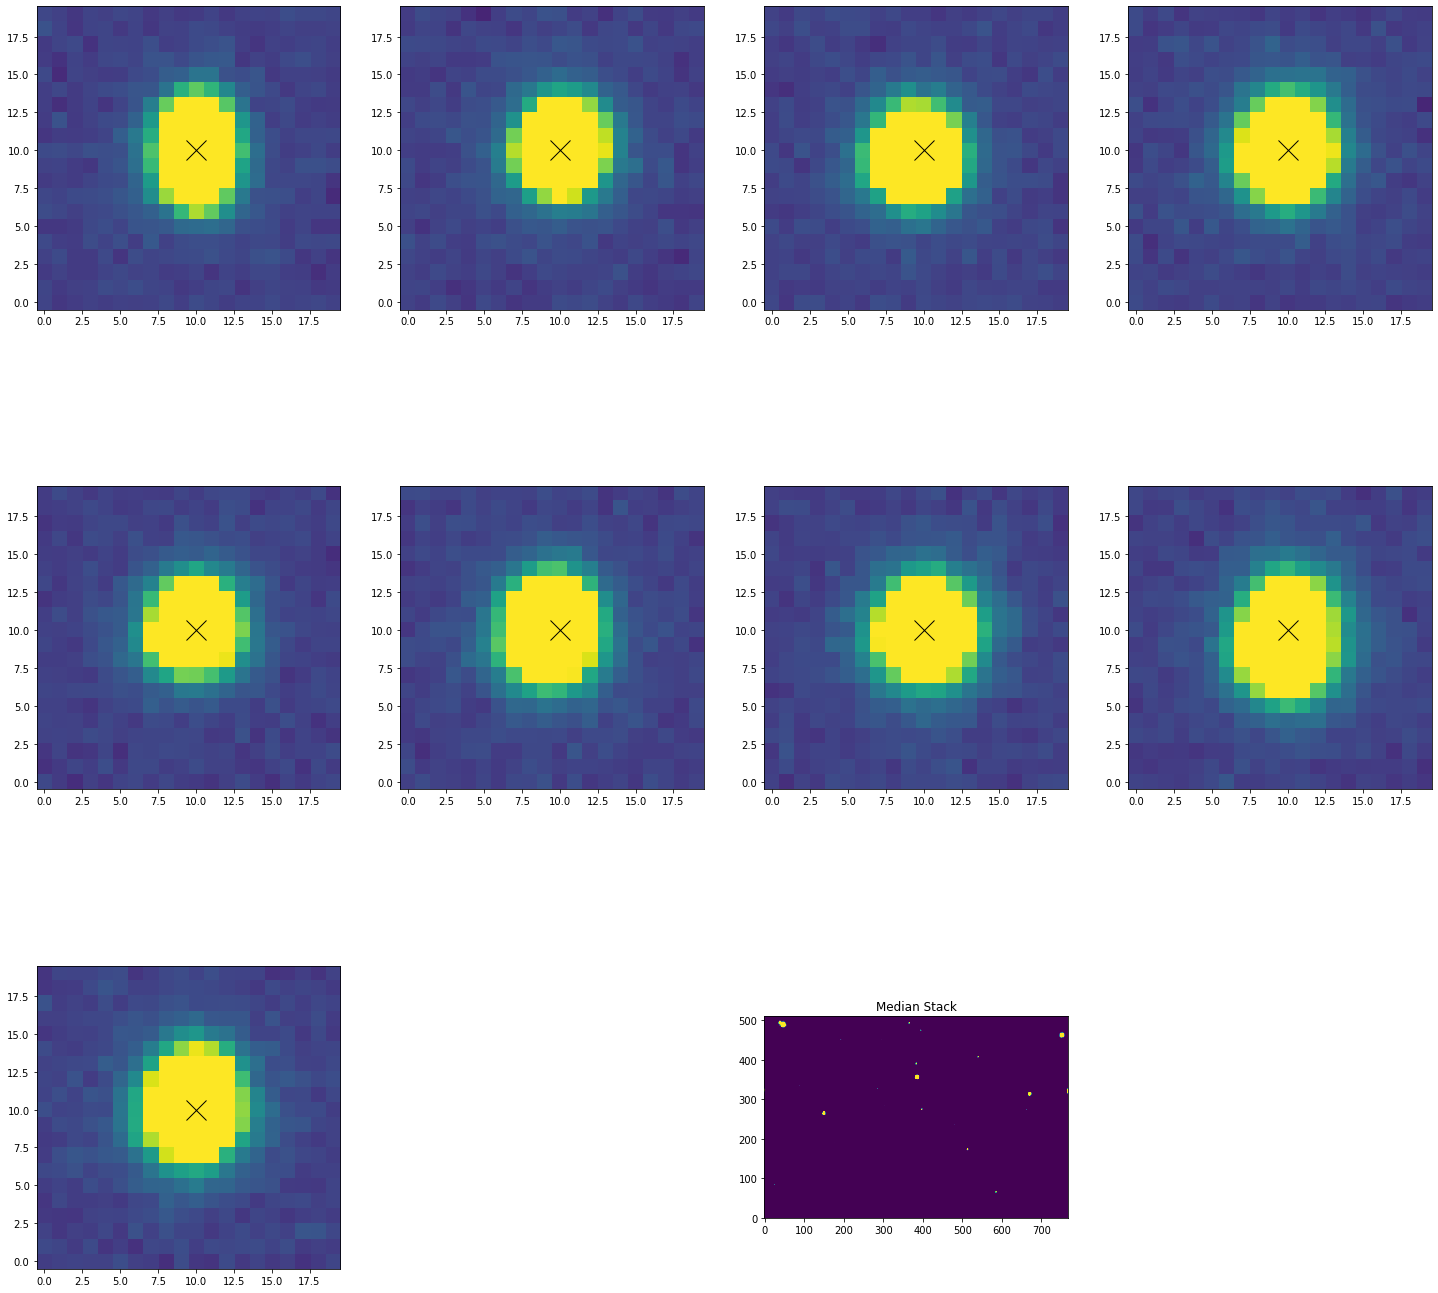

In [30]:
LBB1 = np.roll(np.roll(LB_B[0], 0, axis=1), 0, axis=0)
LBB2 = np.roll(np.roll(LB_B[1], 0, axis=1), 3, axis=0)
LBB3 = np.roll(np.roll(LB_B[2], -1, axis=1), 2, axis=0)
LBB4 = np.roll(np.roll(LB_B[3], -1, axis=1), 1, axis=0)
LBB5 = np.roll(np.roll(LB_B[4], -2, axis=1), 0, axis=0)
LBB6 = np.roll(np.roll(LB_B[5], -3, axis=1), 1, axis=0)
LBB7 = np.roll(np.roll(LB_B[6], -3, axis=1), -2, axis=0)
LBB8 = np.roll(np.roll(LB_B[7], -4, axis=1), 0, axis=0)
LBB9 = np.roll(np.roll(LB_B[8], -4, axis=1), 5, axis=0)
#LBB0 = np.roll(np.roll(LB_B[9], -5, axis=1), 1, axis=0)
LB_B2 = [LBB1, LBB2, LBB3, LBB4, LBB5, LBB6, LBB7, LBB8, LBB9]
LB_B1 = centroider(LB_B2, 254,274,141,161,9)
LBB = np.median(LB_B1, axis=0) - np.median(np.median(LB_B1, axis=0))

plt.figure(figsize=(25,25))

for ii in range(9):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(LB_B1[ii][254:274,141:161], origin='lower', vmax=600, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(LBB, origin='lower', vmax=200, vmin=50)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

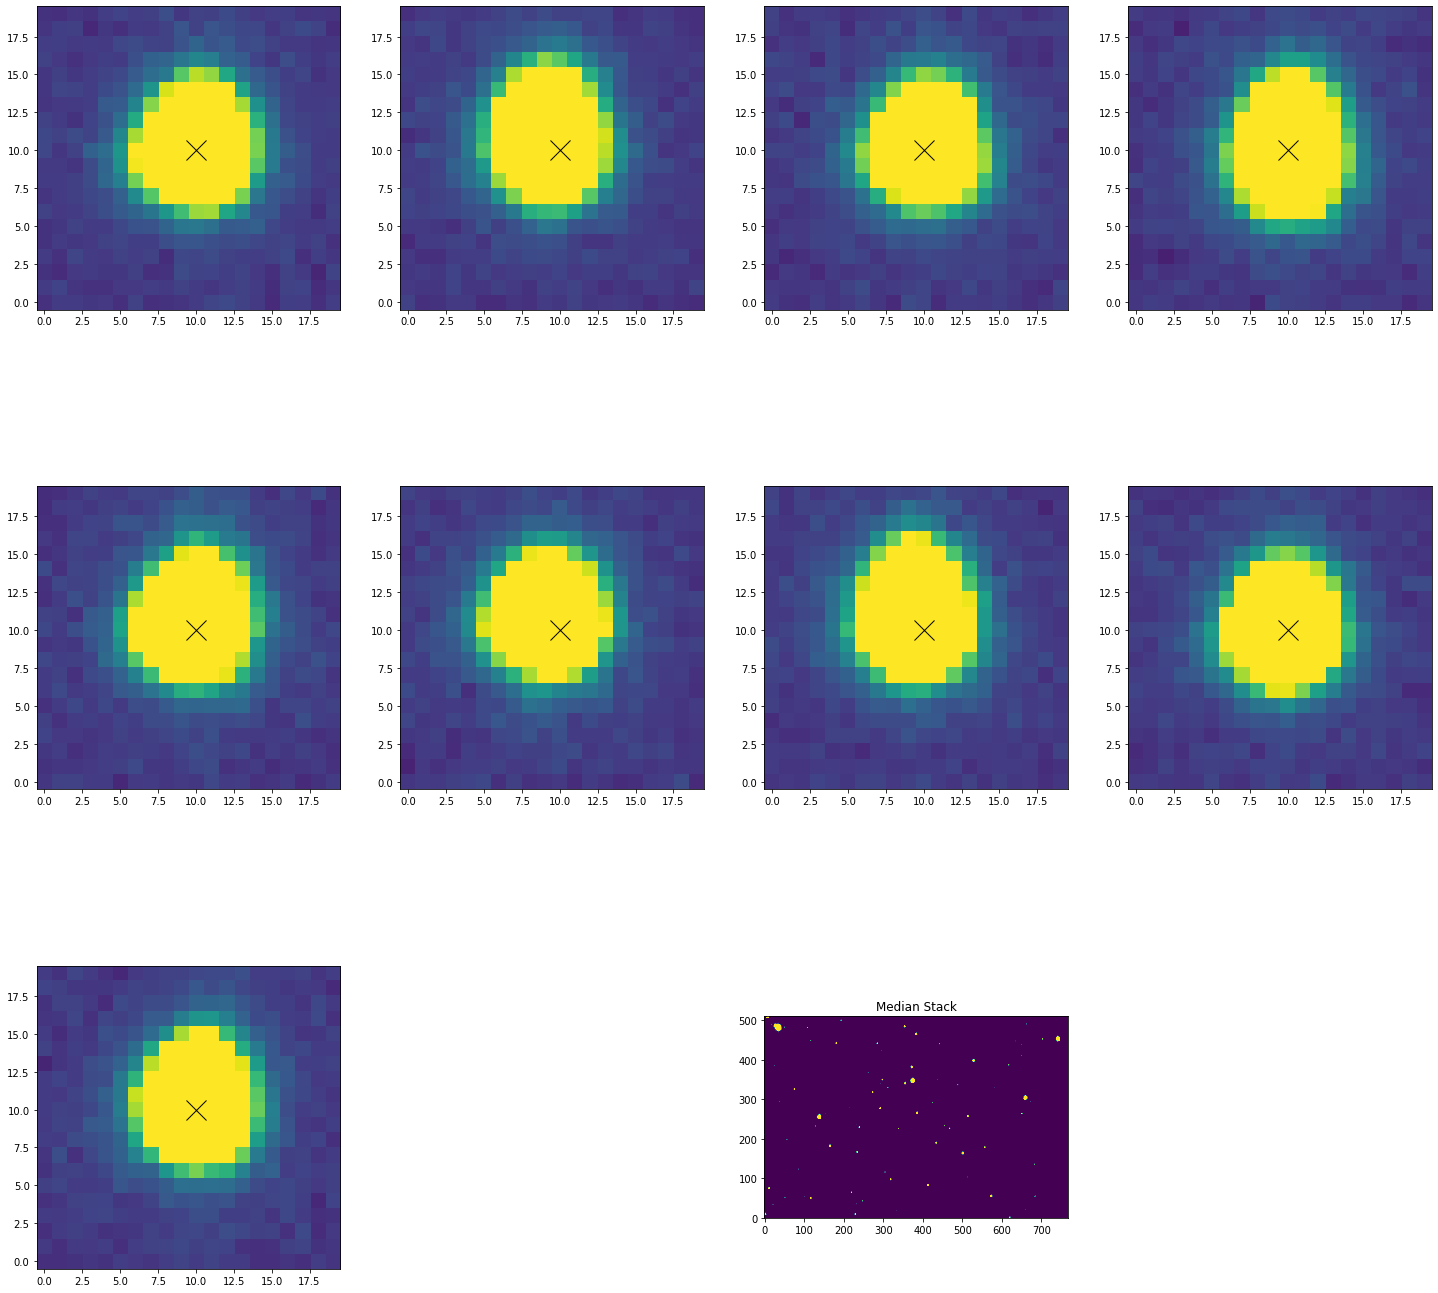

In [31]:
LBI1 = np.roll(np.roll(LB_I[0], 0, axis=1), -5, axis=0)
LBI2 = np.roll(np.roll(LB_I[1], 0, axis=1), -4, axis=0)
LBI3 = np.roll(np.roll(LB_I[2], 0, axis=1), -2, axis=0)
LBI4 = np.roll(np.roll(LB_I[3], 0, axis=1), 0, axis=0)
LBI5 = np.roll(np.roll(LB_I[4], 0, axis=1), 3, axis=0)
#LBI6 = np.roll(np.roll(LB_I[5], -1, axis=1), 0, axis=0)
LBI7 = np.roll(np.roll(LB_I[6], -2, axis=1), -2, axis=0)
LBI8 = np.roll(np.roll(LB_I[7], -2, axis=1), -1, axis=0)
LBI9 = np.roll(np.roll(LB_I[8], -2, axis=1), -1, axis=0)
LBI0 = np.roll(np.roll(LB_I[9], -2, axis=1), -2, axis=0)
LB_I2 = [LBI1, LBI2, LBI3, LBI4, LBI5, LBI7, LBI8, LBI9, LBI0]
LB_I1 = centroider(LB_I2, 245,265,129,149,9)
LBI = np.median(LB_I1, axis=0) - np.median(np.median(LB_I1, axis=0))

plt.figure(figsize=(25,25))

for ii in range(9):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(LB_I1[ii][245:265,129:149], origin='lower', vmax=600, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(LBI, origin='lower', vmax=150, vmin=50)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

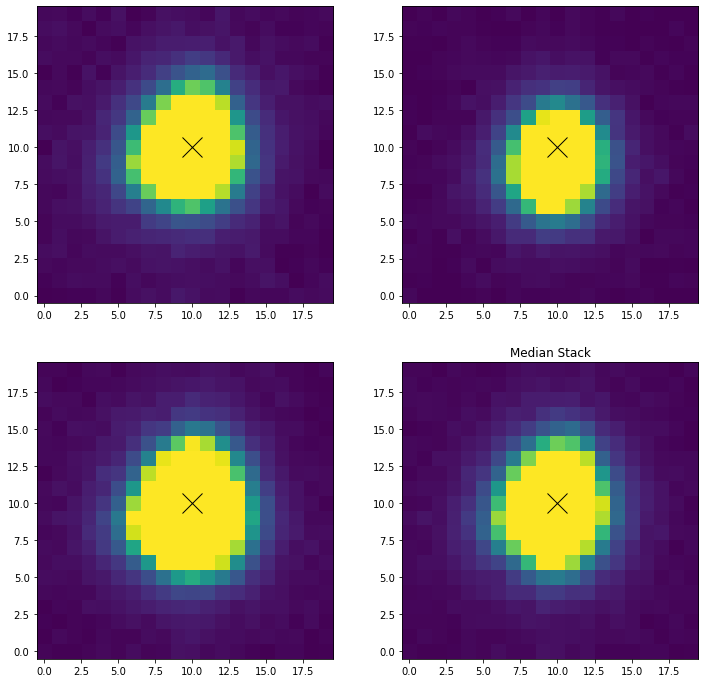

In [32]:
LBV_Aligned1 = np.roll(np.roll(LBV, -2, axis=1), 1, axis=0)
LBB_Aligned1 = np.roll(np.roll(LBB, -12, axis=1), -9, axis=0)
LBI_Aligned1 = np.roll(np.roll(LBI, 0, axis=1), 0, axis=0)
cutout7 = LBV_Aligned1[245:265,129:149]
cutout8 = LBB_Aligned1[245:265,129:149]
cutout9 = LBI_Aligned1[245:265,129:149]
y3, x3 = np.indices([20,20])
xcent7 = int((x3*cutout7).sum()/cutout7.sum() + 129)
ycent7 = int((y3*cutout7).sum()/cutout7.sum() + 245)
xcent8 = int((x3*cutout8).sum()/cutout8.sum() + 129)
ycent8 = int((y3*cutout8).sum()/cutout8.sum() + 245)
xcent9 = int((x3*cutout9).sum()/cutout9.sum() + 129)
ycent9 = int((y3*cutout9).sum()/cutout9.sum() + 245)
LBV_Aligned = np.roll(np.roll(LBV_Aligned1, xcent7 - xcent7, axis=1), ycent7 - ycent7, axis=0)
LBB_Aligned = np.roll(np.roll(LBB_Aligned1, xcent7 - xcent8, axis=1), ycent7 - ycent8, axis=0)
LBI_Aligned = np.roll(np.roll(LBI_Aligned1, xcent7 - xcent9, axis=1), ycent7 - ycent9, axis=0)
LB_3 = [LBV_Aligned, LBB_Aligned, LBI_Aligned]
LB_check = np.median(LB_3, axis=0)

header = fits.getheader(glob.glob("LB_25s_V*FIT")[0])
data = LBV_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('LB_V_Final.FIT', overwrite=True)

header = fits.getheader(glob.glob("LB_25s_B*FIT")[0])
data = LBB_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('LB_B_Final.FIT', overwrite=True)

header = fits.getheader(glob.glob("LB_25s_I*FIT")[0])
data = LBI_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('LB_I_Final.FIT', overwrite=True)

plt.figure(figsize=(12,12))

for ii in range(3):
    ax = plt.subplot(2,2,ii+1)
    ax.imshow(LB_3[ii][245:265,129:149], origin='lower', vmax=600, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(2,2,4)
ax.imshow(LB_check[245:265,129:149], origin='lower', vmax=600, vmin=0)
ax.plot(10, 10, 'kx', markersize=20)

ax.set_title("Median Stack")

# LC Alignment

Text(0.5, 1.0, 'Median Stack')

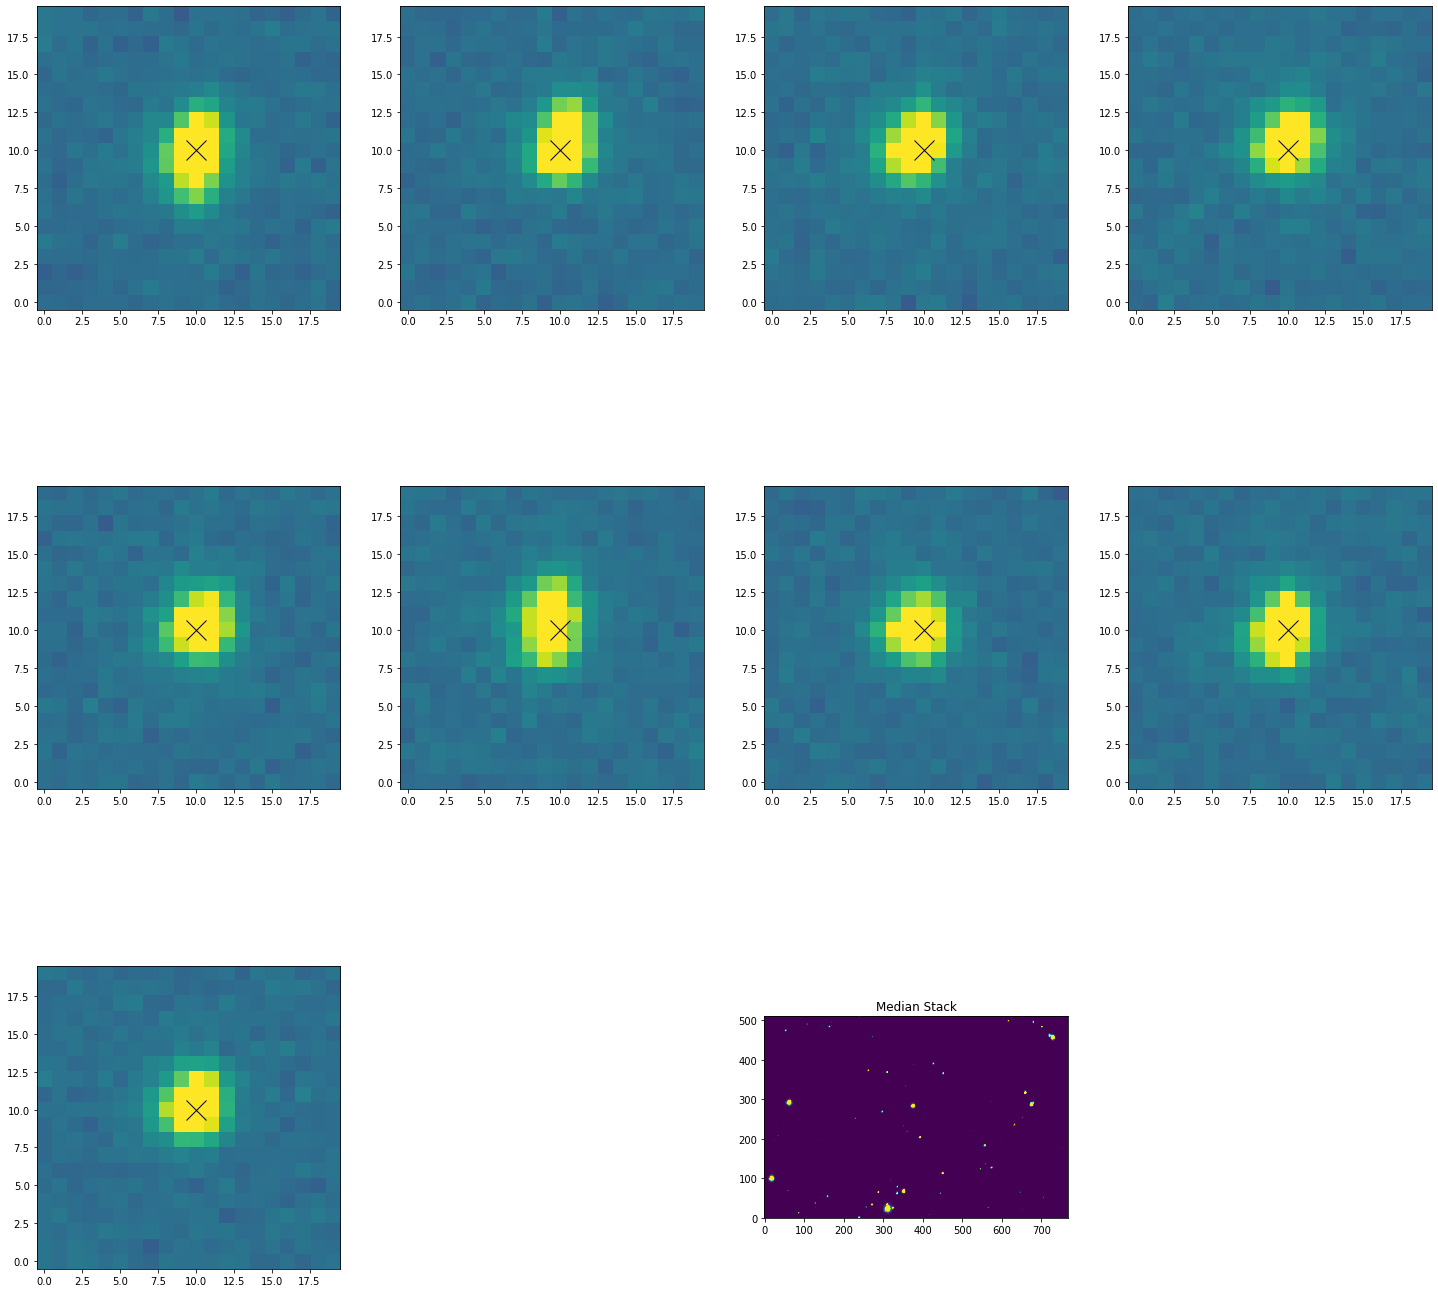

In [33]:
LCV1 = np.roll(np.roll(LC_V[0], 4, axis=1), 5, axis=0)
LCV2 = np.roll(np.roll(LC_V[1], 4, axis=1), 8, axis=0)
#LCV3 = np.roll(np.roll(LC_V[2], 2, axis=1), 1, axis=0)
#picture came out bad again
LCV4 = np.roll(np.roll(LC_V[3], 1, axis=1), -4, axis=0)
LCV5 = np.roll(np.roll(LC_V[4], 1, axis=1), -6, axis=0)
LCV6 = np.roll(np.roll(LC_V[5], 1, axis=1), -7, axis=0)
LCV7 = np.roll(np.roll(LC_V[6], 0, axis=1), -5, axis=0)
LCV8 = np.roll(np.roll(LC_V[7], 0, axis=1), -3, axis=0)
LCV9 = np.roll(np.roll(LC_V[8], 0, axis=1), -2, axis=0)
LCV0 = np.roll(np.roll(LC_V[9], 0, axis=1), 0, axis=0)
LC_V2 = [LCV1, LCV2, LCV4, LCV5, LCV6, LCV7, LCV8, LCV9, LCV0]
LC_V1 = centroider(LC_V2, 44,64,150,170, e=9)
LCV = np.median(LC_V1, axis=0) - np.median(np.median(LC_V1, axis=0))
plt.figure(figsize=(25,25))

for ii in range(9):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(LC_V1[ii][44:64,150:170], origin='lower', vmax=800, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(LCV, origin='lower', vmax=800, vmin=50)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

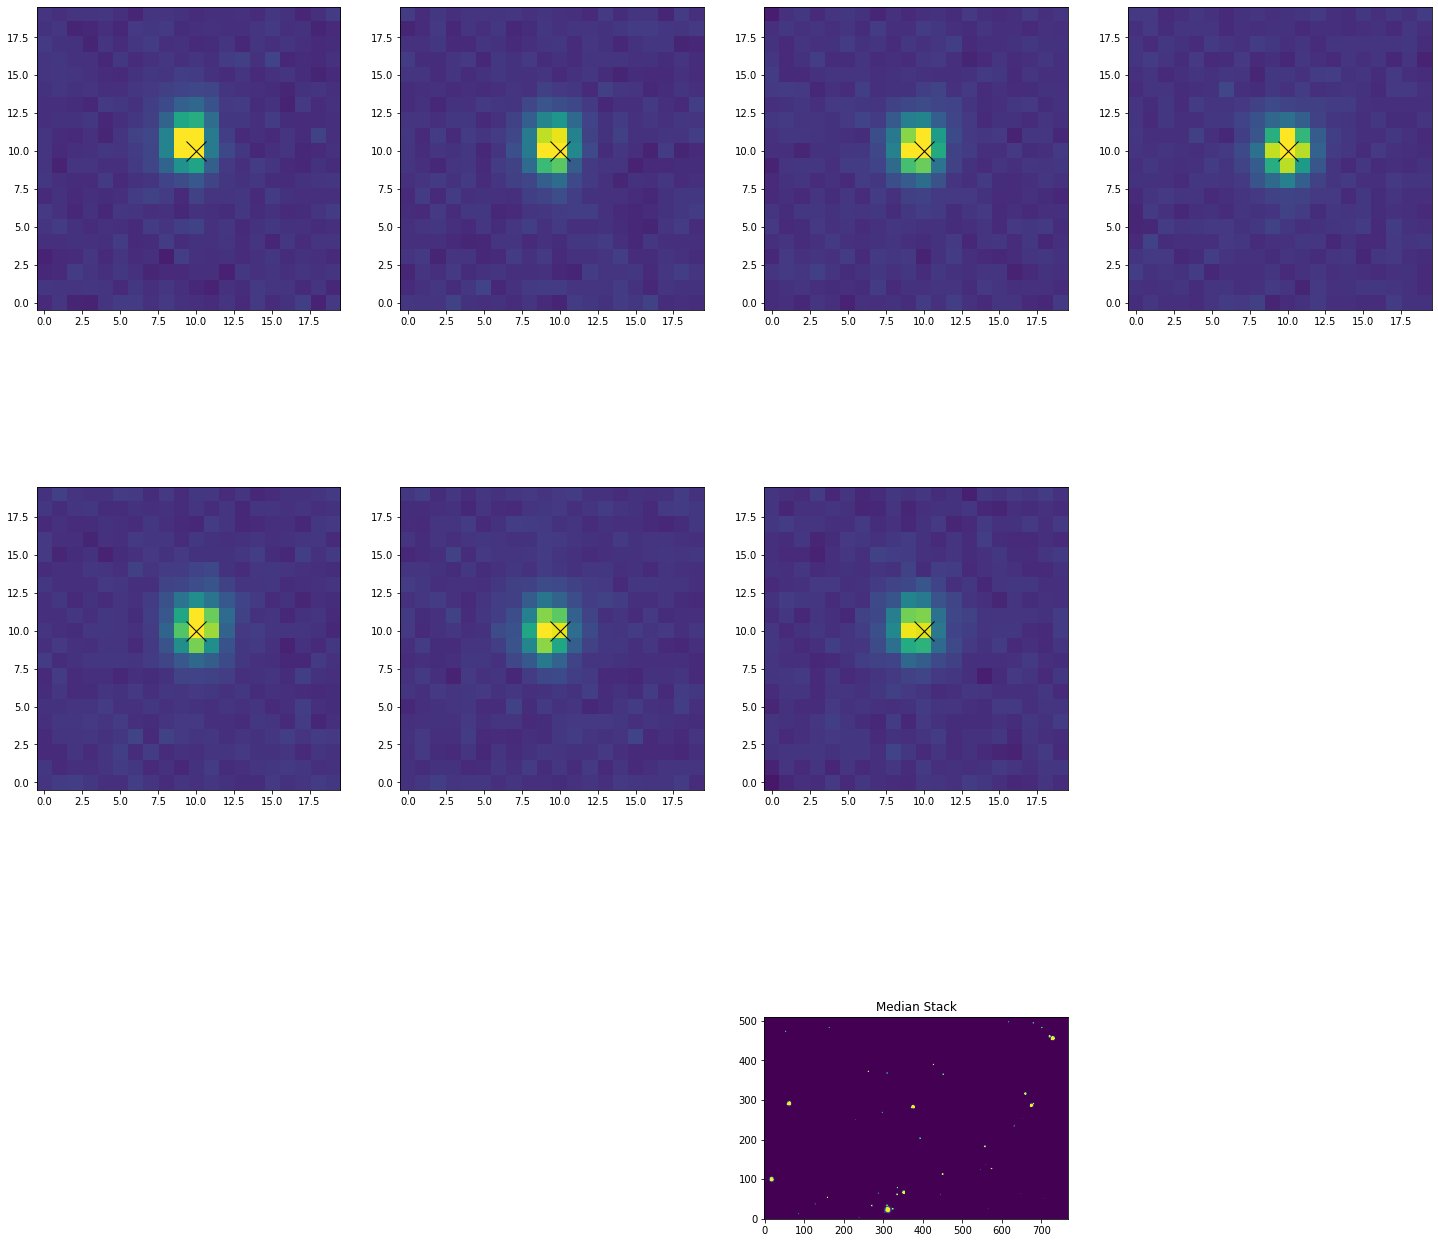

In [34]:
#LCB1 = np.roll(np.roll(LC_B[0], 0, axis=1), 0, axis=0)
LCB2 = np.roll(np.roll(LC_B[1], 0, axis=1), 5, axis=0)
#LCB3 = np.roll(np.roll(LC_B[2], 0, axis=1), 2, axis=0)
LCB4 = np.roll(np.roll(LC_B[3], -1, axis=1), 1, axis=0)
LCB5 = np.roll(np.roll(LC_B[4], -1, axis=1), 2, axis=0)
LCB6 = np.roll(np.roll(LC_B[5], -1, axis=1), 2, axis=0)
LCB7 = np.roll(np.roll(LC_B[6], -1, axis=1), 2, axis=0)
LCB8 = np.roll(np.roll(LC_B[7], -2, axis=1), 2, axis=0)
LCB9 = np.roll(np.roll(LC_B[8], -2, axis=1), 2, axis=0)
#LCB0 = np.roll(np.roll(LC_B[9], -2, axis=1), 2, axis=0)
#bad data
LC_B2 = [LCB2, LCB4, LCB5, LCB6, LCB7, LCB8, LCB9]
LC_B1 = centroider(LC_B2, 44,64,150,170, e=7)
LCB = np.median(LC_B1, axis=0) - np.median(np.median(LC_B1, axis=0))

plt.figure(figsize=(25,25))

for ii in range(7):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(LC_B1[ii][44:64,150:170], origin='lower', vmax=800, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(LCB, origin='lower', vmax=800, vmin=50)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

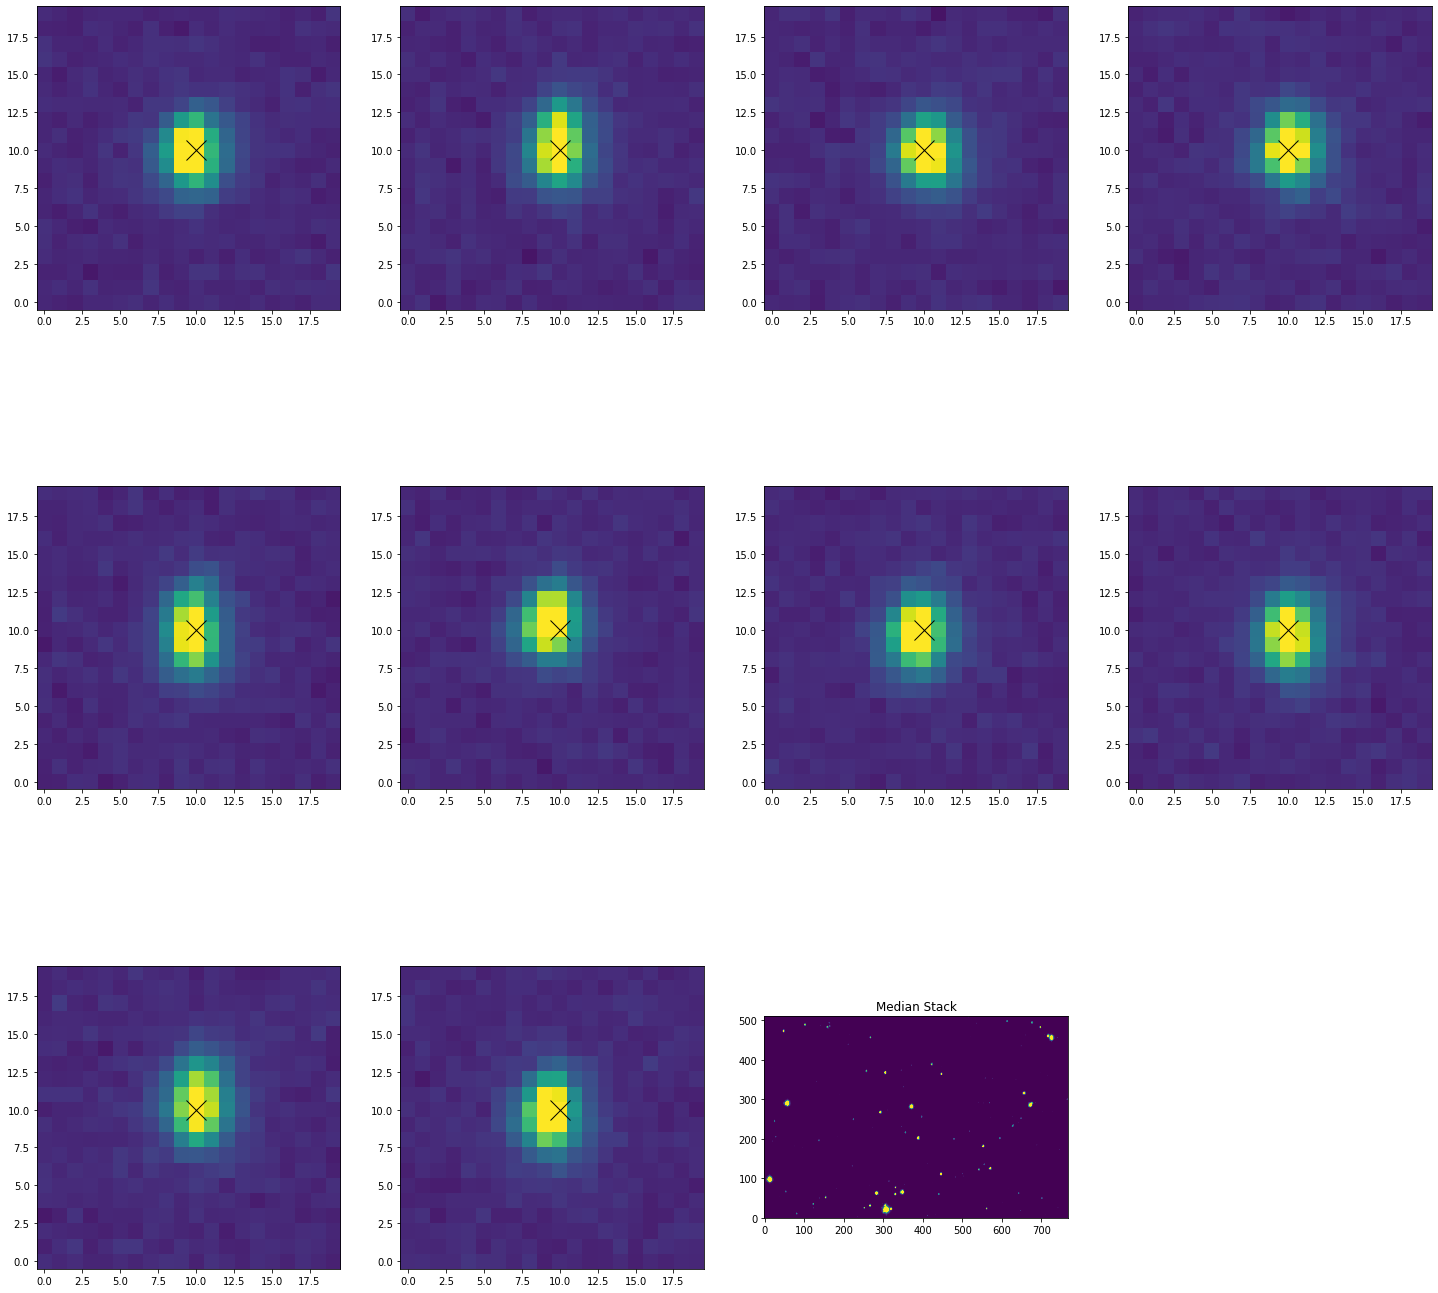

In [35]:
LCI1 = np.roll(np.roll(LC_I[0], 0, axis=1), -1, axis=0)
LCI2 = np.roll(np.roll(LC_I[1], 0, axis=1), -1, axis=0)
LCI3 = np.roll(np.roll(LC_I[2], 0, axis=1), -2, axis=0)
LCI4 = np.roll(np.roll(LC_I[3], 0, axis=1), 0, axis=0)
LCI5 = np.roll(np.roll(LC_I[4], 0, axis=1), 3, axis=0)
LCI6 = np.roll(np.roll(LC_I[5], 0, axis=1), 6, axis=0)
LCI7 = np.roll(np.roll(LC_I[6], 0, axis=1), 4, axis=0)
LCI8 = np.roll(np.roll(LC_I[7], 0, axis=1), 2, axis=0)
LCI9 = np.roll(np.roll(LC_I[8], 0, axis=1), 3, axis=0)
LCI0 = np.roll(np.roll(LC_I[9], -1, axis=1), 2, axis=0)
LC_I2 = [LCI1, LCI2, LCI3, LCI4, LCI5, LCI6, LCI7, LCI8, LCI9, LCI0]
LC_I1 = centroider(LC_I2, 42,62,145,165)
LCI = np.median(LC_I1, axis=0) - np.median(np.median(LC_I1, axis=0))

plt.figure(figsize=(25,25))

for ii in range(10):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(LC_I1[ii][42:62,145:165], origin='lower', vmax=800, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(LCI, origin='lower', vmax=800, vmin=50)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

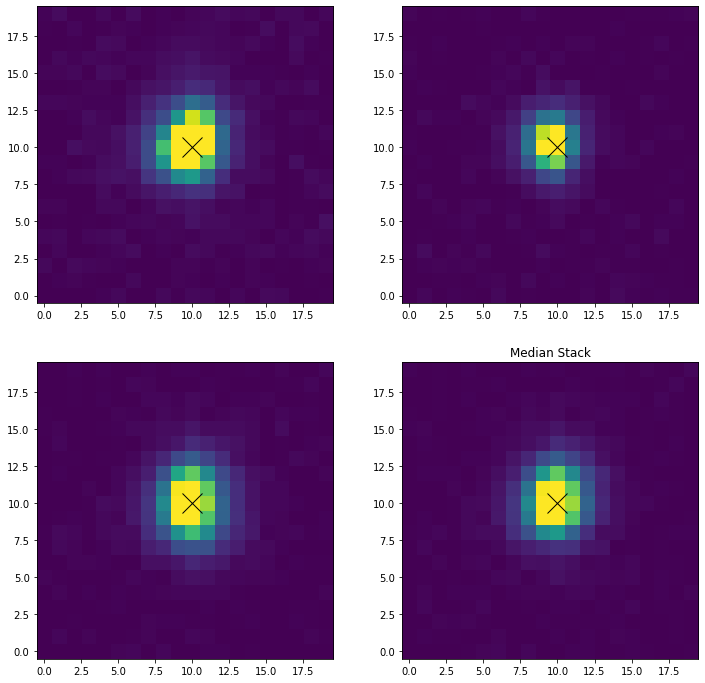

In [36]:
LCV_Aligned1 = np.roll(np.roll(LCV, -5, axis=1), -2, axis=0)
LCB_Aligned1 = np.roll(np.roll(LCB, -5, axis=1), -2, axis=0)
LCI_Aligned1 = np.roll(np.roll(LCI, 0, axis=1), 0, axis=0)
cutout10 = LCV_Aligned1[42:62,145:165]
cutout11 = LCB_Aligned1[42:62,145:165]
cutout12 = LCI_Aligned1[42:62,145:165]
y4, x4 = np.indices([20,20])
xcent10 = int((x4*cutout10).sum()/cutout10.sum() + 145)
ycent10 = int((y4*cutout10).sum()/cutout10.sum() + 42)
xcent11 = int((x4*cutout11).sum()/cutout11.sum() + 145)
ycent11 = int((y4*cutout11).sum()/cutout11.sum() + 42)
xcent12 = int((x4*cutout12).sum()/cutout12.sum() + 145)
ycent12 = int((y4*cutout12).sum()/cutout12.sum() + 42)
LCV_Aligned = np.roll(np.roll(LCV_Aligned1, xcent10 - xcent10, axis=1), ycent10 - ycent10, axis=0)
LCB_Aligned = np.roll(np.roll(LCB_Aligned1, xcent10 - xcent11, axis=1), ycent10 - ycent11, axis=0)
LCI_Aligned = np.roll(np.roll(LCI_Aligned1, xcent10 - xcent12, axis=1), ycent10 - ycent12, axis=0)
LC_3 = [LCV_Aligned, LCB_Aligned, LCI_Aligned]
LC_check = np.median(LC_3, axis=0)

header = fits.getheader(glob.glob("LC_25s_V*FIT")[0])
data = LCV_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('LC_V_Final.FIT', overwrite=True)

header = fits.getheader(glob.glob("LC_25s_B*FIT")[0])
data = LCB_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('LC_B_Final.FIT', overwrite=True)

header = fits.getheader(glob.glob("LC_25s_I*FIT")[0])
data = LCI_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('LC_I_Final.FIT', overwrite=True)

plt.figure(figsize=(12,12))

for ii in range(3):
    ax = plt.subplot(2,2,ii+1)
    ax.imshow(LC_3[ii][42:62,145:165], origin='lower', vmax=600, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(2,2,4)
ax.imshow(LC_check[42:62,145:165], origin='lower', vmax=600, vmin=0)
ax.plot(10, 10, 'kx', markersize=20)

ax.set_title("Median Stack")

## RB Alignments

Text(0.5, 1.0, 'Median Stack')

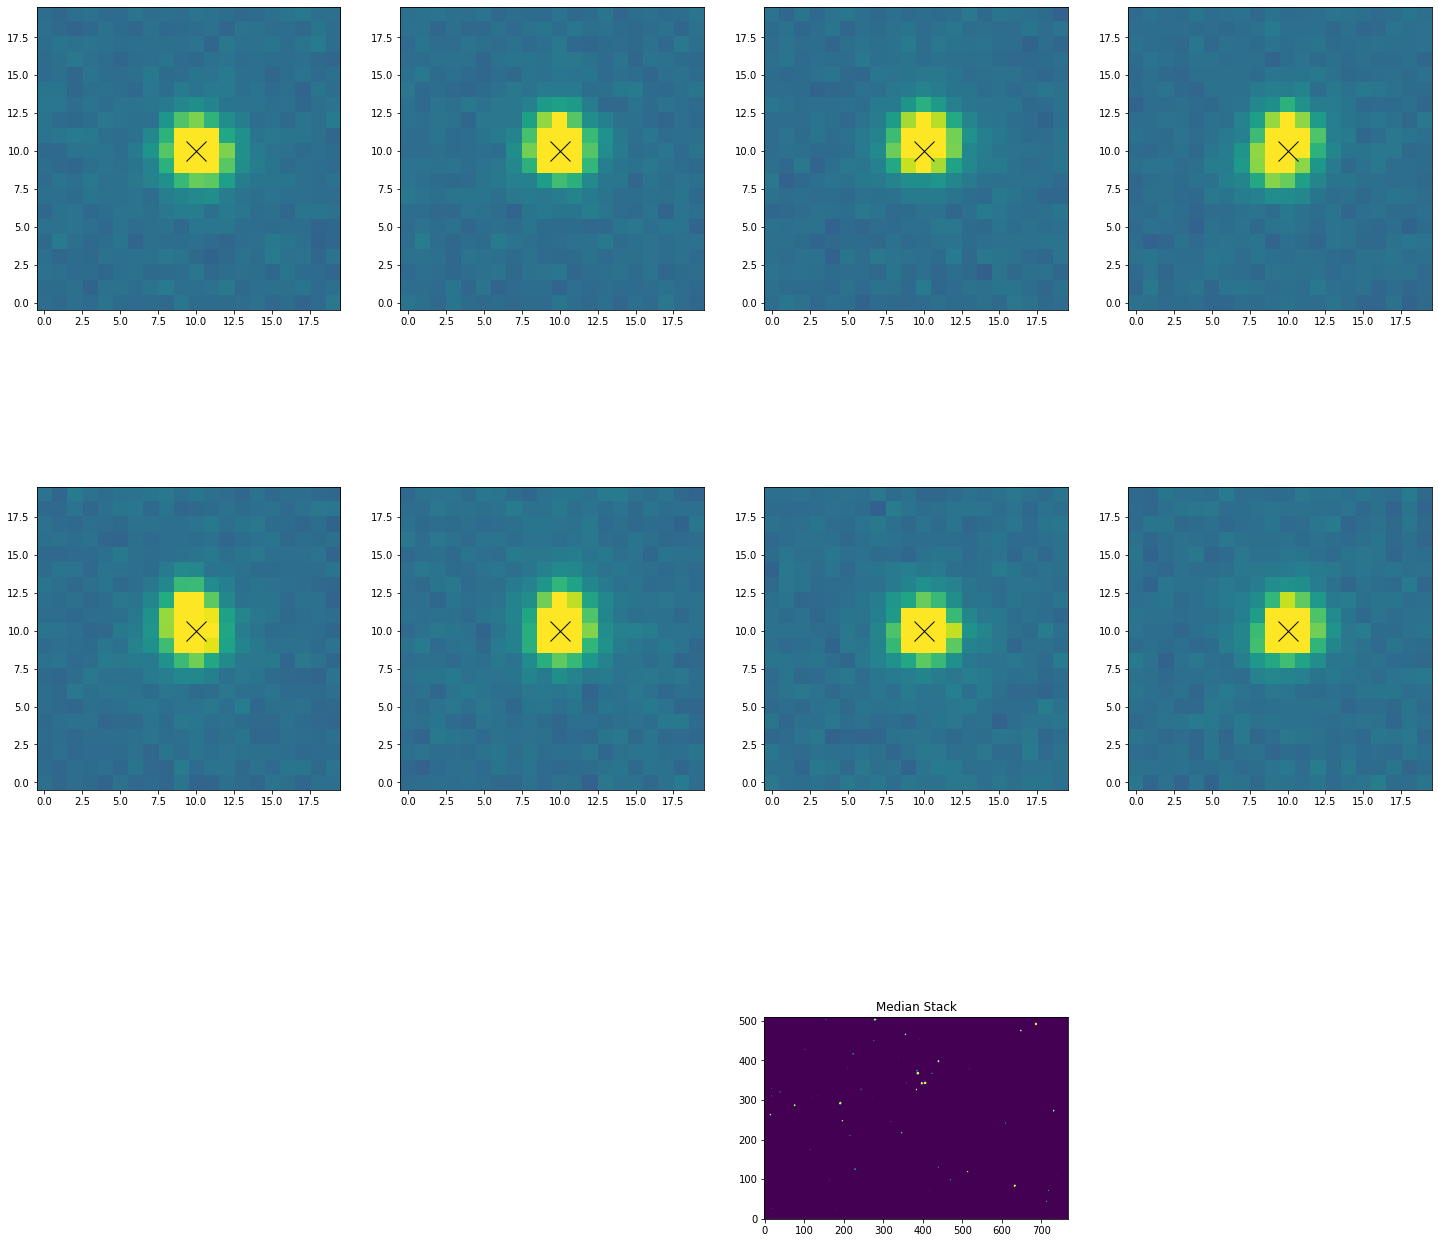

In [37]:
RBV1 = np.roll(np.roll(RB_V[0], 0, axis=1), 0, axis=0)
RBV2 = np.roll(np.roll(RB_V[1], -1, axis=1), 1, axis=0)
RBV3 = np.roll(np.roll(RB_V[2], -2, axis=1), 2, axis=0)
RBV4 = np.roll(np.roll(RB_V[3], -3, axis=1), 2, axis=0)
RBV5 = np.roll(np.roll(RB_V[4], -4, axis=1), 2, axis=0)
RBV6 = np.roll(np.roll(RB_V[5], -4, axis=1), 6, axis=0)
#RBV7 = np.roll(np.roll(RB_V[6], -6, axis=1), 4, axis=0)
#RBV8 = np.roll(np.roll(RB_V[7], -6, axis=1), 3, axis=0)
RBV9 = np.roll(np.roll(RB_V[8], -7, axis=1), 5, axis=0)
RBV0 = np.roll(np.roll(RB_V[9], -8, axis=1), 5, axis=0)
RB_V2 = [RBV1, RBV2, RBV3, RBV4, RBV5, RBV6, RBV9, RBV0]
RB_V1 = centroider(RB_V2, 277,297,67,87,8)
RBV = np.median(RB_V1, axis=0) - np.median(np.median(RB_V1, axis=0))


plt.figure(figsize=(25,25))

for ii in range(8):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(RB_V1[ii][277:297,67:87], origin='lower', vmax=1000, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(RBV, origin='lower', vmax=600, vmin=50)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

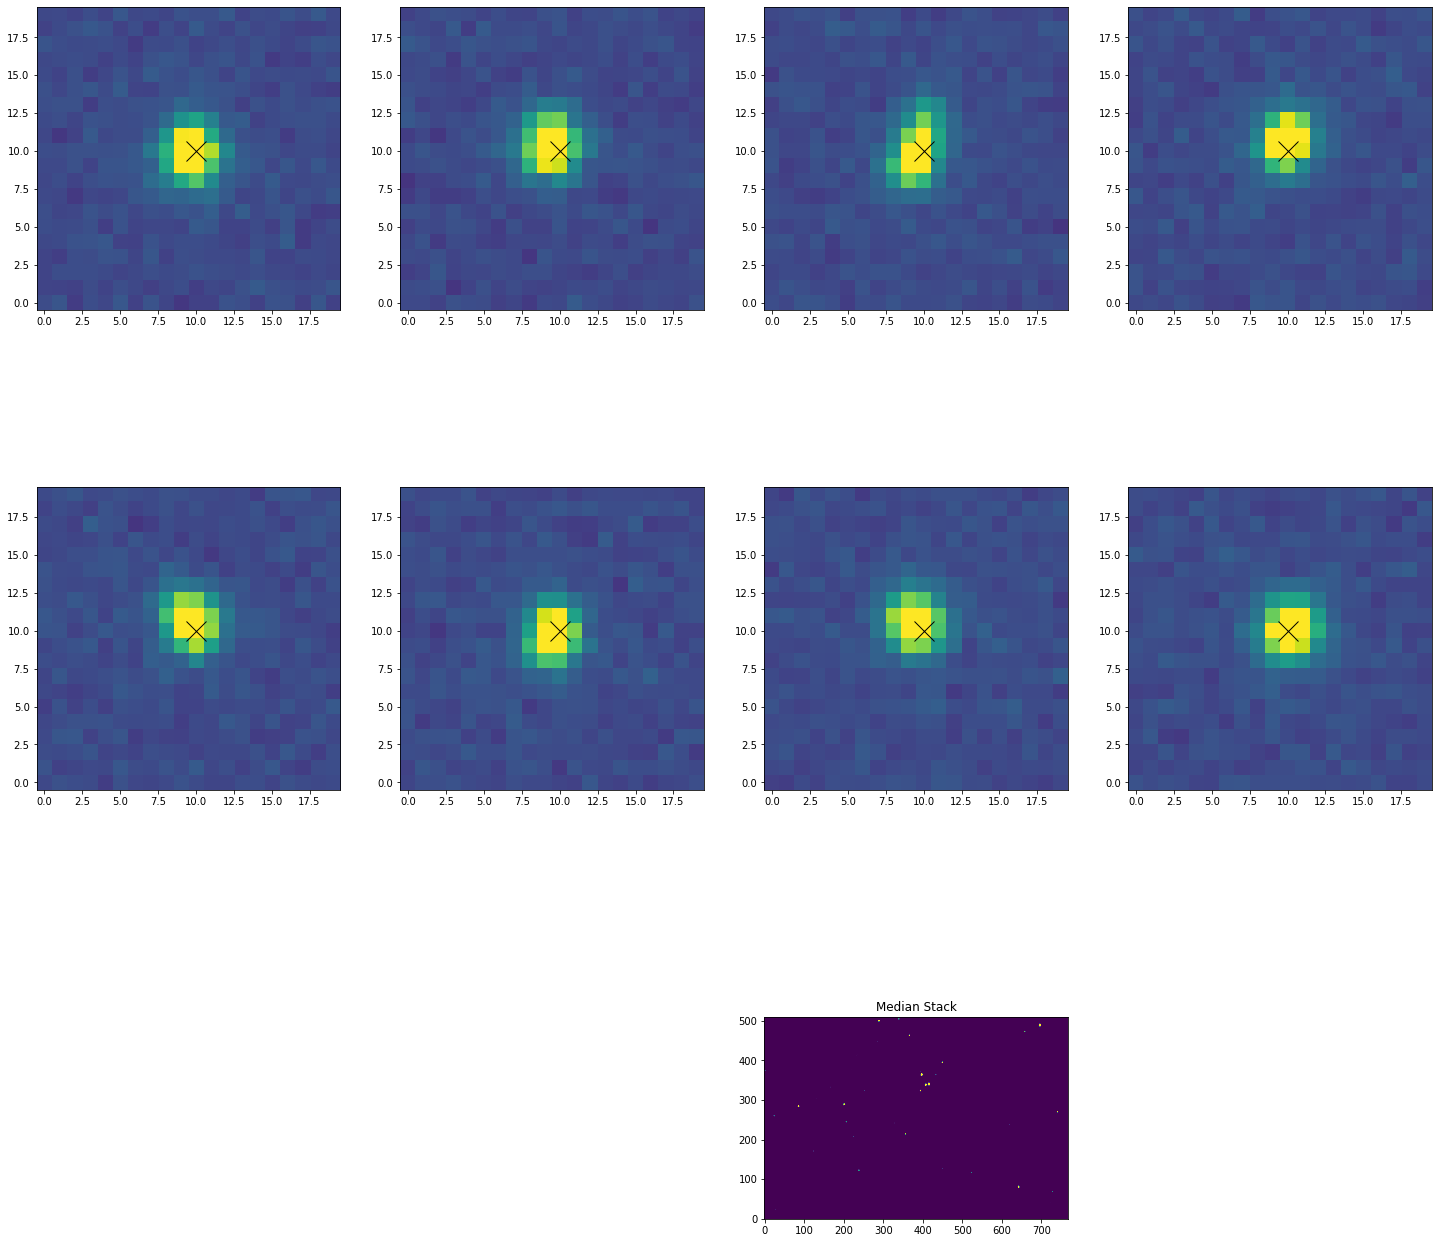

In [38]:
RBB1 = np.roll(np.roll(RB_B[0], 0, axis=1), 0, axis=0)
RBB2 = np.roll(np.roll(RB_B[1], -1, axis=1), 1, axis=0)
RBB3 = np.roll(np.roll(RB_B[2], -2, axis=1), 1, axis=0)
#RBB4 = np.roll(np.roll(RB_B[3], -4, axis=1), -6, axis=0)
#bad data
RBB5 = np.roll(np.roll(RB_B[4], -5, axis=1), -9, axis=0)
RBB6 = np.roll(np.roll(RB_B[5], -6, axis=1), -8, axis=0)
RBB7 = np.roll(np.roll(RB_B[6], -7, axis=1), -10, axis=0)
#RBB8 = np.roll(np.roll(RB_B[7], -8, axis=1), -8, axis=0)
RBB9 = np.roll(np.roll(RB_B[8], -9, axis=1), -6, axis=0)
RBB0 = np.roll(np.roll(RB_B[9], -9, axis=1), -7, axis=0)
RB_B2 = [RBB1, RBB2, RBB3, RBB5, RBB6, RBB7, RBB9, RBB0]
RB_B1 = centroider(RB_B2, 274,294,77,97,e=8)
RBB = np.median(RB_B1, axis=0) - np.median(np.median(RB_B1, axis=0))

plt.figure(figsize=(25,25))

for ii in range(8):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(RB_B1[ii][274:294,77:97], origin='lower', vmax=600, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(RBB, origin='lower', vmax=300, vmin=50)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

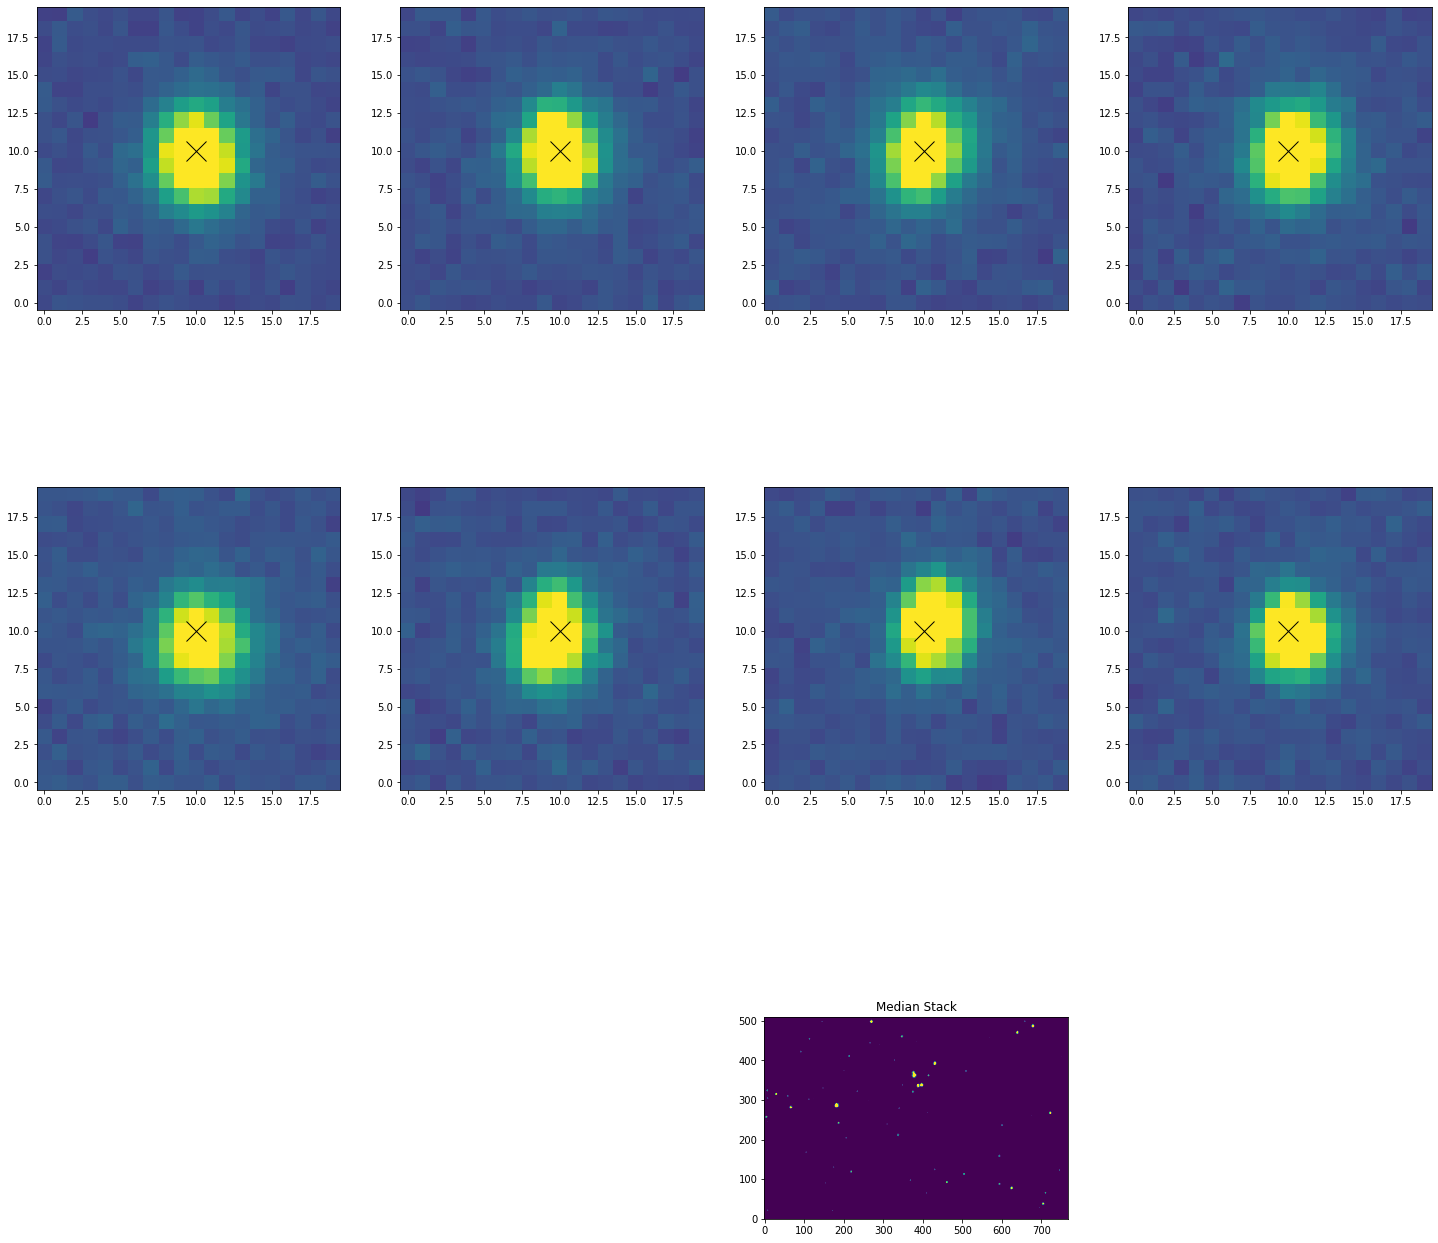

In [39]:
RBI1 = np.roll(np.roll(RB_I[0], 1, axis=1), 0, axis=0)
RBI2 = np.roll(np.roll(RB_I[1], 0, axis=1), 0, axis=0)
RBI3 = np.roll(np.roll(RB_I[2], -1, axis=1), 1, axis=0)
RBI4 = np.roll(np.roll(RB_I[3], -2, axis=1), -2, axis=0)
#RBI5 = np.roll(np.roll(RB_I[4], -2, axis=1), 1, axis=0)
RBI6 = np.roll(np.roll(RB_I[5], -3, axis=1), 4, axis=0)
#RBI7 = np.roll(np.roll(RB_I[6], -5, axis=1), 0, axis=0)
RBI8 = np.roll(np.roll(RB_I[7], -7, axis=1), -7, axis=0)
RBI9 = np.roll(np.roll(RB_I[8], -7, axis=1), -9, axis=0)
RBI0 = np.roll(np.roll(RB_I[9], -8, axis=1), -11, axis=0)
RB_I2 = [RBI1, RBI2, RBI3, RBI4, RBI6, RBI8, RBI9, RBI0]
RB_I1 = centroider(RB_I2, 272,292,57,77,8)
RBI = np.median(RB_I1, axis=0) - np.median(np.median(RB_I1, axis=0))

plt.figure(figsize=(25,25))

for ii in range(8):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(RB_I1[ii][272:292,57:77], origin='lower', vmax=600, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(RBI, origin='lower', vmax=400, vmin=50)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

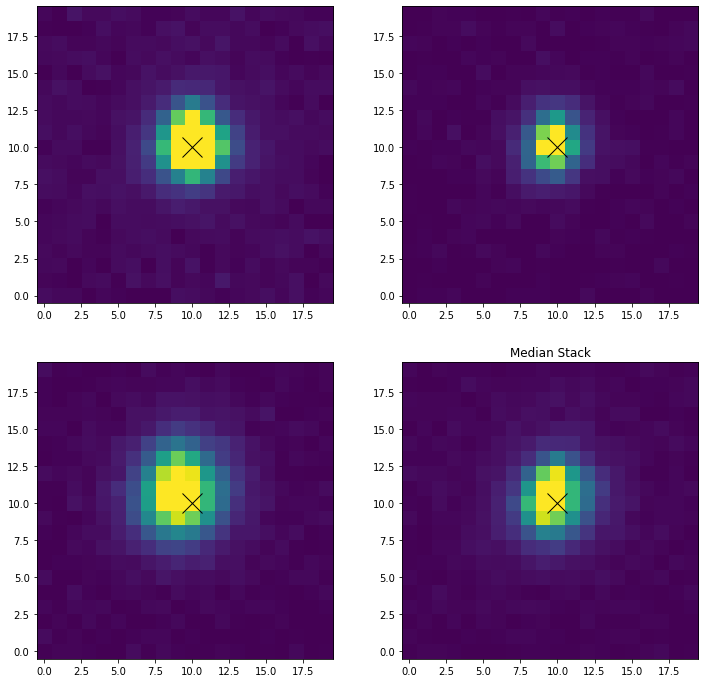

In [40]:
RBV_Aligned1 = np.roll(np.roll(RBV, -10, axis=1), -5, axis=0)
RBB_Aligned1 = np.roll(np.roll(RBB, -20, axis=1), -2, axis=0)
RBI_Aligned1 = np.roll(np.roll(RBI, 0, axis=1), 0, axis=0)
cutout13 = RBV_Aligned1[272:292,57:77]
cutout14 = RBB_Aligned1[272:292,57:77]
cutout15 = RBI_Aligned1[272:292,57:77]
y4, x4 = np.indices([20,20])
xcent13 = int((x4*cutout13).sum()/cutout13.sum() + 57)
ycent13 = int((y4*cutout13).sum()/cutout13.sum() + 272)
xcent14 = int((x4*cutout14).sum()/cutout14.sum() + 57)
ycent14 = int((y4*cutout14).sum()/cutout14.sum() + 272)
xcent15 = int((x4*cutout15).sum()/cutout15.sum() + 57)
ycent15 = int((y4*cutout15).sum()/cutout15.sum() + 272)
RBV_Aligned = np.roll(np.roll(RBV_Aligned1, xcent13 - xcent13, axis=1), ycent13 - ycent13, axis=0)
RBB_Aligned = np.roll(np.roll(RBB_Aligned1, xcent13 - xcent14, axis=1), ycent13 - ycent14, axis=0)
RBI_Aligned = np.roll(np.roll(RBI_Aligned1, xcent13 - xcent15, axis=1), ycent13 - ycent15, axis=0)
RB_3 = [RBV_Aligned, RBB_Aligned, RBI_Aligned]
RB_check = np.median(RB_3, axis=0)

header = fits.getheader(glob.glob("RB_25s_V*FIT")[0])
data = RBV_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('RB_V_Final.FIT', overwrite=True)

header = fits.getheader(glob.glob("RB_25s_B*FIT")[0])
data = RBB_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('RB_B_Final.FIT', overwrite=True)

header = fits.getheader(glob.glob("RB_25s_I*FIT")[0])
data = RBI_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('RB_I_Final.FIT', overwrite=True)

plt.figure(figsize=(12,12))

for ii in range(3):
    ax = plt.subplot(2,2,ii+1)
    ax.imshow(RB_3[ii][272:292,57:77], origin='lower', vmax=600, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(2,2,4)
ax.imshow(RB_check[272:292,57:77], origin='lower', vmax=600, vmin=0)
ax.plot(10, 10, 'kx', markersize=20)

ax.set_title("Median Stack")

## RC Alignments

Text(0.5, 1.0, 'Median Stack')

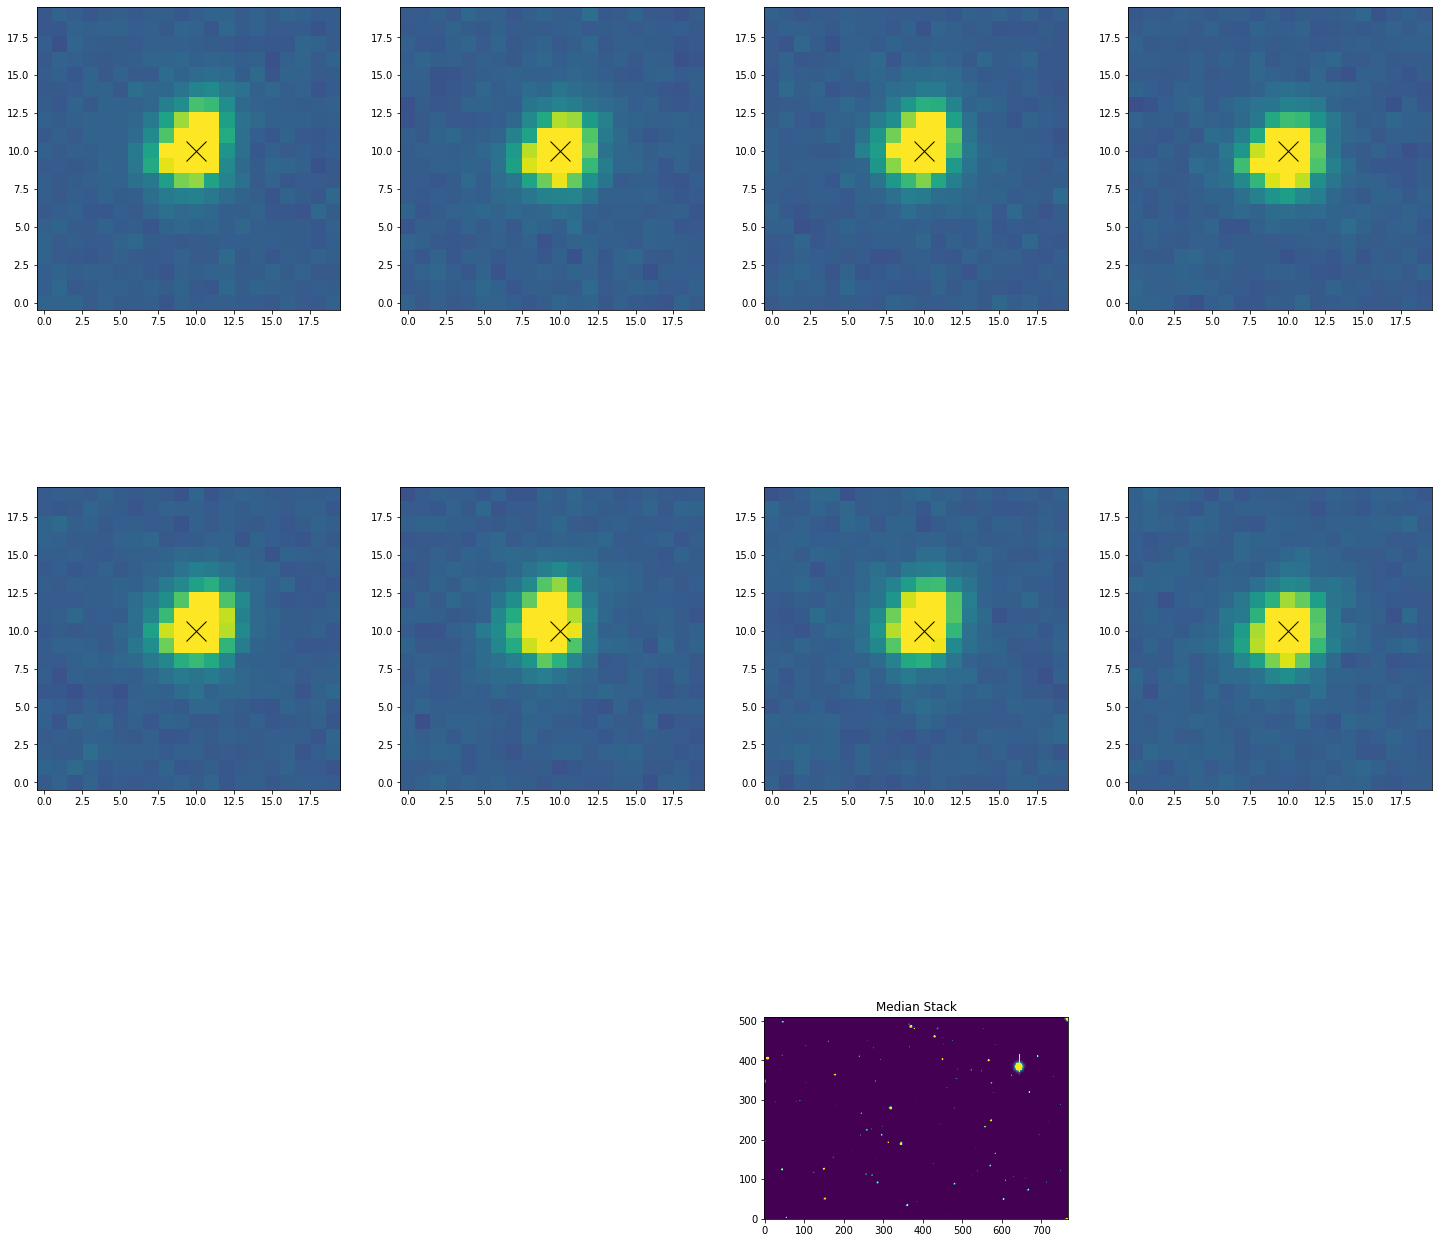

In [41]:
RCV1 = np.roll(np.roll(RC_V[0], 0, axis=1), 0, axis=0)
RCV2 = np.roll(np.roll(RC_V[1], 0, axis=1), 0, axis=0)
RCV3 = np.roll(np.roll(RC_V[2], 0, axis=1), 2, axis=0)
RCV4 = np.roll(np.roll(RC_V[3], 0, axis=1), 2, axis=0)
RCV5 = np.roll(np.roll(RC_V[4], 0, axis=1), 1, axis=0)
#RCV6 = np.roll(np.roll(RC_V[5], 0, axis=1), 4, axis=0)
RCV7 = np.roll(np.roll(RC_V[6], 0, axis=1), 7, axis=0)
#RCV8 = np.roll(np.roll(RC_V[7], 0, axis=1), 3, axis=0)
RCV9 = np.roll(np.roll(RC_V[8], 0, axis=1), 3, axis=0)
RCV0 = np.roll(np.roll(RC_V[9], 0, axis=1), 3, axis=0)
RC_V2 = [RCV1, RCV2, RCV3, RCV4, RCV5, RCV7, RCV9, RCV0]
RC_V1 = centroider(RC_V2, 116,136,141,161, 8)
RCV = np.median(RC_V1, axis=0) - np.median(np.median(RC_V1, axis=0))

plt.figure(figsize=(25,25))

for ii in range(8):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(RC_V1[ii][116:136,141:161], origin='lower', vmax=1000, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(RCV, origin='lower', vmax=600, vmin=50)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

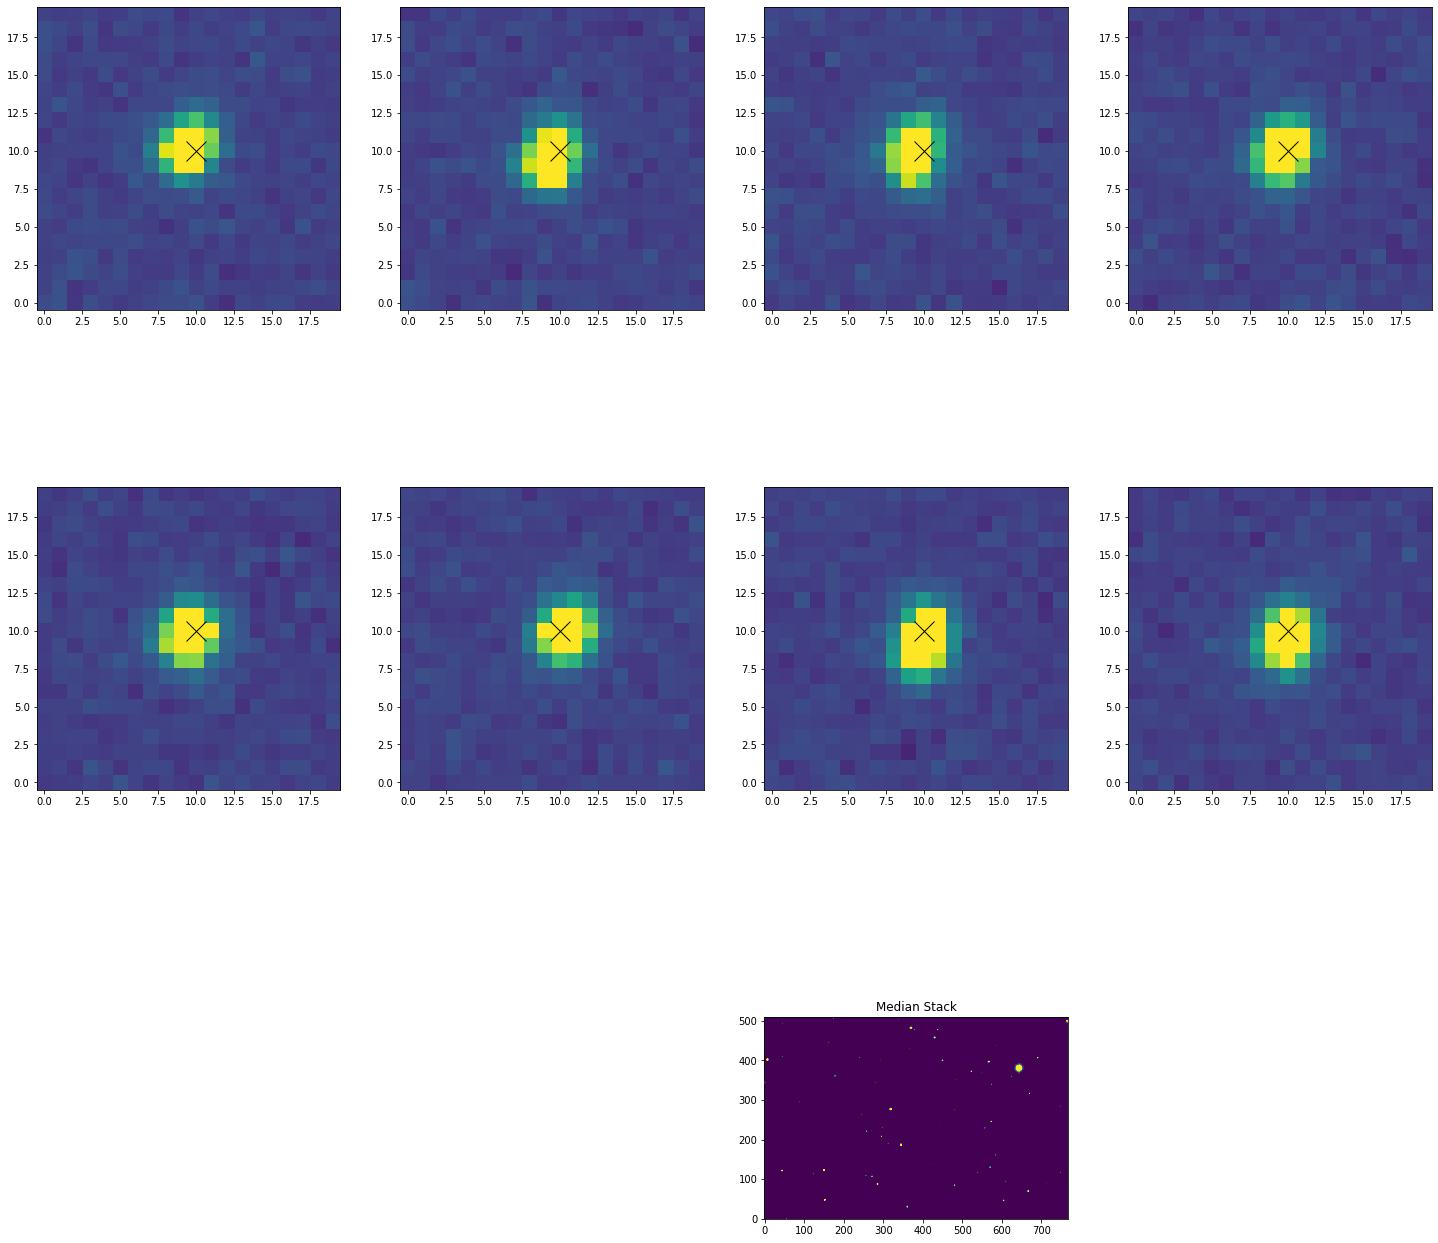

In [42]:
RCB1 = np.roll(np.roll(RC_B[0], 0, axis=1), 0, axis=0)
RCB2 = np.roll(np.roll(RC_B[1], 0, axis=1), -1, axis=0)
RCB3 = np.roll(np.roll(RC_B[2], 0, axis=1), 0, axis=0)
#RCB4 = np.roll(np.roll(RC_B[3], 0, axis=1), -3, axis=0)
#RCB5 = np.roll(np.roll(RC_B[4], -1, axis=1), -10, axis=0)
RCB6 = np.roll(np.roll(RC_B[5], -1, axis=1), -12, axis=0)
RCB7 = np.roll(np.roll(RC_B[6], -1, axis=1), -11, axis=0)
RCB8 = np.roll(np.roll(RC_B[7], 0, axis=1), -12, axis=0)
RCB9 = np.roll(np.roll(RC_B[8], 0, axis=1), -9, axis=0)
RCB0 = np.roll(np.roll(RC_B[9], 0, axis=1), -8, axis=0)
RC_B2 = [RCB1, RCB2, RCB3, RCB6, RCB7, RCB8, RCB9, RCB0]
RC_B1 = centroider(RC_B2, 113,133,141,161, 8)
RCB = np.median(RC_B1, axis=0) - np.median(np.median(RC_B1, axis=0))

plt.figure(figsize=(25,25))

for ii in range(8):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(RC_B1[ii][113:133,141:161], origin='lower', vmax=600, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(RCB, origin='lower', vmax=300, vmin=50)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

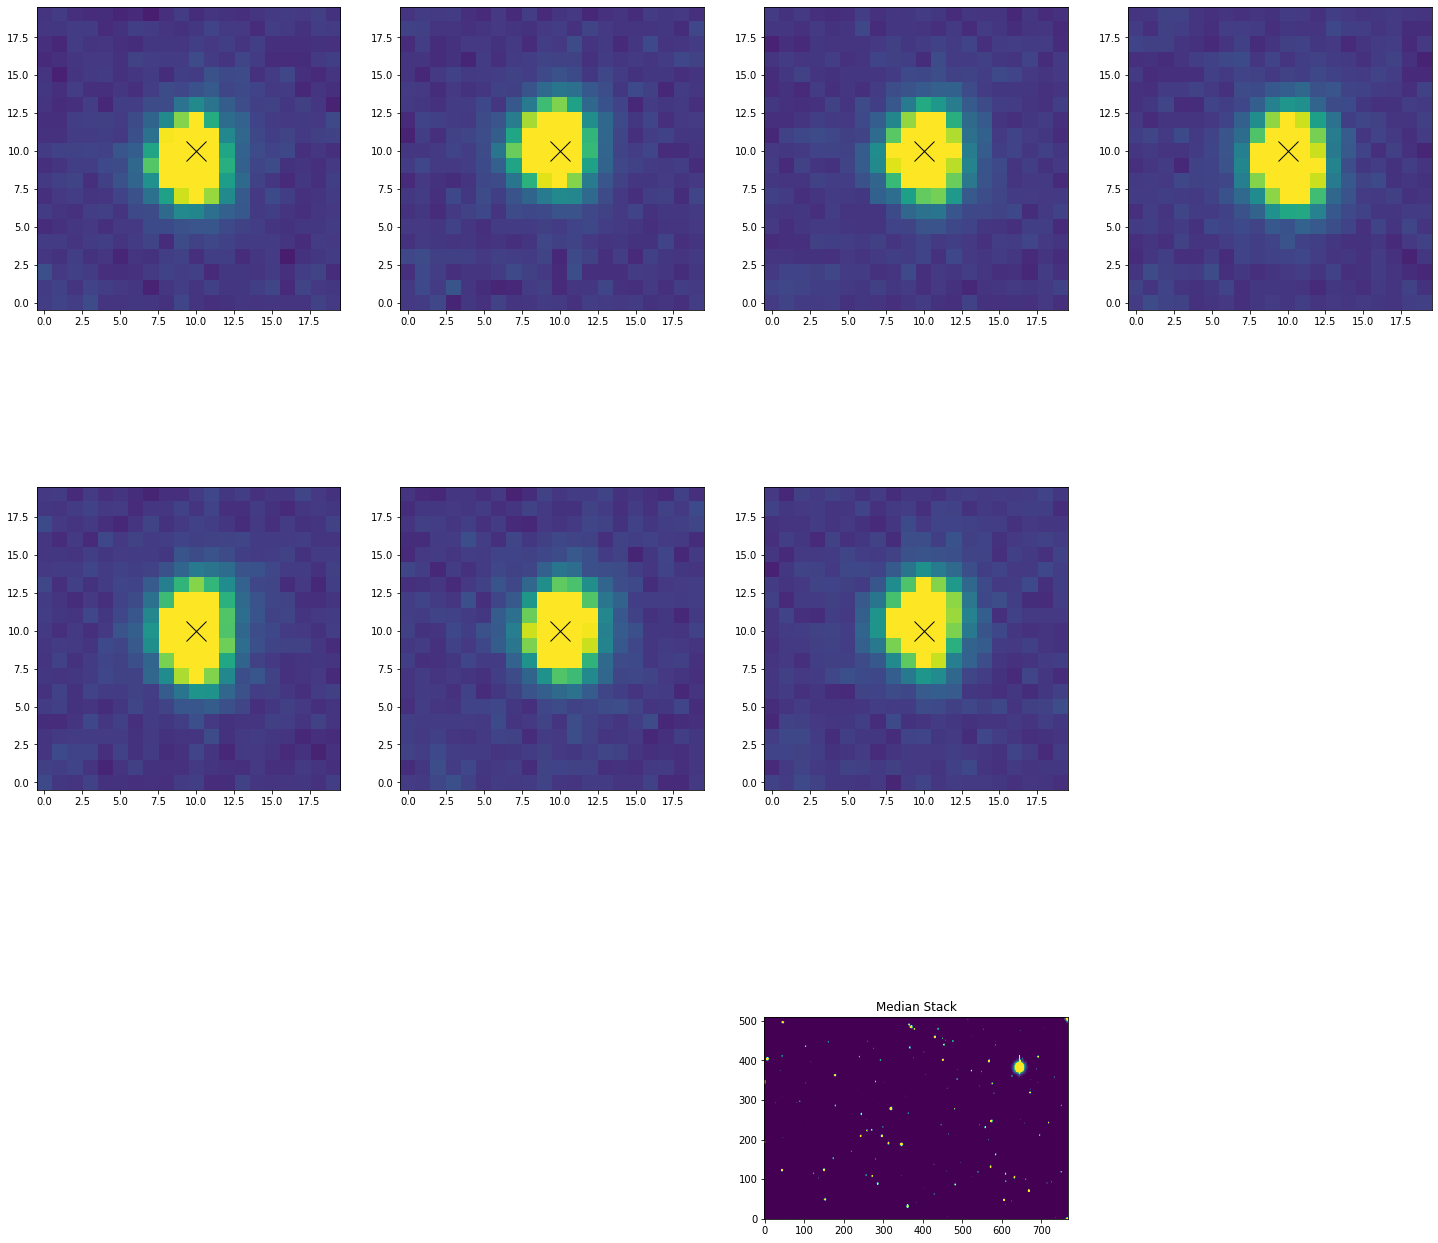

In [43]:
RCI1 = np.roll(np.roll(RC_I[0], -1, axis=1), 7, axis=0)
RCI2 = np.roll(np.roll(RC_I[1], -1, axis=1), 6, axis=0)
RCI3 = np.roll(np.roll(RC_I[2], 0, axis=1), 7, axis=0)
RCI4 = np.roll(np.roll(RC_I[3], 0, axis=1), 5, axis=0)
RCI5 = np.roll(np.roll(RC_I[4], 0, axis=1), 5, axis=0)
#RCI6 = np.roll(np.roll(RC_I[5], 1, axis=1), 9, axis=0)
#RCI7 = np.roll(np.roll(RC_I[6], 1, axis=1), 7, axis=0)
#RCI8 = np.roll(np.roll(RC_I[7], 0, axis=1), 0, axis=0)
RCI9 = np.roll(np.roll(RC_I[8], 0, axis=1), -3, axis=0)
RCI0 = np.roll(np.roll(RC_I[9], 0, axis=1), -4, axis=0)
RC_I2 = [RCI1, RCI2, RCI3, RCI4, RCI5, RCI9, RCI0]
RC_I1 = centroider(RC_I2, 114,134,141,161, 7)
RCI = np.median(RC_I1, axis=0) - np.median(np.median(RC_I1, axis=0))

plt.figure(figsize=(25,25))

for ii in range(7):
    ax = plt.subplot(3,4,ii+1)
    ax.imshow(RC_I1[ii][114:134,141:161], origin='lower', vmax=600, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(3,4,11)
ax.imshow(RCI, origin='lower', vmax=400, vmin=50)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

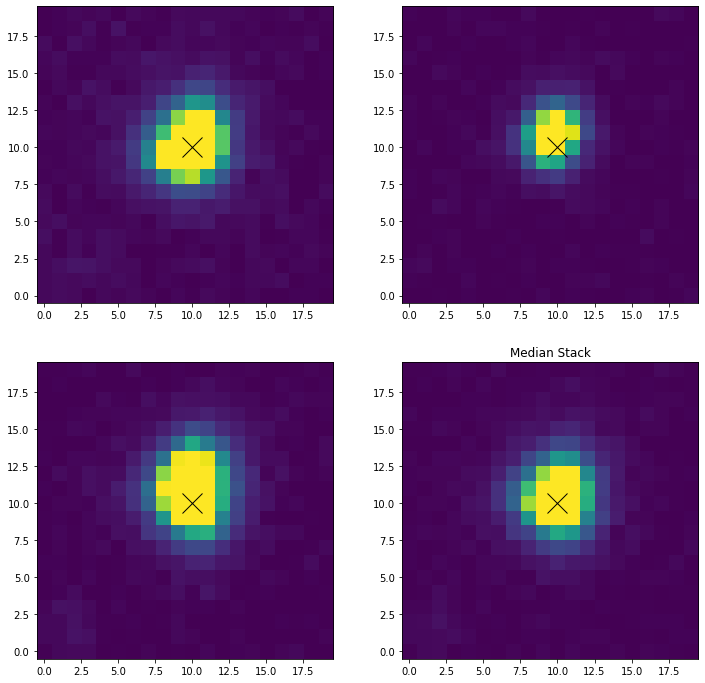

In [44]:
RCV_Aligned1 = np.roll(np.roll(RCV, 0, axis=1), -2, axis=0)
RCB_Aligned1 = np.roll(np.roll(RCB, 0, axis=1), 1, axis=0)
RCI_Aligned1 = np.roll(np.roll(RCI, 0, axis=1), 0, axis=0)
cutout16 = RCV_Aligned1[114:134,141:161]
cutout17 = RCB_Aligned1[114:134,141:161]
cutout18 = RCI_Aligned1[114:134,141:161]
y4, x4 = np.indices([20,20])
xcent16 = int((x4*cutout16).sum()/cutout16.sum() + 141)
ycent16 = int((y4*cutout16).sum()/cutout16.sum() + 114)
xcent17 = int((x4*cutout17).sum()/cutout17.sum() + 141)
ycent17 = int((y4*cutout17).sum()/cutout17.sum() + 114)
xcent18 = int((x4*cutout18).sum()/cutout18.sum() + 141)
ycent18 = int((y4*cutout18).sum()/cutout18.sum() + 114)
RCV_Aligned = np.roll(np.roll(RCV_Aligned1, xcent16 - xcent16, axis=1), ycent16 - ycent16, axis=0)
RCB_Aligned = np.roll(np.roll(RCB_Aligned1, xcent16 - xcent17, axis=1), ycent16 - ycent17, axis=0)
RCI_Aligned = np.roll(np.roll(RCI_Aligned1, xcent16 - xcent18, axis=1), ycent16 - ycent18, axis=0)
RC_3 = [RCV_Aligned, RCB_Aligned, RCI_Aligned]
RC_check = np.median(RC_3, axis=0)

header = fits.getheader(glob.glob("RC_25s_V*FIT")[0])
data = RCV_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('RC_V_Final.FIT', overwrite=True)

header = fits.getheader(glob.glob("RC_25s_B*FIT")[0])
data = RCB_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('RC_B_Final.FIT', overwrite=True)

header = fits.getheader(glob.glob("RC_25s_I*FIT")[0])
data = RCI_Aligned
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('RC_I_Final.FIT', overwrite=True)

plt.figure(figsize=(12,12))

for ii in range(3):
    ax = plt.subplot(2,2,ii+1)
    ax.imshow(RC_3[ii][114:134,141:161], origin='lower', vmax=600, vmin=0)
    ax.plot(10, 10, 'kx', markersize=20)

ax = plt.subplot(2,2,4)
ax.imshow(RC_check[114:134,141:161], origin='lower', vmax=600, vmin=0)
ax.plot(10, 10, 'kx', markersize=20)

ax.set_title("Median Stack")

# Mosaicing 
## B-Filters

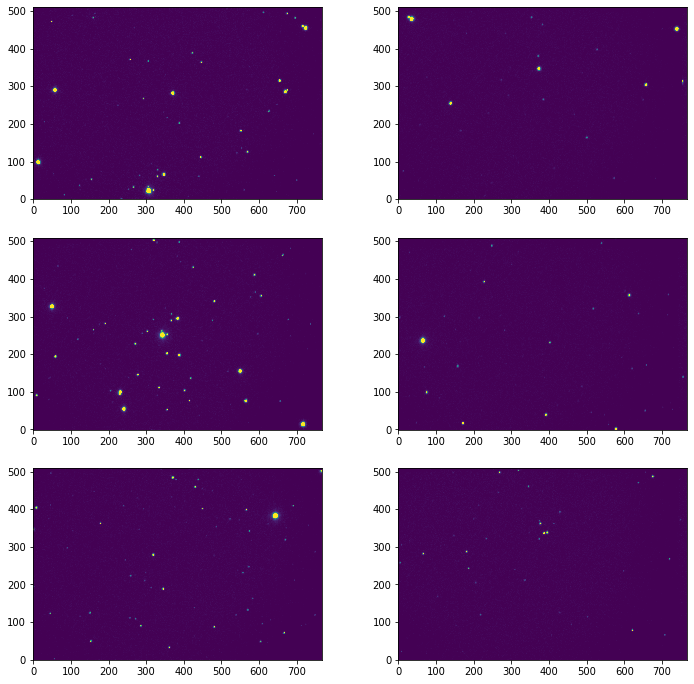

In [45]:
plt.figure(figsize=(12,12))
plt.subplot(3,2,1).imshow(LCB_Aligned, origin='lower', vmax=600, vmin=0)
plt.subplot(3,2,2).imshow(LBB_Aligned, origin='lower', vmax=600, vmin=0)
plt.subplot(3,2,3).imshow(centralB_Aligned, origin='lower', vmax=600, vmin=0)
plt.subplot(3,2,4).imshow(CBB_Aligned, origin='lower', vmax=600, vmin=0)
plt.subplot(3,2,5).imshow(RCB_Aligned, origin='lower', vmax=600, vmin=0)
plt.subplot(3,2,6).imshow(RBB_Aligned, origin='lower', vmax=600, vmin=0)

(37, 230)

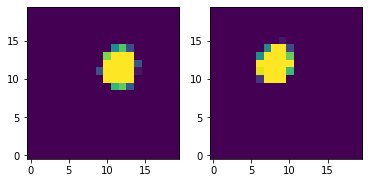

In [46]:
cutout1 = LCB_Aligned[20:40,255:275]
cutout2 = centralB_Aligned[250:270,295:315]
plt.subplot(1,2,1).imshow(cutout1, origin='lower', vmax=200, vmin=80)
plt.subplot(1,2,2).imshow(cutout2, origin='lower', vmax=200, vmin=80)
yi,xi = np.indices([20,20])
xcen1 = (xi*cutout1).sum()/cutout1.sum() + 255
ycen1 = (yi*cutout1).sum()/cutout1.sum() + 20
xcen2 = (xi*cutout2).sum()/cutout2.sum() + 295
ycen2 = (yi*cutout2).sum()/cutout2.sum() + 250
yleft = int(ycen2 - ycen1)
xleft = int(xcen2 - xcen1)
xleft, yleft

(-687, 24)

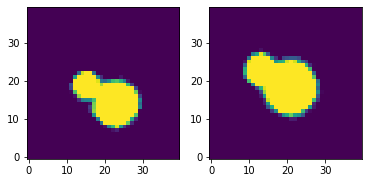

In [47]:
cutout3 = LCB_Aligned[440:480,700:740]
cutout4 = LBB_Aligned[460:500, 15:55]
plt.subplot(1,2,1).imshow(cutout3, origin='lower', vmax=200, vmin=80)
plt.subplot(1,2,2).imshow(cutout4, origin='lower', vmax=200, vmin=80)
yi,xi = np.indices([40,40])
xcen3 = (xi*cutout3).sum()/cutout3.sum() + 700
ycen3 = (yi*cutout3).sum()/cutout3.sum() + 440
xcen4 = (xi*cutout4).sum()/cutout4.sum() + 15
ycen4 = (yi*cutout4).sum()/cutout4.sum() + 460
yleft1 = int(ycen4 - ycen3)
xleft1 = int(xcen4 - xcen3)
xleft1, yleft1

(-651, 222)

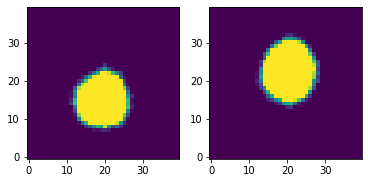

In [48]:
cutout5 = centralB_Aligned[0:40,697:737]
cutout6 = CBB_Aligned[215:255, 45:85]
plt.subplot(1,2,1).imshow(cutout5, origin='lower', vmax=200, vmin=80)
plt.subplot(1,2,2).imshow(cutout6, origin='lower', vmax=200, vmin=80)
yi,xi = np.indices([40,40])
xcen5 = (xi*cutout5).sum()/cutout5.sum() + 697
ycen5 = (yi*cutout5).sum()/cutout5.sum()
xcen6 = (xi*cutout6).sum()/cutout6.sum() + 45
ycen6 = (yi*cutout6).sum()/cutout6.sum() + 215
yleft2 = int(ycen6 - ycen5)
xleft2 = int(xcen6 - xcen5)
xleft2, yleft2

(-599, 210)

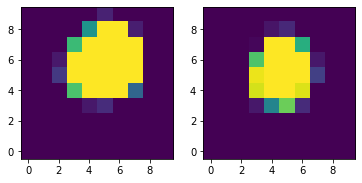

In [49]:
cutout7 = RCB_Aligned[66:76,661:671]
cutout8 = RBB_Aligned[277:287,62:72]
plt.subplot(1,2,1).imshow(cutout7, origin='lower', vmax=200, vmin=80)
plt.subplot(1,2,2).imshow(cutout8, origin='lower', vmax=200, vmin=80)
yi,xi = np.indices([10,10])
xcen7 = (xi*cutout7).sum()/cutout7.sum() + 661
ycen7 = (yi*cutout7).sum()/cutout7.sum() + 66
xcen8 = (xi*cutout8).sum()/cutout8.sum() + 62
ycen8 = (yi*cutout8).sum()/cutout8.sum() + 277
yleft3 = int(ycen8 - ycen7)
xleft3 = int(xcen8 - xcen7)
xleft3, yleft3

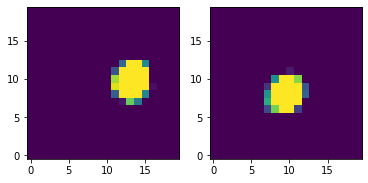

In [50]:
cutout9 = RCB_Aligned[40:60,140:160]
cutout0 = RBB_Aligned[490:510, 260:280]
plt.subplot(1,2,1).imshow(cutout9, origin='lower', vmax=200, vmin=80)
plt.subplot(1,2,2).imshow(cutout0, origin='lower', vmax=200, vmin=80)
yi,xi = np.indices([20,20])
xcen9 = (xi*cutout9).sum()/cutout9.sum() + 140
ycen9 = (yi*cutout9).sum()/cutout9.sum() + 40
xcen0 = (xi*cutout0).sum()/cutout0.sum() + 260
ycen0 = (yi*cutout0).sum()/cutout0.sum() + 490
yleft4 = int(ycen0 - ycen9)
xleft4 = int(xcen0 - xcen9)
cutouts = [cutout1, cutout2, cutout3, cutout4, cutout5, cutout6, cutout7, cutout8, cutout9, cutout0]

In [51]:
bigim1=np.zeros([2250,2250])
bigim2=np.zeros([2250,2250])
bigim3=np.zeros([2250,2250])
bigim4=np.zeros([2250,2250])
bigim5=np.zeros([2250,2250])
bigim6=np.zeros([2250,2250])

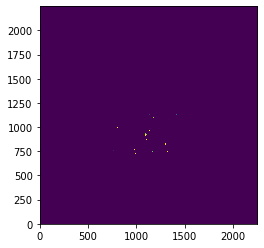

In [52]:
aa = yleft4+yleft2
bb = 1283+xleft4+xleft2
cc = aa + yleft
dd = bb + xleft
bigim1[aa:aa+CBB_Aligned.shape[0], bb:bb+CBB_Aligned.shape[1]] = centralB_Aligned
bigim1[aa:yleft4+CBB_Aligned.shape[0],1283+xleft4:bb+CBB_Aligned.shape[1]]=0
bigim1[aa+CBB_Aligned.shape[0]-20:,dd:bb+CBB_Aligned.shape[1]] = 0
plt.imshow(bigim1, origin='lower', vmax=200, vmin=80)

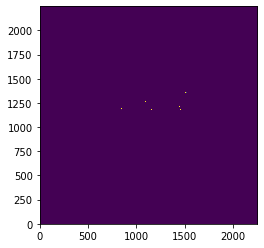

In [53]:
bigim2[cc:cc+CBB_Aligned.shape[0], dd:dd+CBB_Aligned.shape[1]] = LCB_Aligned
bigim2[cc:aa+CBB_Aligned.shape[0]-20,dd:bb+CBB_Aligned.shape[1]] = 0
bigim2[cc:yleft4+CBB_Aligned.shape[0],bb+CBB_Aligned.shape[1]:dd+CBB_Aligned.shape[1]] = 0
plt.imshow(bigim2, origin='lower', vmax=200, vmin=80)

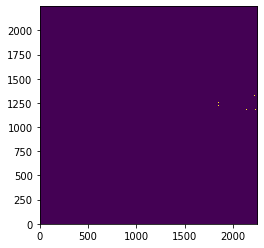

In [54]:
bigim3[cc-yleft1:cc-yleft1+CBB_Aligned.shape[0], dd-xleft1:dd-xleft1+CBB_Aligned.shape[1]] = LBB_Aligned
bigim3[cc-yleft1:cc-yleft1+CBB_Aligned.shape[0],dd-xleft1:dd+CBB_Aligned.shape[1]] = 0
bigim3[cc-yleft1:yleft4+CBB_Aligned.shape[0],dd-xleft1:1283+xleft4+CBB_Aligned.shape[1]] = 0
plt.imshow(bigim3, origin='lower', vmax=200, vmin=80)

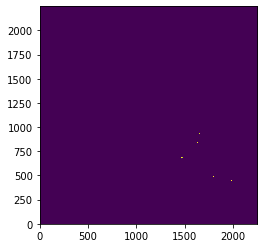

In [55]:
bigim4[yleft4:yleft4+CBB_Aligned.shape[0], 1283+xleft4:1283+xleft4+CBB_Aligned.shape[1]] = CBB_Aligned
plt.imshow(bigim4, origin='lower', vmax=200, vmin=80)

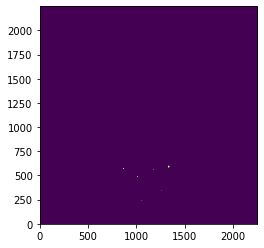

In [56]:
bigim5[yleft3:yleft3+CBB_Aligned.shape[0], 1283+xleft3:1283+xleft3+CBB_Aligned.shape[1]] = RCB_Aligned
#RC central overlap
bigim5[aa:yleft3+CBB_Aligned.shape[0],bb:1283+xleft3+CBB_Aligned.shape[1]] = 0
#RC CB overlap
bigim5[yleft4:yleft3+CBB_Aligned.shape[0],1283+xleft4:1283+xleft3+CBB_Aligned.shape[1]] = 0
#RC RB overlap
bigim5[yleft3:RBB_Aligned.shape[0],1283:1283+xleft3+CBB_Aligned.shape[1]] = 0
plt.imshow(bigim5, origin='lower', vmax=200, vmin=80)

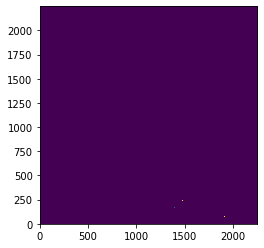

In [57]:
bigim6[0:RBB_Aligned.shape[0], 1283:1283+RBB_Aligned.shape[1]] = RBB_Aligned
bigim6[yleft4:RBB_Aligned.shape[0],1283+xleft4:1283+RBB_Aligned.shape[1]] = 0
plt.imshow(bigim6, origin='lower', vmax=200, vmin=80)

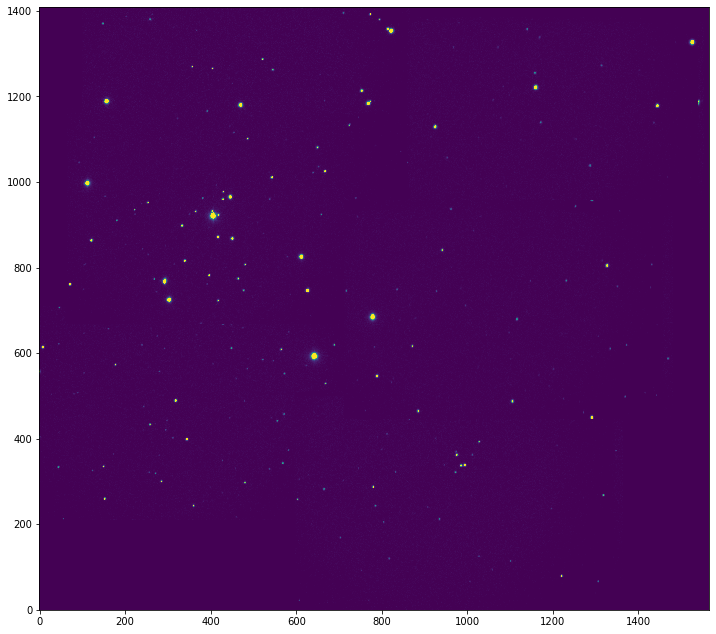

In [58]:
cts1 = np.isfinite(bigim1).astype('int')
cts2 = np.isfinite(bigim2).astype('int')
cts3 = np.isfinite(bigim3).astype('int')
cts4 = np.isfinite(bigim4).astype('int')
cts5 = np.isfinite(bigim5).astype('int')
cts6 = np.isfinite(bigim6).astype('int')
plt.figure(figsize=(12,12))
mosaic0 = (bigim1+bigim2+bigim3+bigim4+bigim5+bigim6) / (cts1+cts2+cts3+cts4+cts5+cts6)
mosaicB1 = mosaic0[0:cc+CBB_Aligned.shape[0],1283+xleft3:]
plt.imshow(mosaicB1, origin='lower', vmax=100, vmin=0)

## V-Filters

In [59]:
bigim1V=np.zeros([2250,2250])
bigim2V=np.zeros([2250,2250])
bigim3V=np.zeros([2250,2250])
bigim4V=np.zeros([2250,2250])
bigim5V=np.zeros([2250,2250])
bigim6V=np.zeros([2250,2250])
bigim1V[aa:aa+CBB_Aligned.shape[0], bb:bb+CBB_Aligned.shape[1]] = centralV_Aligned
bigim2V[cc:cc+CBB_Aligned.shape[0], dd:dd+CBB_Aligned.shape[1]] = LCV_Aligned
bigim3V[cc-yleft1:cc-yleft1+CBB_Aligned.shape[0], dd-xleft1:dd-xleft1+CBB_Aligned.shape[1]] = LBV_Aligned
bigim4V[yleft4:yleft4+CBB_Aligned.shape[0], 1283+xleft4:1283+xleft4+CBB_Aligned.shape[1]] = CBV_Aligned
bigim5V[yleft3:yleft3+CBB_Aligned.shape[0], 1283+xleft3:1283+xleft3+CBB_Aligned.shape[1]] = RCV_Aligned
bigim6V[0:RBB_Aligned.shape[0], 1283:1283+RBB_Aligned.shape[1]] = RBV_Aligned

In [60]:
bigim1V[aa:yleft4+CBB_Aligned.shape[0],1283+xleft4:bb+CBB_Aligned.shape[1]]=0
bigim1V[aa+CBB_Aligned.shape[0]-20:,dd:bb+CBB_Aligned.shape[1]] = 0
bigim2V[cc:aa+CBB_Aligned.shape[0]-20,dd:bb+CBB_Aligned.shape[1]] = 0
bigim2V[cc:yleft4+CBB_Aligned.shape[0],bb+CBB_Aligned.shape[1]:dd+CBB_Aligned.shape[1]] = 0
bigim3V[cc-yleft1:cc-yleft1+CBB_Aligned.shape[0],dd-xleft1:dd+CBB_Aligned.shape[1]] = 0
bigim3V[cc-yleft1:yleft4+CBB_Aligned.shape[0],dd-xleft1:1283+xleft4+CBB_Aligned.shape[1]] = 0
bigim5V[aa:yleft3+CBB_Aligned.shape[0],bb:1283+xleft3+CBB_Aligned.shape[1]] = 0
bigim5V[yleft4:yleft3+CBB_Aligned.shape[0],1283+xleft4:1283+xleft3+CBB_Aligned.shape[1]] = 0
bigim5V[yleft3:RBB_Aligned.shape[0],1283:1283+xleft3+CBB_Aligned.shape[1]] = 0
bigim6V[yleft4:RBB_Aligned.shape[0],1283+xleft4:1283+RBB_Aligned.shape[1]] = 0

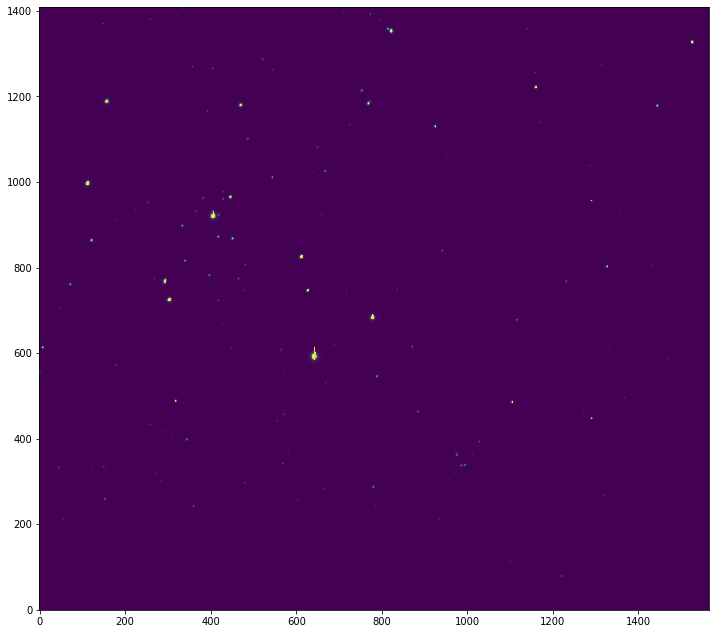

In [61]:
cts1V = np.isfinite(bigim1V).astype('int')
cts2V = np.isfinite(bigim2V).astype('int')
cts3V = np.isfinite(bigim3V).astype('int')
cts4V = np.isfinite(bigim4V).astype('int')
cts5V = np.isfinite(bigim5V).astype('int')
cts6V = np.isfinite(bigim6V).astype('int')
plt.figure(figsize=(12,12))
mosaicV0 =(bigim1V+bigim2V+bigim3V+bigim4V+bigim5V+bigim6V) / (cts1V+cts2V+cts3V+cts4V+cts5V+cts6V)
mosaicV1 = mosaicV0[0:cc+CBB_Aligned.shape[0],1283+xleft3:]
plt.imshow(mosaicV1, origin='lower', vmax=1000, vmin=0)

## I-Filters

In [62]:
bigim1I=np.zeros([2250,2250])
bigim2I=np.zeros([2250,2250])
bigim3I=np.zeros([2250,2250])
bigim4I=np.zeros([2250,2250])
bigim5I=np.zeros([2250,2250])
bigim6I=np.zeros([2250,2250])
bigim1I[aa:aa+CBB_Aligned.shape[0], bb:bb+CBB_Aligned.shape[1]] = centralI_Aligned
bigim2I[cc:cc+CBB_Aligned.shape[0], dd:dd+CBB_Aligned.shape[1]] = LCI_Aligned
bigim3I[cc-yleft1:cc-yleft1+CBB_Aligned.shape[0], dd-xleft1:dd-xleft1+CBB_Aligned.shape[1]] = LBI_Aligned
bigim4I[yleft4:yleft4+CBB_Aligned.shape[0], 1283+xleft4:1283+xleft4+CBB_Aligned.shape[1]] = CBI_Aligned
bigim5I[yleft3:yleft3+CBB_Aligned.shape[0], 1283+xleft3:1283+xleft3+CBB_Aligned.shape[1]] = RCI_Aligned
bigim6I[0:RBB_Aligned.shape[0], 1283:1283+RBB_Aligned.shape[1]] = RBI_Aligned

In [63]:
bigim1I[aa:yleft4+CBB_Aligned.shape[0],1283+xleft4:bb+CBB_Aligned.shape[1]]=0
bigim1I[aa+CBB_Aligned.shape[0]-20:,dd:bb+CBB_Aligned.shape[1]] = 0
bigim2I[cc:aa+CBB_Aligned.shape[0]-20,dd:bb+CBB_Aligned.shape[1]] = 0
bigim2I[cc:yleft4+CBB_Aligned.shape[0],bb+CBB_Aligned.shape[1]:dd+CBB_Aligned.shape[1]] = 0
bigim3I[cc-yleft1:cc-yleft1+CBB_Aligned.shape[0],dd-xleft1:dd+CBB_Aligned.shape[1]] = 0
bigim3I[cc-yleft1:yleft4+CBB_Aligned.shape[0],dd-xleft1:1283+xleft4+CBB_Aligned.shape[1]] = 0
bigim5I[aa:yleft3+CBB_Aligned.shape[0],bb:1283+xleft3+CBB_Aligned.shape[1]] = 0
bigim5I[yleft4:yleft3+CBB_Aligned.shape[0],1283+xleft4:1283+xleft3+CBB_Aligned.shape[1]] = 0
bigim5I[yleft3:RBB_Aligned.shape[0],1283:1283+xleft3+CBB_Aligned.shape[1]] = 0
bigim6I[yleft4:RBB_Aligned.shape[0],1283+xleft4:1283+RBB_Aligned.shape[1]] = 0

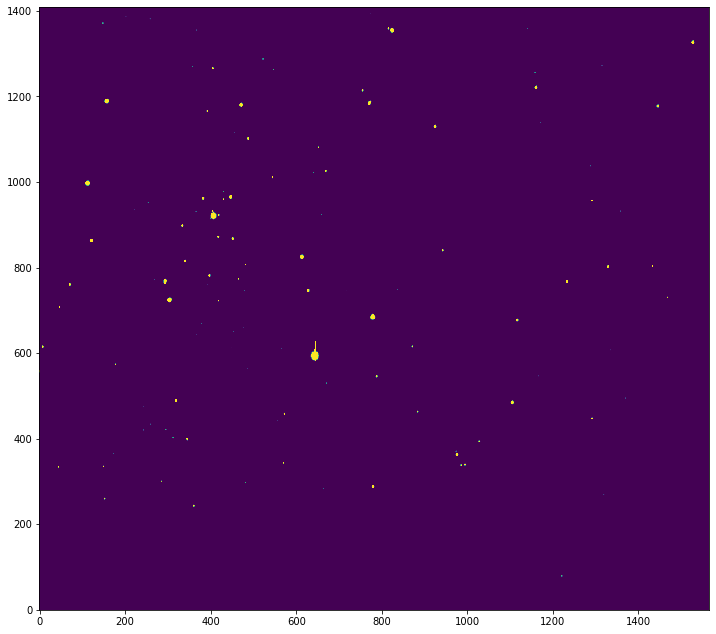

In [64]:
cts1I = np.isfinite(bigim1I).astype('int')
cts2I = np.isfinite(bigim2I).astype('int')
cts3I = np.isfinite(bigim3I).astype('int')
cts4I = np.isfinite(bigim4I).astype('int')
cts5I = np.isfinite(bigim5I).astype('int')
cts6I = np.isfinite(bigim6I).astype('int')
plt.figure(figsize=(12,12))
mosaicI0 =(bigim1I+bigim2I+bigim3I+bigim4I+bigim5I+bigim6I) / (cts1I+cts2I+cts3I+cts4I+cts5I+cts6I)
mosaicI1 = mosaicI0[0:cc+CBB_Aligned.shape[0],1283+xleft3:]
plt.imshow(mosaicI1, origin='lower', vmax=200, vmin=80)


## Another Alignment

Text(0.5, 1.0, 'Median Stack')

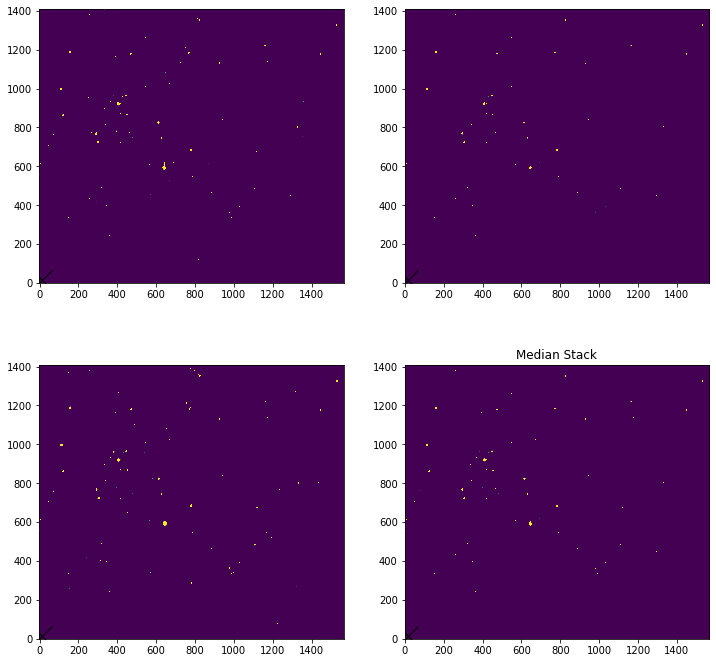

In [65]:
cutoutv = mosaicV1[670:700, 750:780]
cutoutb = mosaicB1[670:700, 750:780]
cutouti = mosaicI1[670:700, 750:780]
y5, x5 = np.indices([30,30])
xcentv = int((x5*cutoutv).sum()/cutoutv.sum() + 750)
ycentv = int((y5*cutoutv).sum()/cutoutv.sum() + 670)
xcentb = int((x5*cutoutb).sum()/cutoutb.sum() + 750)
ycentb = int((y5*cutoutb).sum()/cutoutb.sum() + 670)
xcenti = int((x5*cutouti).sum()/cutouti.sum() + 750)
ycenti = int((y5*cutouti).sum()/cutouti.sum() + 670)
mosaicV = np.roll(np.roll(mosaicV1, xcentv - xcentv, axis=1), ycentv - ycentv, axis=0)
mosaicB = np.roll(np.roll(mosaicB1, xcentv - xcentb, axis=1), ycentv - ycentb, axis=0)
mosaicI = np.roll(np.roll(mosaicI1, xcentv - xcenti, axis=1), ycentv - ycenti, axis=0)
mosaic_3 = [mosaicV, mosaicB, mosaicI]
mosaic_check = np.median(mosaic_3, axis=0)

header = fits.getheader(glob.glob("CB_25s_V*FIT")[0])
data = mosaicV
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('mosaicV_Final.FIT', overwrite=True)

header = fits.getheader(glob.glob("CB_25s_B*FIT")[0])
data = mosaicB
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('mosaicB_Final.FIT', overwrite=True)

header = fits.getheader(glob.glob("CB_25s_I*FIT")[0])
data = mosaicI
fh = fits.PrimaryHDU(data=data, header=header)
fh.writeto('mosaicI_Final.FIT', overwrite=True)

plt.figure(figsize=(12,12))

for ii in range(3):
    ax = plt.subplot(2,2,ii+1)
    ax.imshow(mosaic_3[ii], origin='lower', vmax=100, vmin=80)
    ax.plot(15, 15, 'kx', markersize=20)

ax = plt.subplot(2,2,4)
ax.imshow(mosaic_check, origin='lower', vmax=100, vmin=80)
ax.plot(15, 15, 'kx', markersize=20)

ax.set_title("Median Stack")

# Color Image!

C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


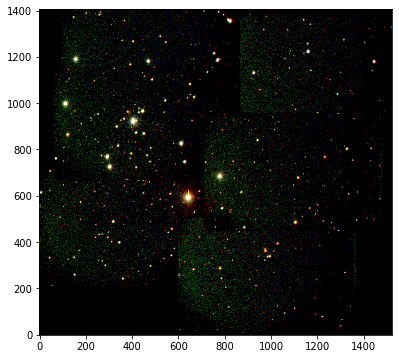

In [66]:
rgb_image1 = np.array([mosaicI, mosaicV, mosaicB]).T.swapaxes(0,1)
rgb_image1 = (rgb_image1 - np.percentile(rgb_image1, 60, axis=(0,1)))
rgb_image1 = np.log10(rgb_image1)
rgb_image1[np.isnan(rgb_image1)] = 0
rgb_image1 /= np.percentile(rgb_image1, 99.9)
rgb_image = rgb_image1[0:,0:1523]
plt.figure(figsize=(10,6))
plt.imshow(rgb_image)
plt.savefig('Rosette.png')

# Photometry

## Zero-point Calibration

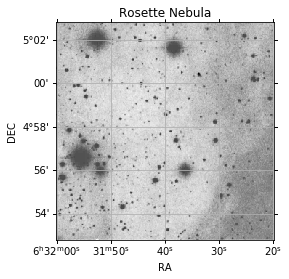

In [67]:
rosette_coord = coordinates.SkyCoord.from_name('Rosette Nebula')
rose_target = FixedTarget(rosette_coord, name="Rosette Nebula")
ax, hdu = plot_finder_image(rose_target, survey='DSS', fov_radius=10*u.arcmin)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


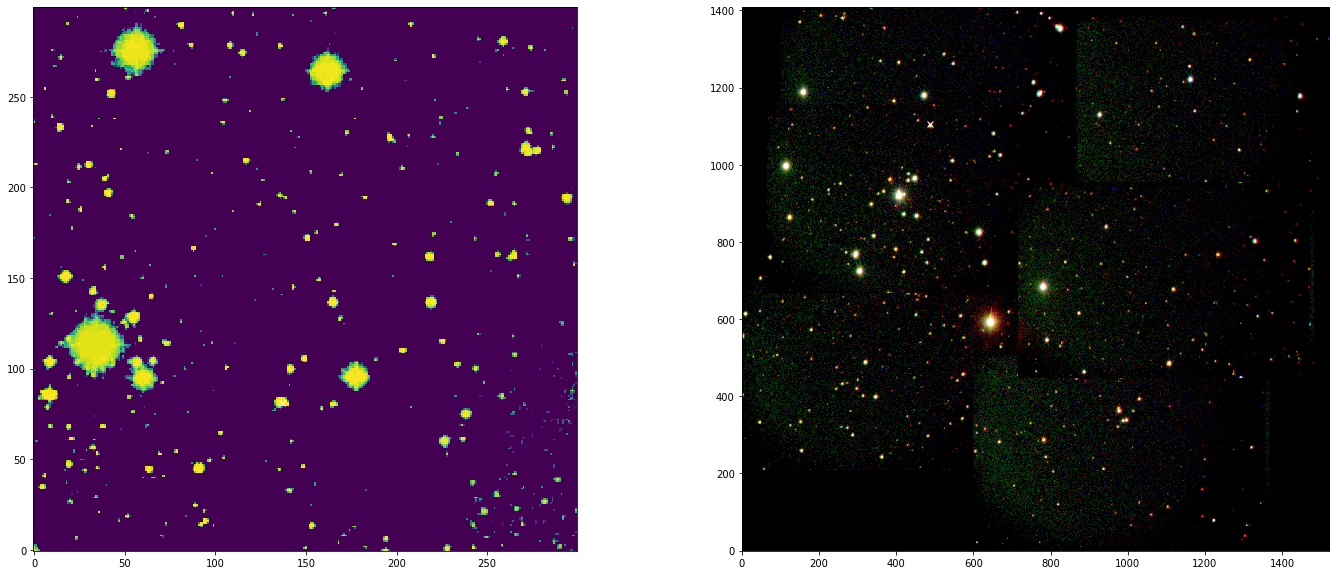

In [68]:
plt.figure(figsize=(24,10))
finder_img = hdu.data
norm = visualization.simple_norm(rgb_image, stretch='asinh', min_percent=0.1, max_percent=99.6)
fnorm = visualization.simple_norm(finder_img, stretch='asinh', min_percent=95, max_percent=99.6)
ax2 = plt.subplot(1,2,1)
ax2.imshow(finder_img, norm=fnorm)
ax2.plot(137,81,'wx')
ax1 = plt.subplot(1,2,2)
ax1.imshow(rgb_image, norm=norm)
ax1.plot(488,1105,'wx')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


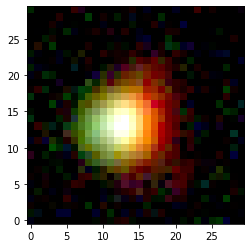

In [69]:
sx,sy = 490,1103
hsz = 15
plt.imshow(rgb_image[sy-hsz:sy+hsz,sx-hsz:sx+hsz], norm=norm)

In [70]:
ww = wcs.WCS(hdu.header)
ra1, dec1 = ww.wcs_pix2world(137,81,0)

In [71]:
center1 = coordinates.SkyCoord(ra1, dec1, frame='fk5', unit=(u.deg, u.deg))
calstar = Simbad.query_region(center1, radius=5*u.arcsec)
calstar

<Table length=1>
    MAIN_ID           RA           DEC      RA_PREC ...  FLUX_B  FLUX_I OTYPE 
                   "h:m:s"       "d:m:s"            ...   mag     mag         
     object         str13         str13      int16  ... float32 float32 object
--------------- ------------- ------------- ------- ... ------- ------- ------
NGC  2244   129 06 31 41.8592 +04 55 31.089      14 ...  13.186      --   Star

In [72]:
vizcalstar = Vizier.query_region(center1, radius=5*u.arcsec)
vizcalstar[8]

<Table length=1>
 USNO-B1.0    RAJ2000    DEJ2000   e_RAJ2000 ...  R1mag   B2mag   R2mag    Imag 
                deg        deg        mas    ...   mag     mag     mag     mag  
  bytes12     float64    float64     int16   ... float32 float32 float32 float32
------------ ---------- ---------- --------- ... ------- ------- ------- -------
0949-0094671  97.924298   4.925275       127 ...   13.12   12.61   11.10   10.27

In [73]:
vmag_calstar = calstar['FLUX_V'][0]
bmag_calstar = calstar['FLUX_B'][0]
imag_calstar = vizcalstar[8]['Imag'][0]
vmag_calstar, bmag_calstar, imag_calstar

(11.808, 13.186, 10.27)

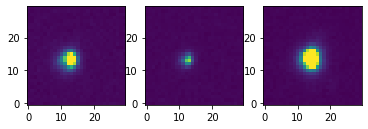

In [74]:
star_cutoutV = mosaicV[sy-hsz:sy+hsz,sx-hsz:sx+hsz]
star_cutoutB = mosaicB[sy-hsz:sy+hsz,sx-hsz:sx+hsz]
star_cutoutI = mosaicI[sy-hsz:sy+hsz,sx-hsz:sx+hsz]
bgroundV = np.median(mosaicV)
bgroundB = np.median(mosaicB)
bgroundI = np.median(mosaicI)
plt.subplot(1,3,1).imshow(star_cutoutV, vmax=200)
plt.subplot(1,3,2).imshow(star_cutoutB, vmax=200)
plt.subplot(1,3,3).imshow(star_cutoutI, vmax=200)

In [75]:
bgsub_V = mosaicV - bgroundV
filtered_V = scipy.ndimage.median_filter(bgsub_V, [3,3])
pixel_uncertainty_estimate_V = stats.mad_std(filtered_V)

bgsub_B = mosaicB - bgroundB
filtered_B = scipy.ndimage.median_filter(bgsub_B, [3,3])
pixel_uncertainty_estimate_B = stats.mad_std(filtered_B)

bgsub_I = mosaicI - bgroundI
filtered_I = scipy.ndimage.median_filter(bgsub_I, [3,3])
pixel_uncertainty_estimate_I = stats.mad_std(filtered_I)

star_countsV = (star_cutoutV-bgroundV).sum()
star_countsB = (star_cutoutB-bgroundB).sum()
star_countsI = (star_cutoutI-bgroundI).sum()
star_countsV, star_countsB, star_countsI

(6632.177750452144, 1801.011659160917, 14058.182893088559)

In [76]:
filtered = scipy.ndimage.median_filter(mosaicV, [3,3])
star_catalog = []
masked_image = np.ma.masked_array(filtered, mask=False)
max_value = masked_image.max()
while max_value > 10 * pixel_uncertainty_estimate_V:
    max_value = masked_image.max()
    by, bx = np.unravel_index(masked_image.argmax(), masked_image.shape)
    x_box_size = min(bx*2, 20)
    y_box_size = min(by*2, 20)
    if x_box_size == 0 or y_box_size == 0:
        masked_image.mask[by,bx] = True
        continue
    (total_flux, total_flux_uncertainty, mom1_x, mom1_y,
            mom1_x_uncertainty, mom1_y_uncertainty, fwhm_x,
     fwhm_y) = photometry_and_astrometry(masked_image,
                                         (by,bx),(y_box_size, x_box_size),
                                        pixel_uncertainty_estimate=pixel_uncertainty_estimate_V, background = bgroundV)
    star_catalog.append((total_flux, total_flux_uncertainty, mom1_x, mom1_y,
            mom1_x_uncertainty, mom1_y_uncertainty, fwhm_x, fwhm_y))
    
    assert masked_image.mask[by,bx]

In [77]:
star_catalog_I = []
masked_image_I = np.ma.masked_array(filtered_I, mask=False)
max_value = masked_image_I.max()
while max_value > 10 * pixel_uncertainty_estimate_I:
    max_value = masked_image_I.max()
    by, bx = np.unravel_index(masked_image_I.argmax(), masked_image_I.shape)
    x_box_size = min(bx*2, 20)
    y_box_size = min(by*2, 20)
    if x_box_size == 0 or y_box_size == 0:
        masked_image_I.mask[by,bx] = True
        continue
    (total_flux, total_flux_uncertainty, mom1_x, mom1_y,
            mom1_x_uncertainty, mom1_y_uncertainty, fwhm_x,
     fwhm_y) = photometry_and_astrometry(masked_image_I,
                                         (by,bx),(y_box_size, x_box_size),
                                         pixel_uncertainty_estimate=pixel_uncertainty_estimate_I, background = bgroundI)
    star_catalog_I.append((total_flux, total_flux_uncertainty, mom1_x, mom1_y,
            mom1_x_uncertainty, mom1_y_uncertainty, fwhm_x, fwhm_y))
    
    assert masked_image_I.mask[by,bx]

In [78]:
star_catalog = Table(rows=star_catalog,
              names="total_flux, total_flux_uncertainty, mom1_x, mom1_y, "
              "mom1_x_uncertainty, mom1_y_uncertainty, fwhm_x, fwhm_y".split(", "))
star_catalog_I = Table(rows=star_catalog_I,
              names="total_flux, total_flux_uncertainty, mom1_x, mom1_y, "
              "mom1_x_uncertainty, mom1_y_uncertainty, fwhm_x, fwhm_y".split(", "))

In [79]:
tbl = Table(rows=star_catalog,
            names="total_flux, total_flux_uncertainty, mom1_x, mom1_y, "
            "mom1_x_uncertainty, mom1_y_uncertainty, fwhm_x, fwhm_y".split(", "))
column_names = [nm+"I" for nm in tbl.colnames] + [nm+"V" for nm in tbl.colnames]
merged_table = Table(names=column_names)
row = star_catalog[0]
distances = ((star_catalog_I['mom1_x'] - row['mom1_x'])**2 + (star_catalog_I['mom1_y'] - row['mom1_y'])**2)**0.5
match_row = distances.argmin()
new_row = table.hstack([star_catalog_I[match_row], row])
for row in star_catalog:
    distances = ((star_catalog_I['mom1_x'] - row['mom1_x'])**2 + (star_catalog_I['mom1_y'] - row['mom1_y'])**2)**0.5
    match_row = distances.argmin()
    new_row = table.hstack([star_catalog_I[match_row], row])[0]
    merged_table.add_row(new_row)

In [80]:
Imag_raw = -2.5 * np.log10(merged_table['total_fluxI'])
Vmag_raw = -2.5 * np.log10(merged_table['total_fluxV'])
eImag = 1.09 * merged_table['total_flux_uncertaintyI']/merged_table['total_fluxI']
eVmag = 1.09 * merged_table['total_flux_uncertaintyV']/merged_table['total_fluxV']

In [81]:
star_mag_rawV = -2.5*np.log10(star_countsV)
star_mag_rawB = -2.5*np.log10(star_countsB)
star_mag_rawI = -2.5*np.log10(star_countsI)
star_mag_rawV, star_mag_rawB, star_mag_rawI

(-9.554140393299917, -8.138791310772959, -10.36982297267247)

In [82]:
delta_Vmag = vmag_calstar - star_mag_rawV
delta_Bmag = bmag_calstar - star_mag_rawB
delta_Imag = imag_calstar - star_mag_rawI
delta_Vmag, delta_Bmag, delta_Imag

(21.362140004200796, 21.324791181073252, 20.63982343043614)

In [83]:
mB_raw = -2.5*np.log10(mosaicB.data)
mV_raw = -2.5*np.log10(mosaicV.data)
mI_raw = -2.5*np.log10(mosaicI.data)

C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [84]:
mV = mV_raw + delta_Vmag
mB = mB_raw + delta_Bmag
mI = mI_raw + delta_Imag
Vmag = Vmag_raw + delta_Vmag
Imag = Imag_raw + delta_Imag

## Color by Color Pixel by Pixel Analysis

C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


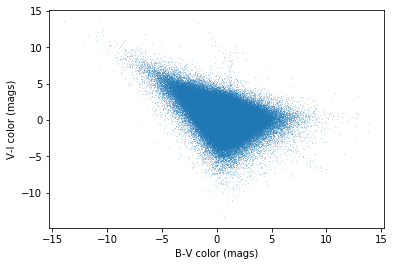

In [85]:
plt.plot((mB-mV).ravel(), (mV-mI).ravel(), ',', alpha=0.25)
plt.xlabel("B-V color (mags)"); plt.ylabel("V-I color (mags)")
plt.savefig('table_1.png')

C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


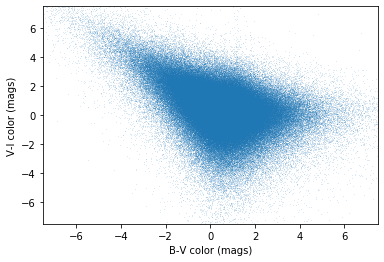

In [86]:
plt.plot((mB-mV).ravel(), (mV-mI).ravel(), ',', alpha=0.15)
plt.axis([-7.5,7.5,-7.5,7.5])
plt.xlabel("B-V color (mags)"); plt.ylabel("V-I color (mags)")
plt.savefig('table_2.png')

C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


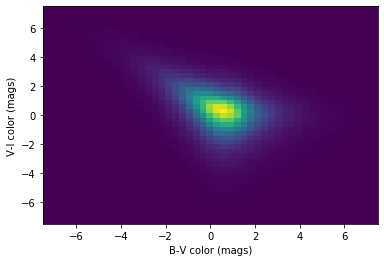

In [87]:
plt.hist2d((mB-mV).ravel(), (mV-mI).ravel(), bins=[np.linspace(-7.5,7.5), np.linspace(-7.5,7.5)])
plt.axis([-7.5,7.5,-7.5,7.5])
plt.xlabel("B-V color (mags)"); plt.ylabel("V-I color (mags)")
plt.savefig('table_3.png')

C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until


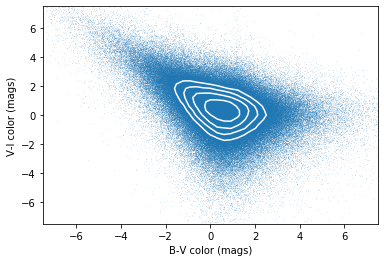

In [88]:
h2d, bx, by = np.histogram2d((mB-mV).ravel(), (mV-mI).ravel(),
                             bins=[np.linspace(-7.5,7.5), np.linspace(-7.5,7.5)])
plt.plot((mB-mV).ravel(), (mV-mI).ravel(), ',', alpha=0.15)
plt.contour((bx[1:]+bx[:-1])/2, (by[1:]+by[:-1])/2, h2d.T, colors='w',
           levels=np.logspace(3,4.5,10), zorder=5)
plt.axis([-7.5,7.5,-7.5,7.5])
plt.xlabel("B-V color (mags)"); plt.ylabel("V-I color (mags)")
plt.savefig('table_4.png')

In [89]:
where_stars = (scipy.ndimage.median_filter(mosaicI, [3,3]) - np.median(mosaicI) > 
               10*pixel_uncertainty_estimate_I)

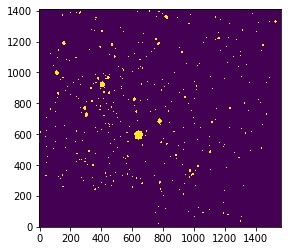

In [90]:
plt.imshow(where_stars)
plt.savefig('table_5.png')

C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


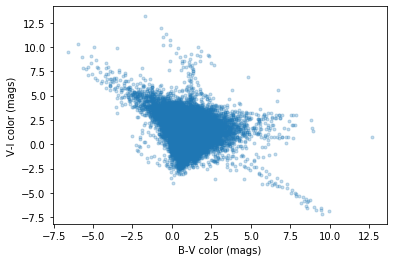

In [91]:
plt.plot((mB-mV)[where_stars], (mV-mI)[where_stars], '.', alpha=0.25)
plt.xlabel("B-V color (mags)"); plt.ylabel("V-I color (mags)")
plt.savefig('table_6.png')

In [92]:
red_pixels = mV > mI

C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


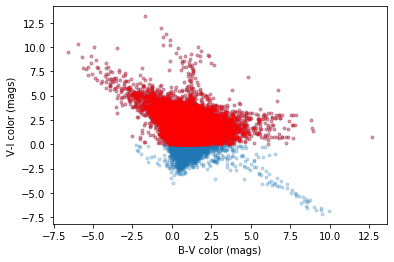

In [93]:
plt.plot((mB-mV)[where_stars], (mV-mI)[where_stars], '.', alpha=0.25)
plt.plot((mB-mV)[red_pixels & where_stars], (mV-mI)[red_pixels & where_stars], 'r.', alpha=0.25)
plt.xlabel("B-V color (mags)"); plt.ylabel("V-I color (mags)")
plt.savefig('table_7.png')

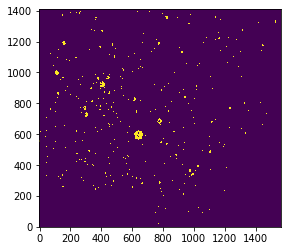

In [94]:
plt.imshow(red_pixels & where_stars)
plt.savefig('table_8.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


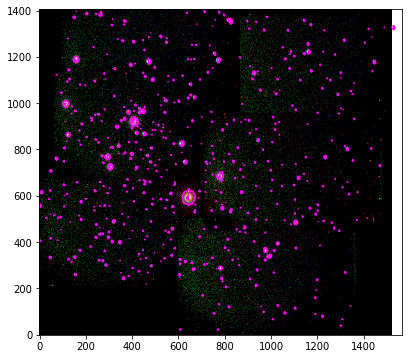

In [95]:
plt.figure(figsize=(10,6))
plt.imshow(rgb_image)
plt.contour(scipy.ndimage.median_filter(red_pixels & where_stars,[3,3]), levels=[0.5], colors=[(1,0,1)])
plt.savefig('table_9.png')

C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


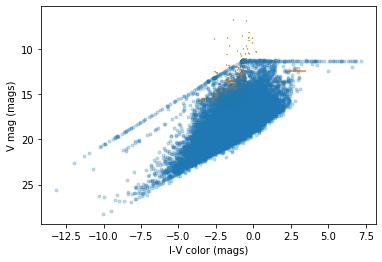

In [96]:
plt.plot((mI-mV)[where_stars], (mV)[where_stars], '.', alpha=0.25)
plt.errorbar(Imag-Vmag, Vmag, xerr=(eImag**2+eVmag**2)**0.5, yerr=eVmag, linestyle='none')
plt.gca().invert_yaxis()
plt.xlabel("I-V color (mags)"); plt.ylabel("V mag (mags)")
plt.savefig('table_10.png')

# Error Measurements

## Read Noise

The detector was CCD Photometric 3, specifically the B,V, and I filters as opposed to the R,B,G filters. 

In [97]:
biases_mean = advanced_mean("bias*FIT")
biases_std = advanced_std("bias*FIT")
print("Median bias level across all of the images =",np.median(biases_mean))
print("Median standard deviation level across each of the images =",np.median(biases_std))

Median bias level across all of the images = 1045.5
Median standard deviation level across each of the images = 10.415853301578322


## Dark Current

In [98]:
dark_file_list = glob.glob("dark*FIT")
for filename in dark_file_list:
    header = fits.getheader(filename)
    print(filename, header['EXPTIME'], header['CCD-TEMP'])

Dark_10s001.FIT 10.0 -4.817803680962
Dark_10s002.FIT 10.0 -4.817803680962
Dark_10s003.FIT 10.0 -4.817803680962
Dark_10s004.FIT 10.0 -4.817803680962
Dark_10s005.FIT 10.0 -4.817803680962
Dark_25s001.FIT 25.0 -4.817803680962
Dark_25s002.FIT 25.0 -4.817803680962
Dark_25s003.FIT 25.0 -4.817803680962
Dark_25s004.FIT 25.0 -4.817803680962
Dark_25s005.FIT 25.0 -4.817803680962
Dark_25s006.FIT 25.0 -4.817803680962
Dark_25s007.FIT 25.0 -5.23215684599
Dark_25s008.FIT 25.0 -4.817803680962
Dark_25s009.FIT 25.0 -5.23215684599
Dark_25s010.FIT 25.0 -4.817803680962
Dark_30s001.FIT 30.0 -4.817803680962
Dark_30s002.FIT 30.0 -4.817803680962
Dark_30s003.FIT 30.0 -4.817803680962
Dark_30s004.FIT 30.0 -4.817803680962
Dark_30s005.FIT 30.0 -4.817803680962
Dark_5s001.FIT 5.0 -4.817803680962
Dark_5s002.FIT 5.0 -4.817803680962
Dark_5s003.FIT 5.0 -4.817803680962
Dark_5s004.FIT 5.0 -5.23215684599
Dark_5s005.FIT 5.0 -4.817803680962


In [99]:
bsd5 = np.mean(dark5 - biases)
bsd10 = np.mean(dark10 - biases)
bsd25 = np.mean(dark25 - biases)
bsd30 = np.mean(dark30 - biases)
print("Rate estimate at 5 seconds =", bsd5/5)
print("Rate estimate at 10 seconds =", bsd10/10)
print("Rate estimate at 25 seconds =", bsd25/25)
print("Rate estimate at 30 seconds =", bsd30/30)

Rate estimate at 5 seconds = 0.292321752690646
Rate estimate at 10 seconds = 0.17577715571235014
Rate estimate at 25 seconds = 0.12155328885139455
Rate estimate at 30 seconds = 0.10100446523676833


## Centroiding Errors

### Errors on CB Alignments

In [100]:
estimated_dark_current = bsd25
pixscale = 0.6*u.arcsec/u.pixel
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in CB_V2:
    star_cutout = ii[234:264,58:88] - background1
    star_cutout_including_background = ii[234:264,58:88] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.00888886 arcsec>, <Quantity 0.00895774 arcsec>, <Quantity 0.00876682 arcsec>, <Quantity 0.00898228 arcsec>, <Quantity 0.00911057 arcsec>, <Quantity 0.00902312 arcsec>, <Quantity 0.00914905 arcsec>, <Quantity 0.00915412 arcsec>, <Quantity 0.00936862 arcsec>, <Quantity 0.00903278 arcsec>] [<Quantity 0.00948795 arcsec>, <Quantity 0.00951989 arcsec>, <Quantity 0.00957912 arcsec>, <Quantity 0.00947961 arcsec>, <Quantity 0.00956996 arcsec>, <Quantity 0.00922666 arcsec>, <Quantity 0.00929072 arcsec>, <Quantity 0.00924105 arcsec>, <Quantity 0.00999181 arcsec>, <Quantity 0.00954817 arcsec>] [<Quantity 2.76329841 arcsec>, <Quantity 2.76883777 arcsec>, <Quantity 2.75592663 arcsec>, <Quantity 2.67546944 arcsec>, <Quantity 2.75150421 arcsec>, <Quantity 2.78763333 arcsec>, <Quantity 2.77644176 arcsec>, <Quantity 2.81848882 arcsec>, <Quantity 2.77575051 arcsec>, <Quantity 2.79473939 arcsec>] [<Quantity 4.48983364 arcsec>, <Quantity 4.24548932 arcsec>, <Quantity 4.40724858 arcsec>, <Quant

In [101]:
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in CB_B2:
    star_cutout = ii[242:262,78:98] - background2
    star_cutout_including_background = ii[242:262,78:98] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.00814081 arcsec>, <Quantity 0.0087471 arcsec>, <Quantity 0.00827704 arcsec>, <Quantity 0.00786427 arcsec>, <Quantity 0.00844776 arcsec>, <Quantity 0.00847026 arcsec>, <Quantity 0.00836001 arcsec>, <Quantity 0.00793605 arcsec>, <Quantity 0.00850164 arcsec>, <Quantity 0.00834396 arcsec>] [<Quantity 0.00851275 arcsec>, <Quantity 0.00857204 arcsec>, <Quantity 0.00814446 arcsec>, <Quantity 0.00817253 arcsec>, <Quantity 0.00818927 arcsec>, <Quantity 0.00847341 arcsec>, <Quantity 0.00786552 arcsec>, <Quantity 0.00780827 arcsec>, <Quantity 0.00803455 arcsec>, <Quantity 0.00765879 arcsec>] [<Quantity 2.18027702 arcsec>, <Quantity 2.14674373 arcsec>, <Quantity 2.23190583 arcsec>, <Quantity 2.22473972 arcsec>, <Quantity 2.26509529 arcsec>, <Quantity 2.27917647 arcsec>, <Quantity 2.81400247 arcsec>, <Quantity 2.5819684 arcsec>, <Quantity 2.66120034 arcsec>, <Quantity 2.92720522 arcsec>] [<Quantity 2.78731785 arcsec>, <Quantity 2.57900909 arcsec>, <Quantity 3.00248722 arcsec>, <Quantit

In [102]:
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in CB_I2:
    star_cutout = ii[222:252,51:81] - background3
    star_cutout_including_background = ii[222:252,51:81] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.00967674 arcsec>, <Quantity 0.00958825 arcsec>, <Quantity 0.00960561 arcsec>, <Quantity 0.01014863 arcsec>, <Quantity 0.00995826 arcsec>, <Quantity 0.00941124 arcsec>, <Quantity 0.00968591 arcsec>, <Quantity 0.009456 arcsec>, <Quantity 0.00975623 arcsec>] [<Quantity 0.00980154 arcsec>, <Quantity 0.00941068 arcsec>, <Quantity 0.01006128 arcsec>, <Quantity 0.0096521 arcsec>, <Quantity 0.00952786 arcsec>, <Quantity 0.00987735 arcsec>, <Quantity 0.00999361 arcsec>, <Quantity 0.00966741 arcsec>, <Quantity 0.00963179 arcsec>] [<Quantity 3.02442405 arcsec>, <Quantity 3.06895219 arcsec>, <Quantity 3.09098751 arcsec>, <Quantity 3.08440007 arcsec>, <Quantity 3.05125423 arcsec>, <Quantity 3.03606168 arcsec>, <Quantity 3.02022445 arcsec>, <Quantity 3.00395145 arcsec>, <Quantity 2.97851463 arcsec>] [<Quantity 3.657477 arcsec>, <Quantity 3.79318966 arcsec>, <Quantity 3.56469419 arcsec>, <Quantity 3.56900285 arcsec>, <Quantity 3.61492246 arcsec>, <Quantity 3.61552002 arcsec>, <Quantity 3

### Errors on Central Alignments

In [103]:
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in central_V2:
    star_cutout = ii[194:214,48:68] - background4
    star_cutout_including_background = ii[194:214,48:68] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.02947654 arcsec>, <Quantity 0.03047235 arcsec>, <Quantity 0.02975954 arcsec>, <Quantity 0.02912106 arcsec>, <Quantity 0.02833916 arcsec>, <Quantity 0.02918913 arcsec>, <Quantity 0.02857347 arcsec>, <Quantity 0.02832896 arcsec>, <Quantity 0.02804393 arcsec>] [<Quantity 0.02836702 arcsec>, <Quantity 0.02842561 arcsec>, <Quantity 0.02969878 arcsec>, <Quantity 0.02823457 arcsec>, <Quantity 0.02869563 arcsec>, <Quantity 0.02697649 arcsec>, <Quantity 0.02856087 arcsec>, <Quantity 0.02918864 arcsec>, <Quantity 0.02801929 arcsec>] [<Quantity 2.80622246 arcsec>, <Quantity 2.93530929 arcsec>, <Quantity 2.77602093 arcsec>, <Quantity 2.90015915 arcsec>, <Quantity 2.87488195 arcsec>, <Quantity 2.94433948 arcsec>, <Quantity 2.90136339 arcsec>, <Quantity 2.87561685 arcsec>, <Quantity 2.87393885 arcsec>] [<Quantity 2.83111297 arcsec>, <Quantity 3.01086278 arcsec>, <Quantity 3.10690833 arcsec>, <Quantity 2.98181919 arcsec>, <Quantity 3.1126028 arcsec>, <Quantity 3.22838903 arcsec>, <Quanti

In [104]:
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in central_B2:
    star_cutout = ii[194:208,51:65] - background5
    star_cutout_including_background = ii[194:208,51:65] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.03599049 arcsec>, <Quantity 0.03505451 arcsec>, <Quantity 0.03485398 arcsec>, <Quantity 0.03653821 arcsec>, <Quantity 0.03857509 arcsec>, <Quantity 0.03703851 arcsec>, <Quantity 0.03852907 arcsec>, <Quantity 0.03829548 arcsec>] [<Quantity 0.0384468 arcsec>, <Quantity 0.03937918 arcsec>, <Quantity 0.03633954 arcsec>, <Quantity 0.03774805 arcsec>, <Quantity 0.03847825 arcsec>, <Quantity 0.03799823 arcsec>, <Quantity 0.03872292 arcsec>, <Quantity 0.03801699 arcsec>] [<Quantity 2.09468288 arcsec>, <Quantity 2.09456499 arcsec>, <Quantity 1.94723126 arcsec>, <Quantity 2.03630552 arcsec>, <Quantity 2.08009558 arcsec>, <Quantity 2.09687399 arcsec>, <Quantity 2.03945631 arcsec>, <Quantity 1.9282357 arcsec>] [<Quantity 2.3853005 arcsec>, <Quantity 2.16658056 arcsec>, <Quantity 2.10532432 arcsec>, <Quantity 2.22579411 arcsec>, <Quantity 2.08836199 arcsec>, <Quantity 2.20593495 arcsec>, <Quantity 2.20184875 arcsec>, <Quantity 2.10382289 arcsec>]


In [105]:
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in central_I2:
    star_cutout = ii[185:205,50:70] - background6
    star_cutout_including_background = ii[185:205,50:70] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.01885651 arcsec>, <Quantity 0.01881315 arcsec>, <Quantity 0.01960247 arcsec>, <Quantity 0.01867315 arcsec>, <Quantity 0.01961471 arcsec>, <Quantity 0.01843953 arcsec>, <Quantity 0.01912433 arcsec>, <Quantity 0.01983552 arcsec>, <Quantity 0.0197 arcsec>] [<Quantity 0.02008738 arcsec>, <Quantity 0.01971273 arcsec>, <Quantity 0.01995067 arcsec>, <Quantity 0.01969098 arcsec>, <Quantity 0.01962252 arcsec>, <Quantity 0.02016765 arcsec>, <Quantity 0.018697 arcsec>, <Quantity 0.01991503 arcsec>, <Quantity 0.01960124 arcsec>] [<Quantity 2.76985088 arcsec>, <Quantity 2.78283909 arcsec>, <Quantity 2.77925907 arcsec>, <Quantity 2.7776158 arcsec>, <Quantity 2.74291662 arcsec>, <Quantity 2.75189111 arcsec>, <Quantity 2.69902455 arcsec>, <Quantity 2.69466501 arcsec>, <Quantity 2.71085992 arcsec>] [<Quantity 3.25170406 arcsec>, <Quantity 3.10137374 arcsec>, <Quantity 2.93300087 arcsec>, <Quantity 2.90376351 arcsec>, <Quantity 2.96277942 arcsec>, <Quantity 2.92111489 arcsec>, <Quantity 2.9

### Errors on LB Alignments

In [106]:
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in LB_V2:
    star_cutout = ii[244:264,131:151] - background7
    star_cutout_including_background = ii[244:264,131:151] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.02909349 arcsec>, <Quantity 0.02943264 arcsec>, <Quantity 0.02854156 arcsec>, <Quantity 0.02955281 arcsec>, <Quantity 0.02819103 arcsec>, <Quantity 0.02967568 arcsec>, <Quantity 0.02882991 arcsec>, <Quantity 0.0285986 arcsec>] [<Quantity 0.02810829 arcsec>, <Quantity 0.03000399 arcsec>, <Quantity 0.02866931 arcsec>, <Quantity 0.02818266 arcsec>, <Quantity 0.02834832 arcsec>, <Quantity 0.02926042 arcsec>, <Quantity 0.03054296 arcsec>, <Quantity 0.02875653 arcsec>] [<Quantity 2.62590907 arcsec>, <Quantity 2.62620385 arcsec>, <Quantity 2.60766817 arcsec>, <Quantity 2.56037153 arcsec>, <Quantity 2.45757997 arcsec>, <Quantity 2.55103727 arcsec>, <Quantity 2.71451443 arcsec>, <Quantity 2.75658859 arcsec>] [<Quantity 2.68835457 arcsec>, <Quantity 2.96041923 arcsec>, <Quantity 3.02626313 arcsec>, <Quantity 2.93180114 arcsec>, <Quantity 2.64627031 arcsec>, <Quantity 2.750411 arcsec>, <Quantity 3.04348098 arcsec>, <Quantity 2.83612039 arcsec>]


In [107]:
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in LB_B2:
    star_cutout = ii[254:274,141:161] - background8
    star_cutout_including_background = ii[254:274,141:161] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.04721832 arcsec>, <Quantity 0.04776837 arcsec>, <Quantity 0.0469398 arcsec>, <Quantity 0.04959291 arcsec>, <Quantity 0.05225231 arcsec>, <Quantity 0.04850337 arcsec>, <Quantity 0.04968217 arcsec>, <Quantity 0.04952406 arcsec>, <Quantity 0.04744401 arcsec>] [<Quantity 0.04736817 arcsec>, <Quantity 0.04806557 arcsec>, <Quantity 0.04745171 arcsec>, <Quantity 0.05020836 arcsec>, <Quantity 0.05339469 arcsec>, <Quantity 0.05060426 arcsec>, <Quantity 0.04900864 arcsec>, <Quantity 0.05109835 arcsec>, <Quantity 0.04911543 arcsec>] [<Quantity 2.41224667 arcsec>, <Quantity 2.60162669 arcsec>, <Quantity 2.80149625 arcsec>, <Quantity 2.99981782 arcsec>, <Quantity 2.62867178 arcsec>, <Quantity 2.96425493 arcsec>, <Quantity 2.99616609 arcsec>, <Quantity 3.09958442 arcsec>, <Quantity 3.05003961 arcsec>] [<Quantity 3.06707187 arcsec>, <Quantity 2.7355032 arcsec>, <Quantity 2.95442688 arcsec>, <Quantity 3.13386882 arcsec>, <Quantity 2.71619335 arcsec>, <Quantity 3.25172588 arcsec>, <Quantit

In [108]:
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in LB_I2:
    star_cutout = ii[245:265,129:149] - background9
    star_cutout_including_background = ii[245:265,129:149] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.02524341 arcsec>, <Quantity 0.02543023 arcsec>, <Quantity 0.02520269 arcsec>, <Quantity 0.02525673 arcsec>, <Quantity 0.02477967 arcsec>, <Quantity 0.02366709 arcsec>, <Quantity 0.0237901 arcsec>, <Quantity 0.02426798 arcsec>, <Quantity 0.02456013 arcsec>] [<Quantity 0.02631705 arcsec>, <Quantity 0.02499737 arcsec>, <Quantity 0.02588212 arcsec>, <Quantity 0.02578287 arcsec>, <Quantity 0.02489836 arcsec>, <Quantity 0.02744309 arcsec>, <Quantity 0.02529194 arcsec>, <Quantity 0.02575542 arcsec>, <Quantity 0.02387606 arcsec>] [<Quantity 2.76692161 arcsec>, <Quantity 2.72193553 arcsec>, <Quantity 2.73327116 arcsec>, <Quantity 2.72224634 arcsec>, <Quantity 2.83842271 arcsec>, <Quantity 2.82792901 arcsec>, <Quantity 2.7913192 arcsec>, <Quantity 2.69961107 arcsec>, <Quantity 2.69660769 arcsec>] [<Quantity 3.00870771 arcsec>, <Quantity 3.26376268 arcsec>, <Quantity 2.97843539 arcsec>, <Quantity 3.36215612 arcsec>, <Quantity 3.17159184 arcsec>, <Quantity 2.9977273 arcsec>, <Quantity

### Errors on LC Alignments

In [109]:
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in LC_V2:
    star_cutout = ii[44:64,150:170] - background10
    star_cutout_including_background = ii[44:64,150:170] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.20807704 arcsec>, <Quantity 0.21448979 arcsec>, <Quantity 0.18721263 arcsec>, <Quantity 0.19435916 arcsec>, <Quantity 0.19889423 arcsec>, <Quantity 0.1827235 arcsec>, <Quantity 0.20456665 arcsec>, <Quantity 0.19283535 arcsec>, <Quantity 0.1938365 arcsec>] [<Quantity 0.20867506 arcsec>, <Quantity 0.21677375 arcsec>, <Quantity 0.19537907 arcsec>, <Quantity 0.19969794 arcsec>, <Quantity 0.20027751 arcsec>, <Quantity 0.19234726 arcsec>, <Quantity 0.21143708 arcsec>, <Quantity 0.19724174 arcsec>, <Quantity 0.19856064 arcsec>] [<Quantity 2.69660769 arcsec>, <Quantity 2.69660769 arcsec>, <Quantity 2.69660769 arcsec>, <Quantity 2.69660769 arcsec>, <Quantity 2.69660769 arcsec>, <Quantity 2.69660769 arcsec>, <Quantity 2.69660769 arcsec>, <Quantity 2.69660769 arcsec>, <Quantity 2.69660769 arcsec>] [<Quantity 3.10548129 arcsec>, <Quantity 3.10548129 arcsec>, <Quantity 3.10548129 arcsec>, <Quantity 3.10548129 arcsec>, <Quantity 3.10548129 arcsec>, <Quantity 3.10548129 arcsec>, <Quantit

In [110]:
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in LC_B2:
    star_cutout = ii[44:64,150:170] - background11
    star_cutout_including_background = ii[44:64,150:170] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.36216781 arcsec>, <Quantity 0.34369858 arcsec>, <Quantity 0.33035552 arcsec>, <Quantity 0.30407098 arcsec>, <Quantity 0.31554057 arcsec>, <Quantity 0.32187556 arcsec>, <Quantity 0.38725908 arcsec>] [<Quantity 0.3885385 arcsec>, <Quantity 0.35337734 arcsec>, <Quantity 0.34475272 arcsec>, <Quantity 0.30924615 arcsec>, <Quantity 0.31358278 arcsec>, <Quantity 0.33949927 arcsec>, <Quantity 0.39865093 arcsec>] [<Quantity nan arcsec>, <Quantity 2.15780058 arcsec>, <Quantity 1.82432988 arcsec>, <Quantity 2.71592475 arcsec>, <Quantity 2.98219642 arcsec>, <Quantity 2.96419659 arcsec>, <Quantity 1.64827377 arcsec>] [<Quantity 0.85737012 arcsec>, <Quantity 3.522291 arcsec>, <Quantity 2.23272289 arcsec>, <Quantity 3.23224263 arcsec>, <Quantity 4.04499746 arcsec>, <Quantity 3.80794788 arcsec>, <Quantity 1.52560221 arcsec>]


C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [111]:
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in LC_I2:
    star_cutout = ii[42:62,145:165] - background12
    star_cutout_including_background = ii[42:62,145:165] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.19434744 arcsec>, <Quantity 0.19143598 arcsec>, <Quantity 0.19096312 arcsec>, <Quantity 0.18596608 arcsec>, <Quantity 0.18968021 arcsec>, <Quantity 0.18470064 arcsec>, <Quantity 0.17855943 arcsec>, <Quantity 0.18401298 arcsec>, <Quantity 0.17647916 arcsec>, <Quantity 0.17456104 arcsec>] [<Quantity 0.1946728 arcsec>, <Quantity 0.19519806 arcsec>, <Quantity 0.18776636 arcsec>, <Quantity 0.18665475 arcsec>, <Quantity 0.19057754 arcsec>, <Quantity 0.19478358 arcsec>, <Quantity 0.17998728 arcsec>, <Quantity 0.17850074 arcsec>, <Quantity 0.17964609 arcsec>, <Quantity 0.17853775 arcsec>] [<Quantity 2.33094816 arcsec>, <Quantity 2.59916049 arcsec>, <Quantity 2.48305373 arcsec>, <Quantity 2.49299889 arcsec>, <Quantity 1.9159934 arcsec>, <Quantity 2.41861277 arcsec>, <Quantity 2.66930309 arcsec>, <Quantity 2.60668502 arcsec>, <Quantity 3.0780885 arcsec>, <Quantity 2.76245738 arcsec>] [<Quantity 2.50375322 arcsec>, <Quantity 2.65850804 arcsec>, <Quantity 2.80438035 arcsec>, <Quantity

### Errors on RB Alignments

In [112]:
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in RB_V2:
    star_cutout = ii[277:297,67:87] - background13
    star_cutout_including_background = ii[277:297,67:87] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.17021153 arcsec>, <Quantity 0.16643418 arcsec>, <Quantity 0.16958108 arcsec>, <Quantity 0.16781447 arcsec>, <Quantity 0.16378908 arcsec>, <Quantity 0.16112306 arcsec>, <Quantity 0.15793684 arcsec>, <Quantity 0.15936992 arcsec>] [<Quantity 0.17038103 arcsec>, <Quantity 0.16977491 arcsec>, <Quantity 0.17230237 arcsec>, <Quantity 0.17105503 arcsec>, <Quantity 0.16948672 arcsec>, <Quantity 0.16333116 arcsec>, <Quantity 0.15468199 arcsec>, <Quantity 0.15928285 arcsec>] [<Quantity 4.45181756 arcsec>, <Quantity 4.50671158 arcsec>, <Quantity 4.25085945 arcsec>, <Quantity 4.05778888 arcsec>, <Quantity 3.77690037 arcsec>, <Quantity 4.66524199 arcsec>, <Quantity 4.65422212 arcsec>, <Quantity 4.45300739 arcsec>] [<Quantity 4.29623355 arcsec>, <Quantity 4.19065526 arcsec>, <Quantity 4.23027968 arcsec>, <Quantity 4.29064011 arcsec>, <Quantity 4.05407156 arcsec>, <Quantity 4.74885019 arcsec>, <Quantity 4.83681275 arcsec>, <Quantity 4.62499273 arcsec>]


In [113]:
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in RB_B2:
    star_cutout = ii[274:294,77:97] - background14
    star_cutout_including_background = ii[274:294,77:97] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.28336722 arcsec>, <Quantity 0.32168217 arcsec>, <Quantity 0.31195451 arcsec>, <Quantity 0.30219293 arcsec>, <Quantity 0.30014509 arcsec>, <Quantity 0.28278435 arcsec>, <Quantity 0.27489439 arcsec>, <Quantity 0.27050267 arcsec>] [<Quantity 0.28793273 arcsec>, <Quantity 0.34481616 arcsec>, <Quantity 0.32287477 arcsec>, <Quantity 0.31136449 arcsec>, <Quantity 0.3160434 arcsec>, <Quantity 0.28577364 arcsec>, <Quantity 0.28598082 arcsec>, <Quantity 0.27285304 arcsec>] [<Quantity 3.18161903 arcsec>, <Quantity 1.70988573 arcsec>, <Quantity 3.0664721 arcsec>, <Quantity 3.68774572 arcsec>, <Quantity 4.0785369 arcsec>, <Quantity 3.55007505 arcsec>, <Quantity 3.8336764 arcsec>, <Quantity 3.65711971 arcsec>] [<Quantity 3.34464662 arcsec>, <Quantity 1.85775656 arcsec>, <Quantity 4.10114706 arcsec>, <Quantity 3.81899316 arcsec>, <Quantity 3.64546078 arcsec>, <Quantity 3.34672544 arcsec>, <Quantity 3.71296949 arcsec>, <Quantity 3.72714396 arcsec>]


In [114]:
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in RB_I2:
    star_cutout = ii[272:292,57:77] - background15
    star_cutout_including_background = ii[272:292,57:77] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.14762983 arcsec>, <Quantity 0.14334179 arcsec>, <Quantity 0.14292159 arcsec>, <Quantity 0.1483319 arcsec>, <Quantity 0.13740761 arcsec>, <Quantity 0.1412497 arcsec>, <Quantity 0.14780171 arcsec>, <Quantity 0.14901298 arcsec>] [<Quantity 0.14403462 arcsec>, <Quantity 0.14256418 arcsec>, <Quantity 0.14486946 arcsec>, <Quantity 0.14284187 arcsec>, <Quantity 0.13250642 arcsec>, <Quantity 0.14112539 arcsec>, <Quantity 0.14544229 arcsec>, <Quantity 0.14556774 arcsec>] [<Quantity 2.41452991 arcsec>, <Quantity 3.11160556 arcsec>, <Quantity 4.15364219 arcsec>, <Quantity 3.23623704 arcsec>, <Quantity 4.73582988 arcsec>, <Quantity 3.86547215 arcsec>, <Quantity 3.79022461 arcsec>, <Quantity 3.58227872 arcsec>] [<Quantity 2.5833839 arcsec>, <Quantity 3.36929355 arcsec>, <Quantity 4.12365469 arcsec>, <Quantity 3.76994011 arcsec>, <Quantity 4.81647858 arcsec>, <Quantity 3.8759701 arcsec>, <Quantity 4.02810029 arcsec>, <Quantity 3.81766707 arcsec>]


### Errors on RC Alignments

In [115]:
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in RC_V2:
    star_cutout = ii[116:136,141:161] - background16
    star_cutout_including_background = ii[116:136,141:161] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.11872437 arcsec>, <Quantity 0.12152295 arcsec>, <Quantity 0.1221842 arcsec>, <Quantity 0.12112283 arcsec>, <Quantity 0.12178905 arcsec>, <Quantity 0.11725954 arcsec>, <Quantity 0.11929652 arcsec>, <Quantity 0.11495014 arcsec>] [<Quantity 0.1223125 arcsec>, <Quantity 0.12130767 arcsec>, <Quantity 0.12582259 arcsec>, <Quantity 0.12043385 arcsec>, <Quantity 0.12366916 arcsec>, <Quantity 0.12468243 arcsec>, <Quantity 0.12420528 arcsec>, <Quantity 0.11597179 arcsec>] [<Quantity 3.49342502 arcsec>, <Quantity 3.25351553 arcsec>, <Quantity 3.19180486 arcsec>, <Quantity 3.46079449 arcsec>, <Quantity 3.54403709 arcsec>, <Quantity 3.37889976 arcsec>, <Quantity 3.70007377 arcsec>, <Quantity 3.92531459 arcsec>] [<Quantity 3.87639411 arcsec>, <Quantity 3.64047828 arcsec>, <Quantity 3.37397981 arcsec>, <Quantity 3.41864239 arcsec>, <Quantity 3.57439486 arcsec>, <Quantity 3.62673271 arcsec>, <Quantity 3.75024788 arcsec>, <Quantity 3.96347578 arcsec>]


In [116]:
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in RC_B2:
    star_cutout = ii[113:133,141:161] - background17
    star_cutout_including_background = ii[113:133,141:161] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.22123801 arcsec>, <Quantity 0.21606828 arcsec>, <Quantity 0.21775334 arcsec>, <Quantity 0.22434157 arcsec>, <Quantity 0.23537445 arcsec>, <Quantity 0.23348115 arcsec>, <Quantity 0.23726477 arcsec>, <Quantity 0.24609827 arcsec>] [<Quantity 0.23073793 arcsec>, <Quantity 0.21860971 arcsec>, <Quantity 0.2260564 arcsec>, <Quantity 0.22708564 arcsec>, <Quantity 0.23726658 arcsec>, <Quantity 0.2286292 arcsec>, <Quantity 0.23179165 arcsec>, <Quantity 0.24058651 arcsec>] [<Quantity 3.62922101 arcsec>, <Quantity 2.79813018 arcsec>, <Quantity 3.55536923 arcsec>, <Quantity 2.5524003 arcsec>, <Quantity 1.59568578 arcsec>, <Quantity 2.94619327 arcsec>, <Quantity 1.87740392 arcsec>, <Quantity 1.00954297 arcsec>] [<Quantity 3.87422937 arcsec>, <Quantity 3.21695148 arcsec>, <Quantity 3.36744768 arcsec>, <Quantity 2.62255317 arcsec>, <Quantity 1.9492162 arcsec>, <Quantity 2.61818675 arcsec>, <Quantity 2.97168244 arcsec>, <Quantity 1.75946747 arcsec>]


In [117]:
errorx = []
errory = []
fwhmx = []
fwhmy = []
for ii in RC_I2:
    star_cutout = ii[114:134,141:161] - background18
    star_cutout_including_background = ii[114:134,141:161] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
    fwhmx.append(fwhm_x_arcsec)
    fwhmy.append(fwhm_y_arcsec)
print(errorx, errory, fwhmx, fwhmy)

[<Quantity 0.09668417 arcsec>, <Quantity 0.09683397 arcsec>, <Quantity 0.09885238 arcsec>, <Quantity 0.09492753 arcsec>, <Quantity 0.09641993 arcsec>, <Quantity 0.09895672 arcsec>, <Quantity 0.09694927 arcsec>] [<Quantity 0.09468907 arcsec>, <Quantity 0.10039422 arcsec>, <Quantity 0.09674884 arcsec>, <Quantity 0.09192511 arcsec>, <Quantity 0.09793046 arcsec>, <Quantity 0.09824916 arcsec>, <Quantity 0.10020749 arcsec>] [<Quantity 2.60184226 arcsec>, <Quantity 2.78508344 arcsec>, <Quantity 2.52322416 arcsec>, <Quantity 2.82188413 arcsec>, <Quantity 2.89173737 arcsec>, <Quantity 3.06799491 arcsec>, <Quantity 3.09961145 arcsec>] [<Quantity 2.7637028 arcsec>, <Quantity 2.92290351 arcsec>, <Quantity 2.8355485 arcsec>, <Quantity 3.24592144 arcsec>, <Quantity 3.12895644 arcsec>, <Quantity 3.45619977 arcsec>, <Quantity 3.44920688 arcsec>]


### Error on Mosaic Alignments

In [118]:
errorx = []
errory = []
for ii in range(6):
    star_cutout = cutouts[ii]
    star_cutout_including_background = cutouts[ii] + backgroundV[ii] + estimated_dark_current
    readnoise_squared = 100
    sigma_squared_F = star_cutout_including_background + readnoise_squared
    F = star_cutout
    yi, xi = np.indices(star_cutout.shape)
    sigma_squared_xi = ((sigma_squared_F * xi**2).sum() / F.sum()**2 +
                    (xi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    sigma_squared_yi = ((sigma_squared_F * yi**2).sum() / F.sum()**2 +
                    (yi*F).sum()**2 * sigma_squared_F.sum() / F.sum()**4)
    mom1_x = (xi*star_cutout).sum()/star_cutout.sum()
    mom1_y = (yi*star_cutout).sum()/star_cutout.sum()
    mom2_x = ((xi - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yi - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    errorx.append((sigma_squared_xi**0.5)*u.pix * pixscale)
    errory.append((sigma_squared_yi**0.5)*u.pix * pixscale)
print(errorx, errory)

[<Quantity 0.31250789 arcsec>, <Quantity 0.24080182 arcsec>, <Quantity 0.03917 arcsec>, <Quantity 0.03424588 arcsec>, <Quantity 0.02078635 arcsec>, <Quantity 0.0209167 arcsec>] [<Quantity 0.31148639 arcsec>, <Quantity 0.27975165 arcsec>, <Quantity 0.0292758 arcsec>, <Quantity 0.03189219 arcsec>, <Quantity 0.01731486 arcsec>, <Quantity 0.02255474 arcsec>]
